In [ ]:
### Author: Karssien Hero Huisman.
### Hartree Fock Approximation : Semi Infinite Leads
### IMPORTANT:
### onsite energies of the leads are constant epsilon0L,epsilonR = 0,0.
### they do not change with bias voltage

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '/Users/khhuisman/Documents/Jupyter_notebooks/Paper3_SIFLeads/Modules_SIF')

### Scattering Region

In [3]:
import Sgeom_scatteringregion #Hamiltonian without interactions U=0, not coupled to leads

### Import NEGF methods

In [4]:
import negf_SIF_HFA as negf_method               ### negf code
import Integration_SIF_HFA as Integration_method ### for calculating electron densities
import Currents_HFA_SIF as Current_method        ### for calculatin currents

# P Value

In [5]:
import handy_functions_coulomb as hfc #some usefull functions
import Pvalue                         ## for calculating the P-value

In [6]:

def func_energies(Hamiltonian0,U,npoints,Vmax,
                  epsilon0L,tleadL,epsilon0R,tleadR,pz):
    

    #If tleadL or tleadR is enormous treat it like WBL
    evlist = np.linalg.eigh(Hamiltonian0)[0]
    evlist_shifted = np.add(evlist,[U/2 for i in range(len(evlist))])
    e_lumo = evlist_shifted[int(Hamiltonian0.shape[0]/2)-1]
    e_homo = evlist_shifted[int(Hamiltonian0.shape[0]/2)]
    
    #Fermi Energy
    hl_gap = e_lumo - e_homo
    
    
    
    #lower,upper bound for Glesser function
    emin = np.round(int(10*min(evlist_shifted))/10 - 10,2) #lower bound for integrals
    emax = np.round(int(10*max(evlist_shifted))/10 + 10,2)   #lower bound for integrals
    
    
    
    #####
    de = 0.1
    energiesL = np.linspace(-2*tleadL + epsilon0L - pz*2*tleadL - de  ,
                               epsilon0L + pz*2*tleadL + 2*tleadL + de  , npoints) #energies to integrate Glesser function over
    
    energiesR = np.linspace(-2*tleadR + epsilon0R - de ,
                               epsilon0R + 2*tleadR + de   , npoints) #energies to integrate Glesser function over
    
    eminL = min(energiesL)
    emaxL = max(energiesL)
    
    eminR = min(energiesR)
    emaxR = max(energiesR)
    
    if eminL <= eminR and emaxL >= emaxR:
        energies = energiesL
    if eminL > eminR and emaxL < emaxR:
        energies = energiesR
    
    eflist = [0  ]
    ef = 0


    
    return energies,ef

In [7]:
def plot_occupation_difference(nP_list_conv,nM_list_conv,V_list_convg,Hamiltonian0):
    dimlist = hfc.func_list_i(Hamiltonian0)
    plt.title('$n_{is}(m,V) - n_{i\overline{s}}(-m,V)$')
    n_list_total_convgM_swap = [hfc.pairwise_swap([ nM_list_conv[i][k] for k in dimlist]) for i in range(len(V_list_convg))
                              ]
    nP_list_plot =[ [nP_list_conv[i][k] for k in dimlist ] for i in range(len(V_list_convg)) ]


    plt.plot(V_list_convg,np.subtract(nP_list_plot,n_list_total_convgM_swap))
    plt.xlabel('Bias Voltage [eV] ')
    plt.ylabel('Electron Density')
    plt.ticklabel_format(style="sci", scilimits=(0,0))

    plt.show()


def plot_densities_symmtry_relation(dim,V_list,n_list):
    ones = [1 for i in range(dim)]
    n_list_swap = [np.subtract(ones,hfc.pairwise_swap(n_list[-1-i])) for i in range(len(n_list))]

    plt.title('$n_{is}(m,V) + n_{i\overline{s}}(m,-V) - 1$')
    plt.plot(V_list,np.subtract(n_list,n_list_swap))
    plt.xlabel('Bias Voltage [eV] ')
    plt.ylabel('Electron Density')
    plt.ticklabel_format(style="sci", scilimits=(0,0))


    plt.show()
    
    
def plot_densities_symmtry_relation2(nP_list,nM_list,V_list,dim):
    
    dimlist = [i for i in range(dim)]
    ones = [1 for i in range(dim)]
    n_list_swapM = [np.subtract(ones,hfc.pairwise_swap(nM_list[-1-i])) for i in range(len(nM_list))]
    nP_list_plot =[ [nP_list[i][k] for k in dimlist ] for i in range(len(V_list)) ]

    plt.title('$n_{is}(m,V) + n_{i\overline{s}}(-m,-V) - 1$')
    plt.plot(V_list,np.subtract(nP_list_plot,n_list_swapM))
    plt.xlabel('Bias Voltage [eV] ')
    plt.ylabel('Electron Density')
    plt.ticklabel_format(style="sci", scilimits=(0,0))

    plt.show()

# Scattering Region parameters

In [12]:
#Geometric Paramters
Lm      = 2            # "Length" of S-shape
Wg      = 2            # Width of S-shape
epsilon = 0           # onsite energy
t       = 2.4          # Hopping paramter

Ulist  = [ 0.5*t,1*t]              ## list of Coulomb interaction values
lambdalist   = [(1*(10**-1))*t] ## list of soc coupling values

T = 300   #temperature (Kelvin) of leads
betaL,betaR = negf_method.func_beta(T),negf_method.func_beta(T) ### beta = 1/(kBT) in eV



In [13]:
Hamiltonian0,matL,matR = Sgeom_scatteringregion.hamiltonian_multiplesites_coupled_semi_inf(Lm,Wg, t,lambdalist[0],plotbool=False)


# Check: Plot Self energies of Leads

In [21]:


epsilon0            = 0             # Onsite energy lead
epsilon0R,epsilon0L = epsilon0,epsilon0 # Onsite right,left lead
pz                  = 0.8            # magnetic polarization


#Coupling lead-molecule
tlead               = (2)*t                                # hopping paramter lead strength
tleadL,tleadR       = tlead,tlead                          # hopping parameter left,right lead
tcoupL,tcoupR  =  np.sqrt(tleadL)*0.5 ,np.sqrt(tleadR)*0.5 #coupling of right lead to the molecule


In [22]:
energies_self,efself = func_energies(np.identity(4),Ulist[0],1000,0,epsilon0L,tleadL,epsilon0R,tleadR,pz)

## Magnetized 

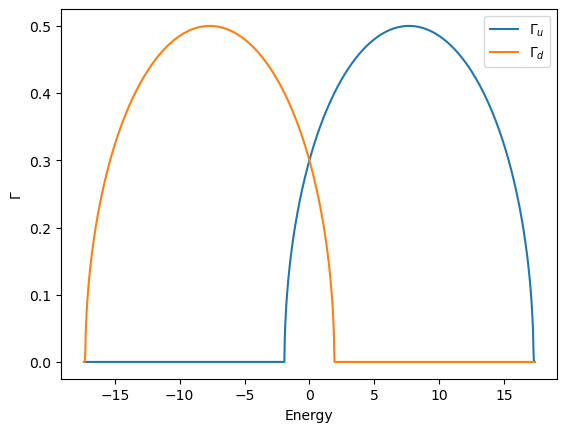

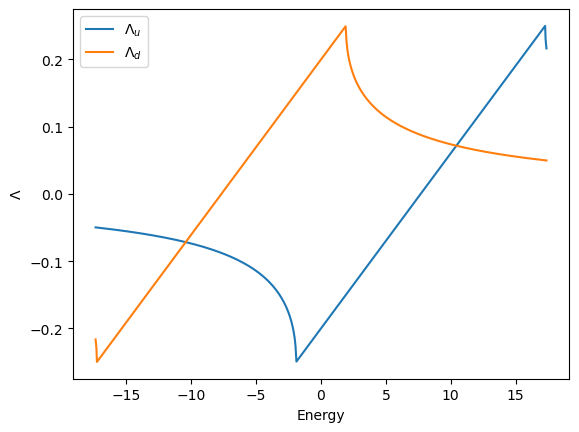

In [23]:
negf_method.plot_selfenergies(energies_self,epsilon0L,tleadL,tcoupL,pz)

## Not magnetized

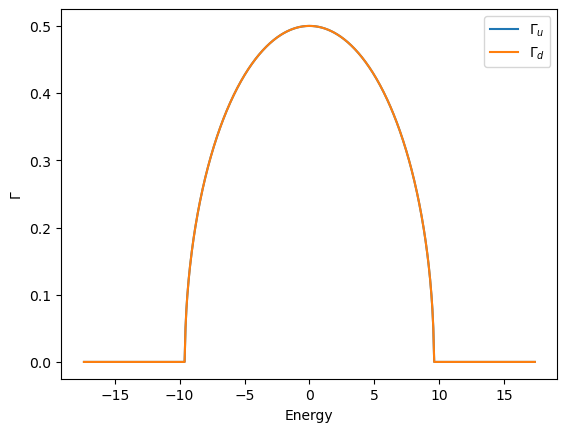

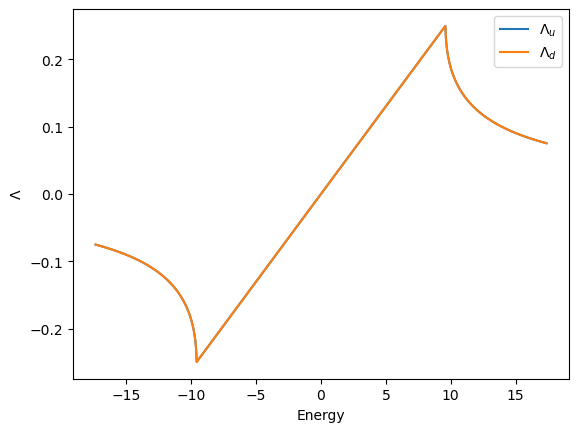

In [24]:
negf_method.plot_selfenergies(energies_self,epsilon0R,tleadR,tcoupR,0)

### Bias window

In [26]:
Vmax = 1 # Maximum bias voltage [eV]
dV = 0.5 # stepsize
V_list_pos_bias,V_list_total = hfc.func_V_total(Vmax,dV)
print(len(V_list_total),V_list_pos_bias)

5 [0.5 1. ]


#### Integration & Self-consistency parameters

In [19]:
tol            = 10**-3  # tolerance of for converence of electron densities
tol_nintegrand = 10**-15 # cut-off value that much be satisfied for lower,upper bound Glesser integral.

max_iteration  = 50     # max number of iterations
npoints        = 10000  # max number of points to integrate over
alpha          = 0.6    # linear mixing paramter
npoints_current = 10000 # npoints to calculate the current with

# 3. Electron Densities

Note: Hubbard One converges well for large U 

tleadL, tleadR = 9.6,9.6 & tcoupLR = 1.5491933384829668,1.5491933384829668
0.0 0.0
--- ef = 0, tsom/t = 0.1 , U/t = 0.5,
--- V = 0 ---
[0.007 0.007 0.008 0.008 0.002 0.002 0.002 0.002 0.    0.    0.005 0.005
 0.003 0.003 0.001 0.001 0.002 0.002 0.003 0.003]
[0.005 0.005 0.005 0.005 0.    0.    0.001 0.001 0.    0.    0.003 0.003
 0.002 0.002 0.    0.    0.002 0.002 0.002 0.002]
[0.003 0.003 0.004 0.004 0.    0.    0.    0.    0.    0.    0.002 0.002
 0.001 0.001 0.    0.    0.001 0.001 0.001 0.001]
[0.002 0.002 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.001 0.001 0.002 0.002 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


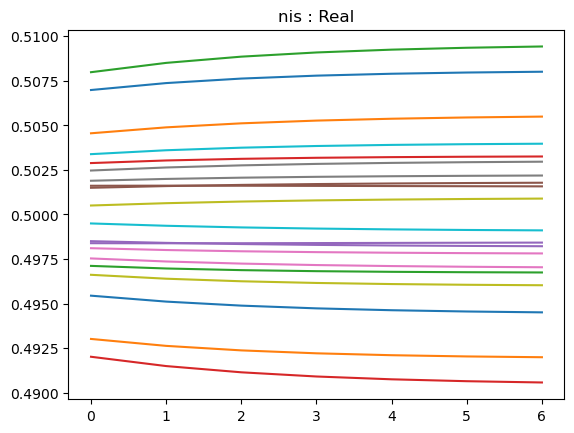

--- V = 0.1 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


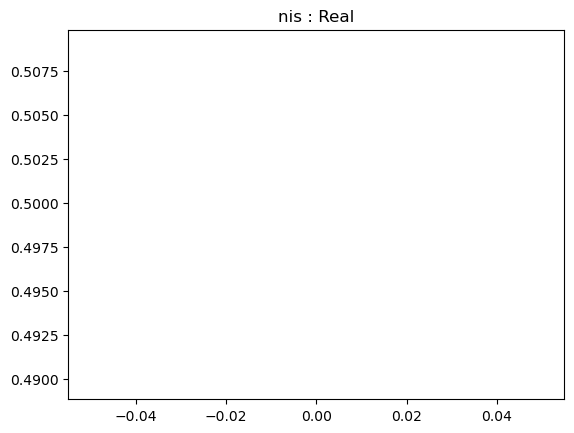

--- V = 0.2 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


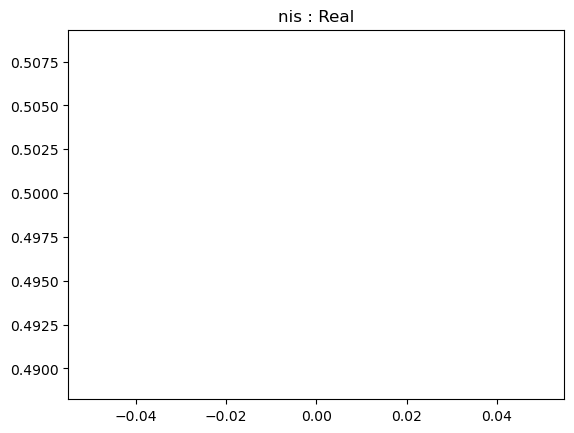

--- V = 0.30000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


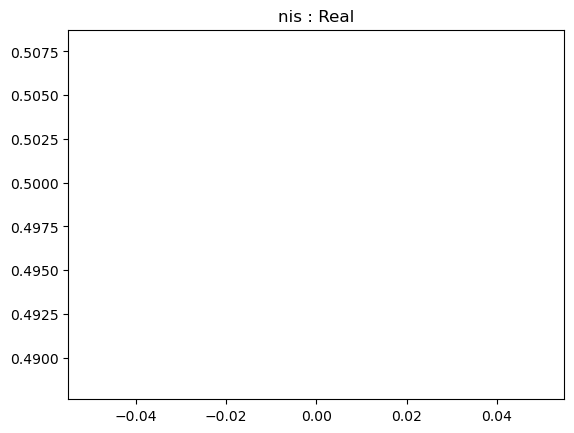

--- V = 0.4 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


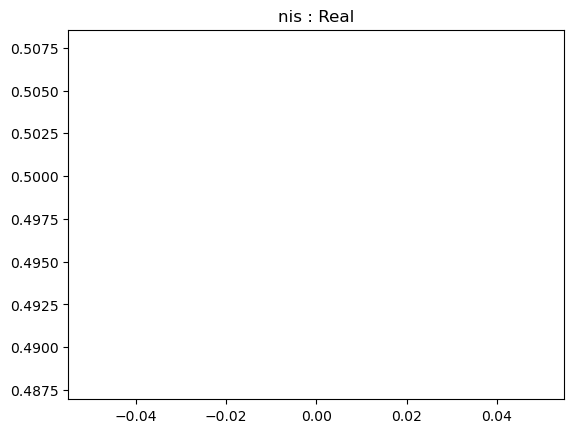

--- V = 0.5 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


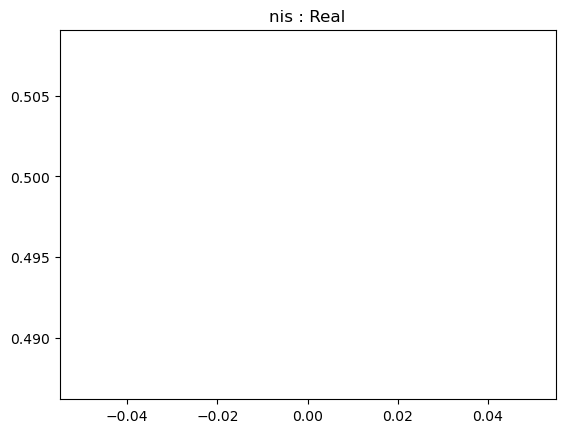

--- V = 0.6 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


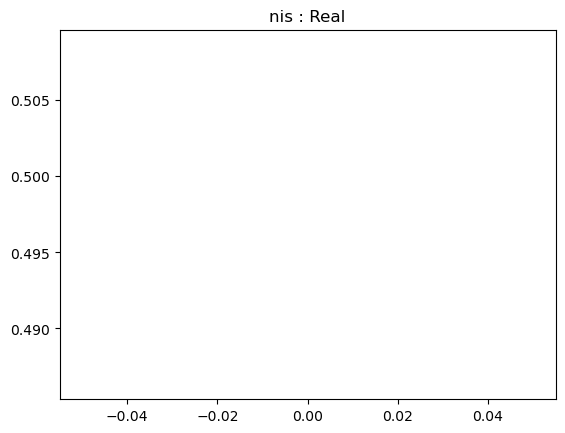

--- V = 0.7000000000000001 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


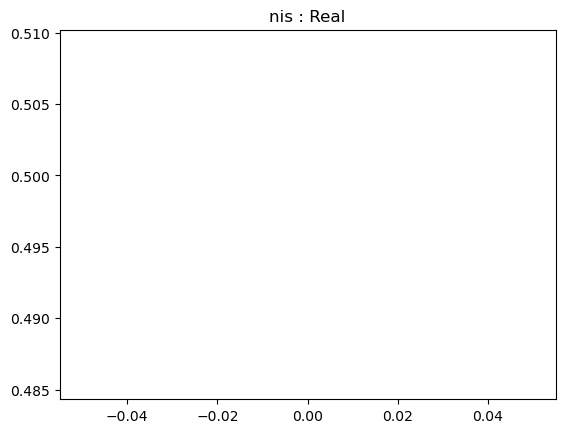

--- V = 0.8 ---
[0.    0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


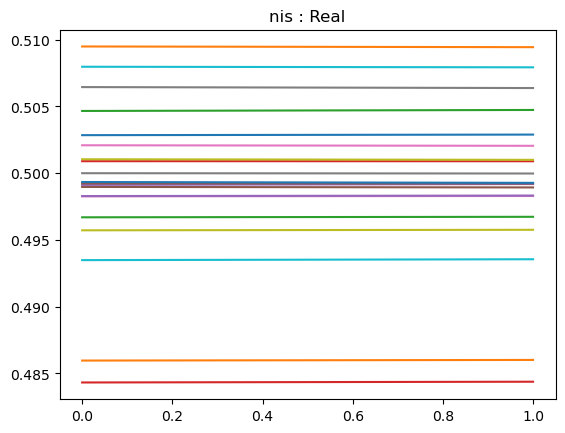

--- V = 0.9 ---
[0.    0.001 0.    0.002 0.    0.001 0.    0.001 0.    0.001 0.001 0.
 0.    0.001 0.    0.002 0.001 0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


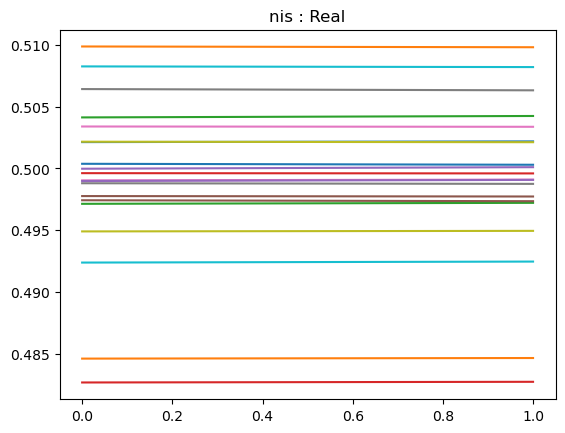

--- V = 1.0 ---
[0.    0.002 0.    0.002 0.002 0.003 0.001 0.002 0.    0.001 0.001 0.
 0.    0.002 0.001 0.003 0.002 0.    0.002 0.   ]
[0.    0.001 0.    0.001 0.001 0.002 0.001 0.001 0.    0.    0.    0.
 0.    0.001 0.001 0.002 0.001 0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


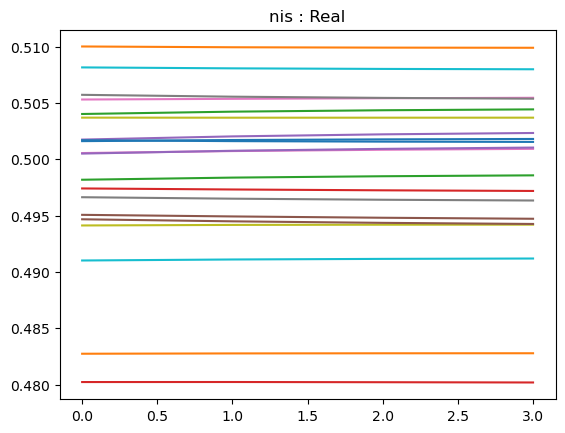

--- V = 1.1 ---
[0.    0.003 0.    0.004 0.003 0.004 0.002 0.004 0.    0.002 0.002 0.
 0.002 0.003 0.002 0.004 0.003 0.002 0.002 0.   ]
[0.    0.002 0.    0.002 0.002 0.003 0.002 0.002 0.    0.001 0.001 0.
 0.001 0.002 0.002 0.003 0.002 0.001 0.001 0.   ]
[0.    0.001 0.    0.002 0.002 0.002 0.001 0.002 0.    0.    0.    0.
 0.001 0.002 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.    0.001 0.001 0.002 0.001 0.001 0.    0.    0.    0.
 0.    0.001 0.001 0.002 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


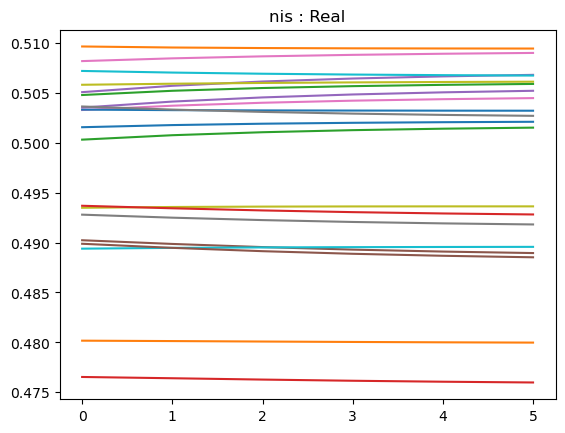

--- V = 1.2000000000000002 ---
[0.    0.003 0.    0.004 0.003 0.005 0.002 0.004 0.    0.002 0.002 0.
 0.002 0.004 0.003 0.005 0.003 0.003 0.002 0.002]
[0.    0.002 0.    0.003 0.003 0.004 0.002 0.003 0.    0.    0.001 0.
 0.002 0.003 0.002 0.004 0.002 0.002 0.001 0.001]
[0.    0.001 0.001 0.002 0.002 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.002 0.003 0.002 0.002 0.001 0.   ]
[0.    0.    0.    0.001 0.002 0.002 0.001 0.002 0.    0.    0.    0.
 0.001 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.001 0.002 0.001 0.001 0.    0.    0.    0.
 0.    0.001 0.001 0.002 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


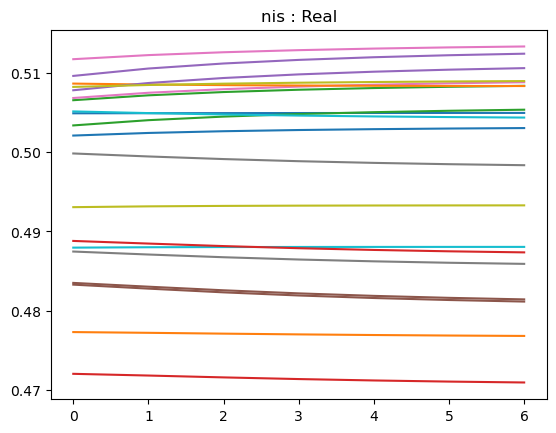

--- V = 1.3000000000000003 ---
[0.001 0.    0.001 0.001 0.    0.002 0.    0.002 0.    0.    0.    0.
 0.    0.001 0.    0.002 0.    0.002 0.    0.001]
[0.    0.    0.    0.    0.    0.001 0.    0.001 0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.001 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


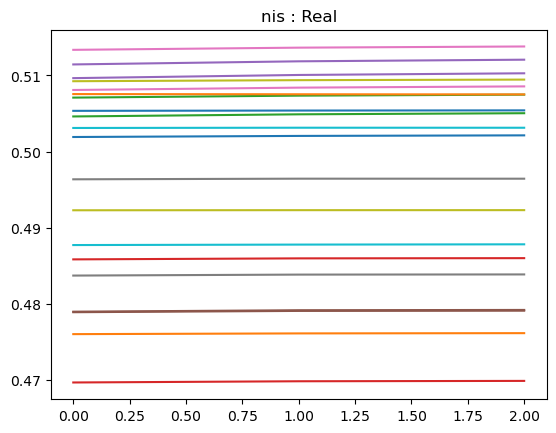

--- V = 1.4000000000000001 ---
[0.003 0.002 0.004 0.003 0.006 0.002 0.004 0.001 0.001 0.001 0.001 0.
 0.004 0.002 0.005 0.002 0.003 0.    0.002 0.   ]
[0.002 0.001 0.003 0.002 0.004 0.002 0.003 0.001 0.    0.    0.    0.
 0.003 0.002 0.003 0.002 0.002 0.    0.001 0.   ]
[0.001 0.    0.002 0.002 0.002 0.002 0.002 0.001 0.    0.    0.    0.
 0.002 0.001 0.002 0.002 0.001 0.    0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.001 0.001 0.    0.    0.    0.    0.
 0.001 0.001 0.002 0.001 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


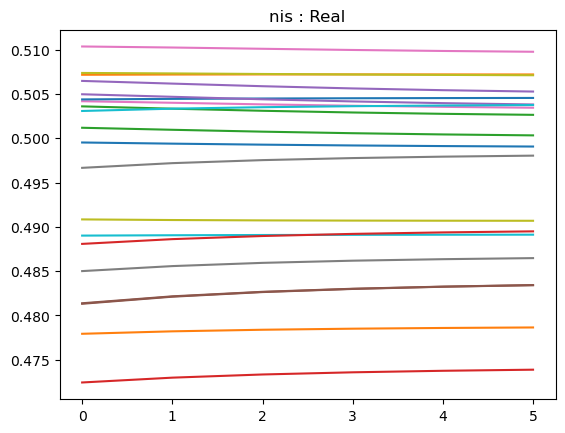

--- V = 1.5000000000000002 ---
[0.002 0.002 0.004 0.003 0.006 0.003 0.005 0.001 0.001 0.001 0.001 0.
 0.004 0.003 0.006 0.003 0.004 0.    0.003 0.   ]
[0.002 0.001 0.003 0.002 0.004 0.002 0.003 0.001 0.    0.    0.    0.
 0.003 0.002 0.004 0.002 0.003 0.    0.002 0.   ]
[0.001 0.001 0.002 0.002 0.003 0.002 0.002 0.001 0.    0.    0.    0.
 0.002 0.001 0.002 0.002 0.002 0.    0.001 0.   ]
[0.    0.    0.001 0.001 0.002 0.001 0.001 0.    0.    0.    0.    0.
 0.001 0.    0.002 0.001 0.001 0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


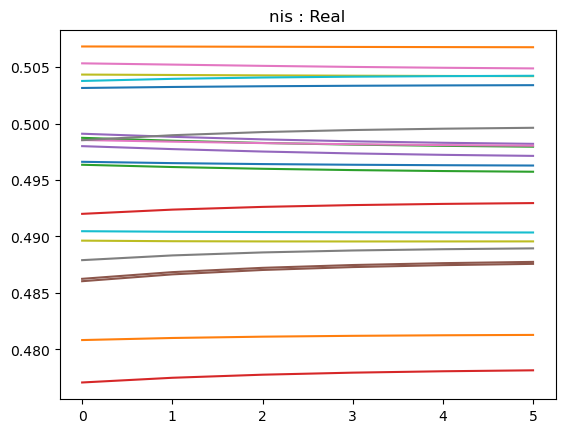

--- V = 1.6 ---
[0.001 0.001 0.002 0.002 0.004 0.001 0.003 0.    0.    0.    0.001 0.
 0.002 0.001 0.004 0.001 0.003 0.    0.002 0.   ]
[0.    0.    0.001 0.001 0.002 0.    0.002 0.    0.    0.    0.    0.
 0.001 0.    0.002 0.001 0.002 0.    0.001 0.   ]
[0.    0.    0.    0.    0.002 0.    0.001 0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.001 0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


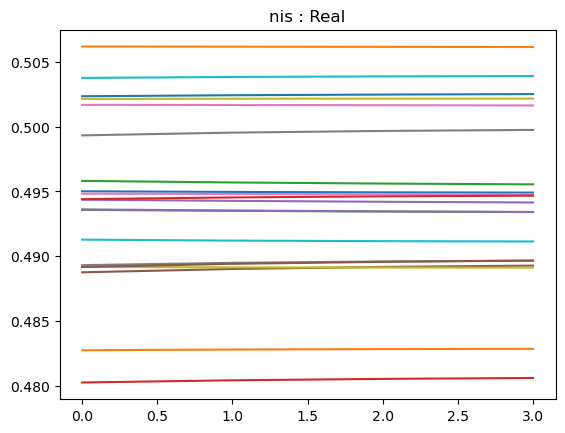

--- V = 1.7000000000000002 ---
[0.    0.    0.    0.001 0.002 0.    0.002 0.    0.    0.    0.    0.
 0.    0.    0.002 0.    0.002 0.    0.001 0.   ]
[0.    0.    0.    0.    0.001 0.    0.001 0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.001 0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


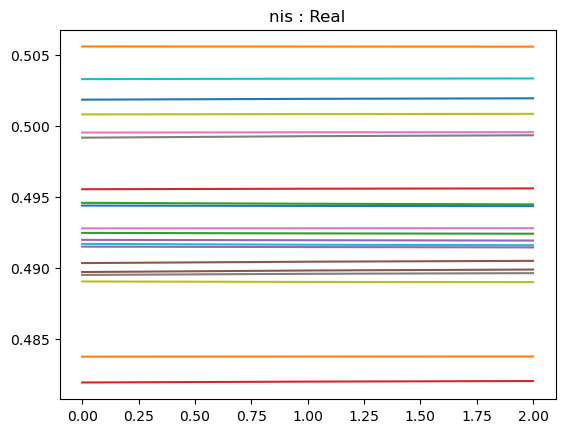

--- V = 1.8000000000000003 ---
[0.    0.    0.    0.    0.001 0.    0.001 0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.001 0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


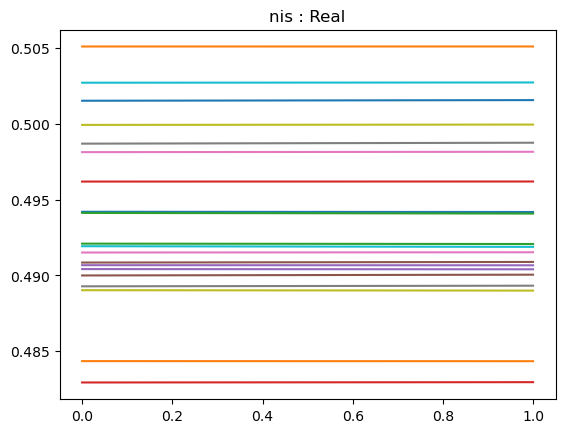

--- V = 1.9000000000000001 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


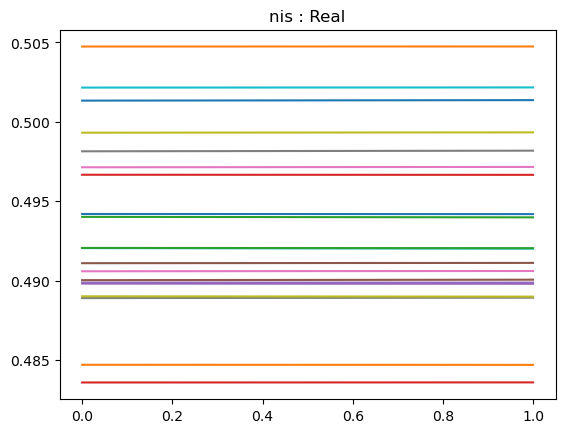

--- V = 2.0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


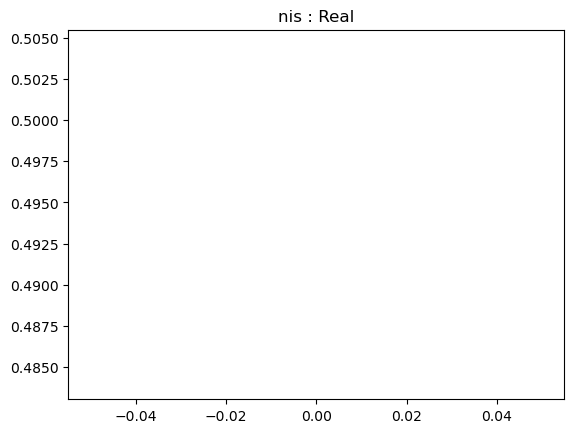

--- V = 2.1 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


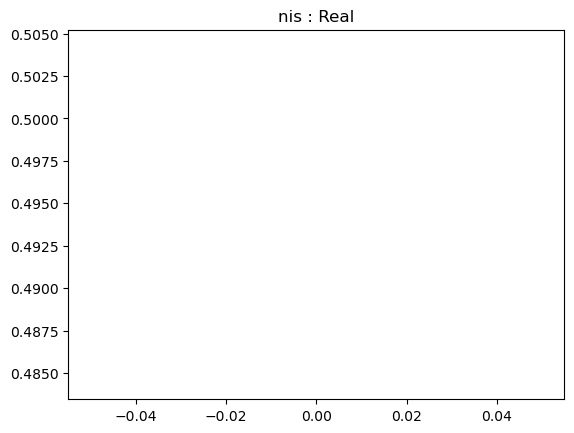

--- V = 2.2 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


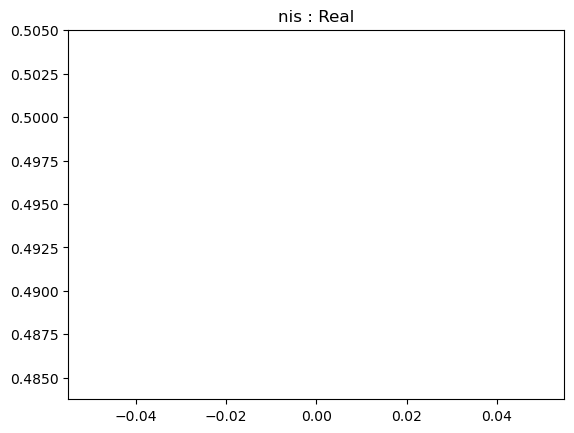

--- V = 2.3000000000000003 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


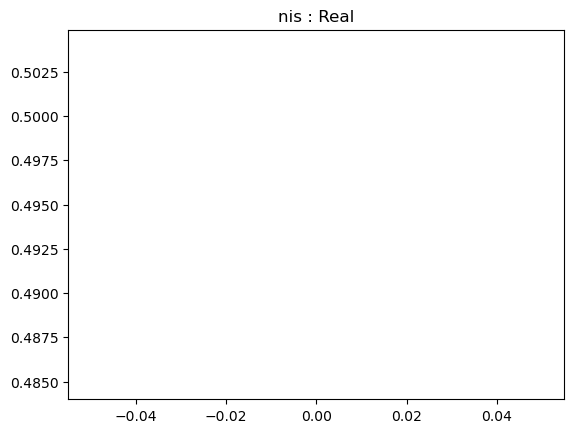

--- V = 2.4000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


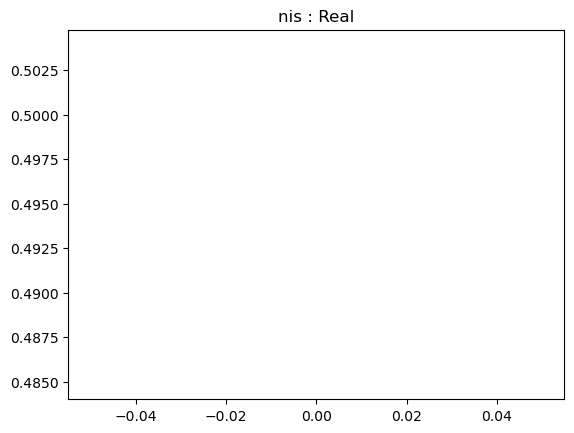

--- V = 2.5000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


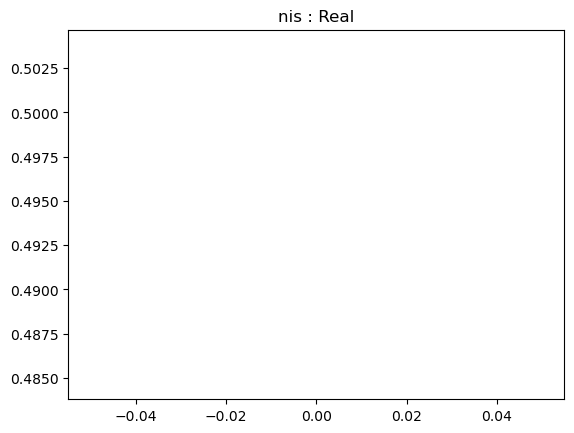

--- V = 2.6 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


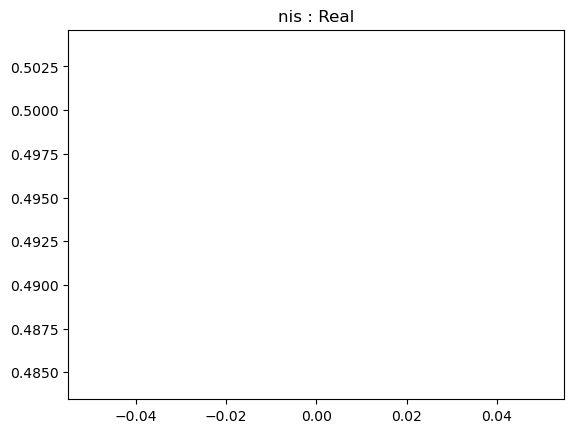

--- V = 2.7 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


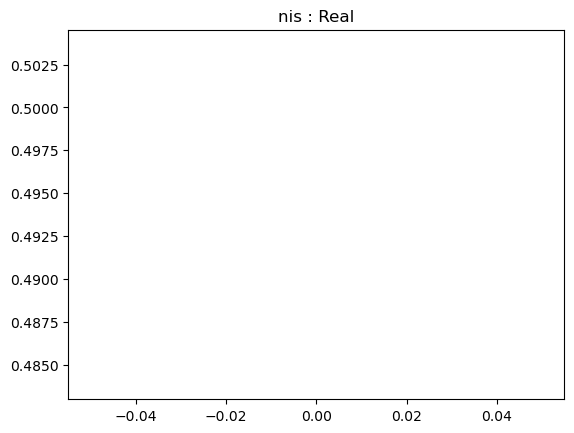

--- V = 2.8000000000000003 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


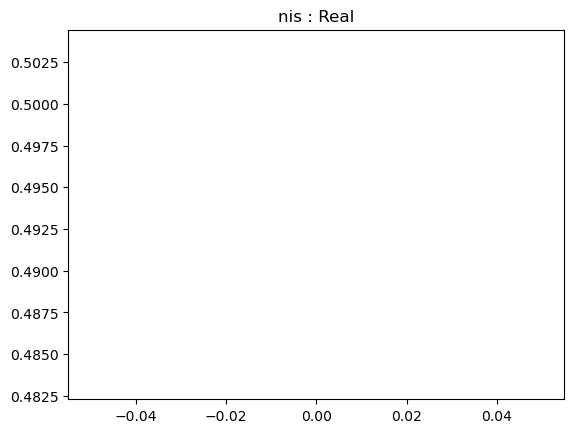

--- V = 2.9000000000000004 ---
[0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


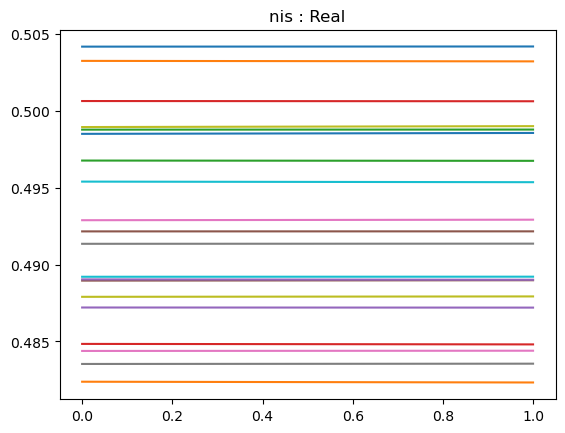

--- V = 3.0000000000000004 ---
[0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.    0.001 0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


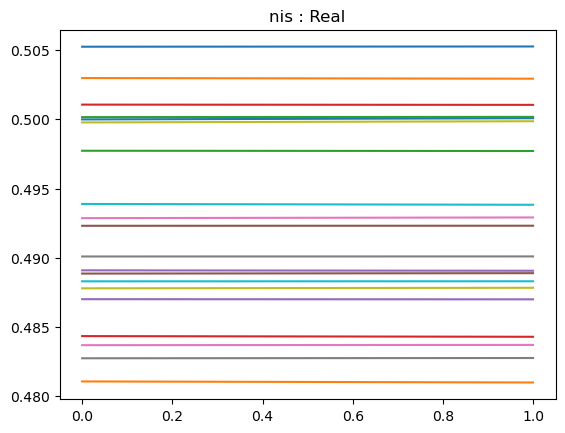

--- V = 3.1 ---
[0.002 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.
 0.001 0.    0.    0.    0.    0.002 0.001 0.002]
[0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


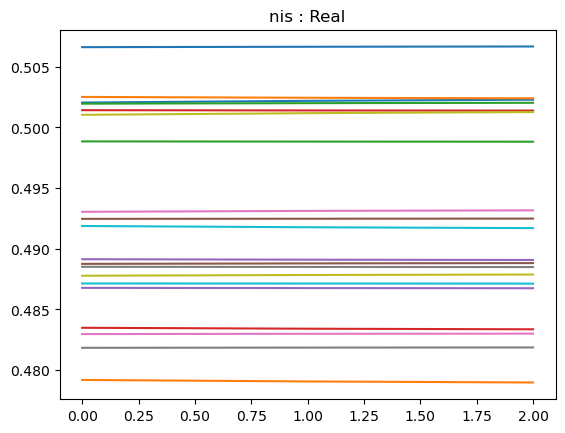

--- V = 3.2 ---
[0.003 0.002 0.002 0.001 0.    0.    0.    0.001 0.    0.001 0.002 0.
 0.001 0.    0.    0.    0.    0.002 0.002 0.003]
[0.002 0.002 0.001 0.    0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.    0.001 0.001 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


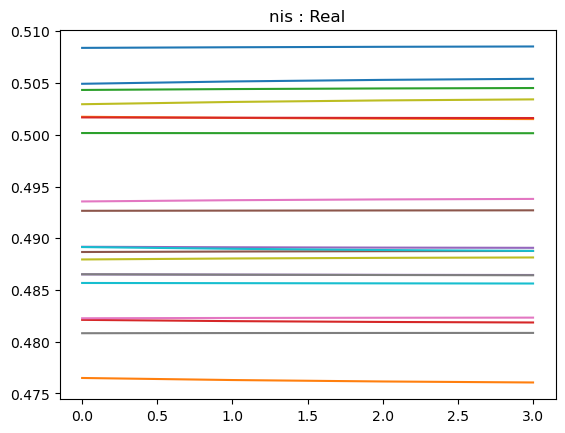

--- V = 3.3000000000000003 ---
[0.003 0.003 0.003 0.002 0.    0.    0.    0.001 0.    0.002 0.002 0.001
 0.002 0.    0.    0.    0.    0.002 0.002 0.003]
[0.002 0.002 0.002 0.001 0.    0.    0.    0.    0.    0.001 0.001 0.
 0.    0.    0.    0.    0.    0.002 0.002 0.002]
[0.002 0.002 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


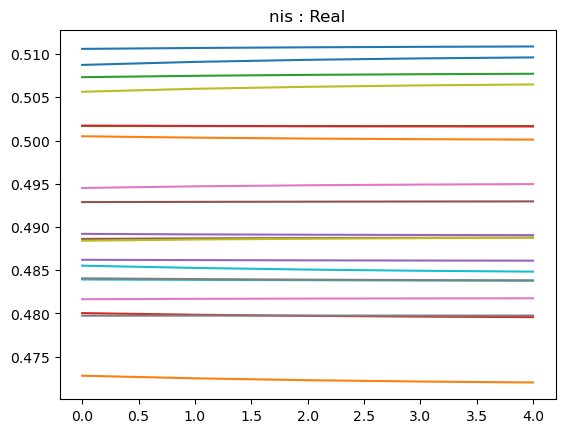

--- V = 3.4000000000000004 ---
[0.004 0.004 0.003 0.002 0.    0.    0.    0.001 0.    0.002 0.002 0.001
 0.002 0.    0.    0.    0.    0.003 0.002 0.004]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.    0.001 0.001 0.001
 0.    0.    0.    0.    0.    0.002 0.002 0.003]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.001 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


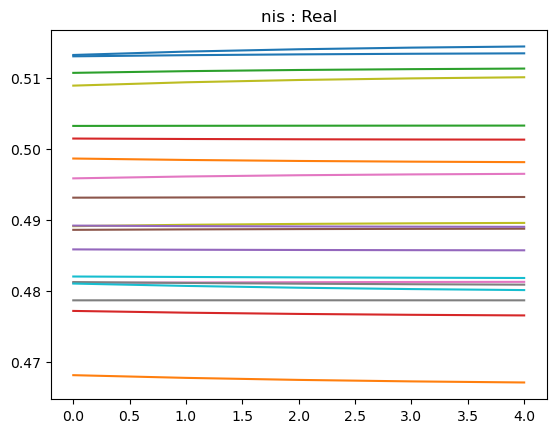

--- V = 3.5000000000000004 ---
[0.003 0.004 0.002 0.003 0.    0.    0.    0.    0.    0.001 0.002 0.002
 0.001 0.    0.    0.    0.    0.002 0.002 0.004]
[0.002 0.003 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.    0.001 0.002 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


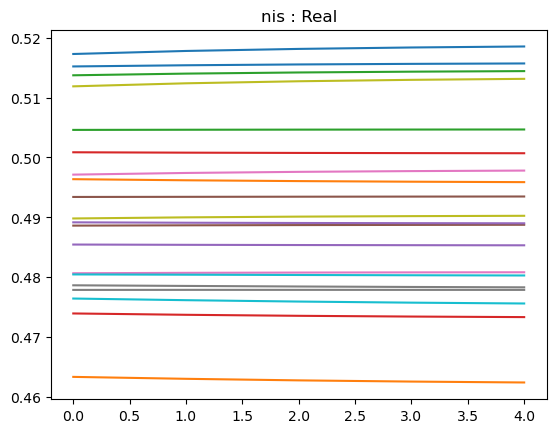

--- V = 3.6 ---
[0.    0.002 0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.002
 0.    0.    0.    0.    0.    0.001 0.    0.002]
[0.    0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


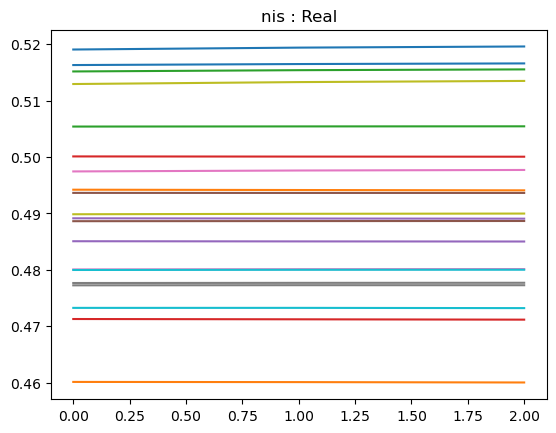

--- V = 3.7 ---
[0.003 0.    0.001 0.001 0.    0.    0.    0.    0.001 0.001 0.    0.001
 0.    0.    0.    0.    0.002 0.    0.003 0.   ]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.002 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


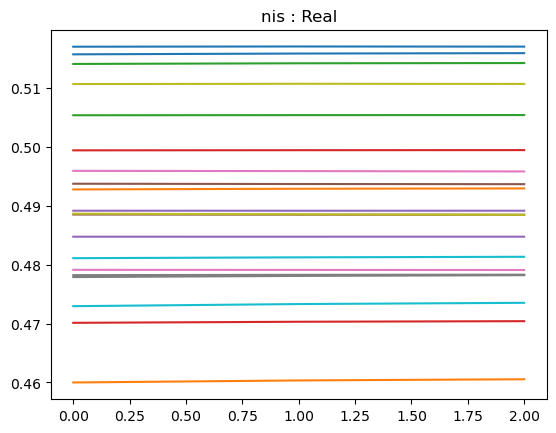

--- V = 3.8000000000000003 ---
[0.005 0.002 0.003 0.    0.    0.    0.001 0.001 0.002 0.002 0.002 0.
 0.    0.    0.    0.    0.003 0.002 0.005 0.002]
[0.003 0.002 0.002 0.    0.    0.    0.    0.    0.001 0.002 0.001 0.
 0.    0.    0.    0.    0.002 0.002 0.003 0.002]
[0.002 0.001 0.001 0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.001]
[0.002 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


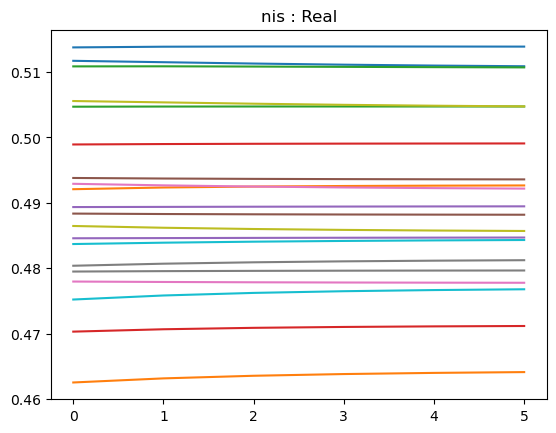

--- V = 3.9000000000000004 ---
[0.006 0.002 0.004 0.    0.    0.    0.    0.001 0.002 0.003 0.003 0.001
 0.001 0.    0.    0.    0.003 0.003 0.006 0.002]
[0.004 0.002 0.003 0.    0.    0.    0.    0.    0.001 0.002 0.002 0.
 0.    0.    0.    0.    0.002 0.002 0.004 0.002]
[0.003 0.002 0.002 0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.001]
[0.002 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.001]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


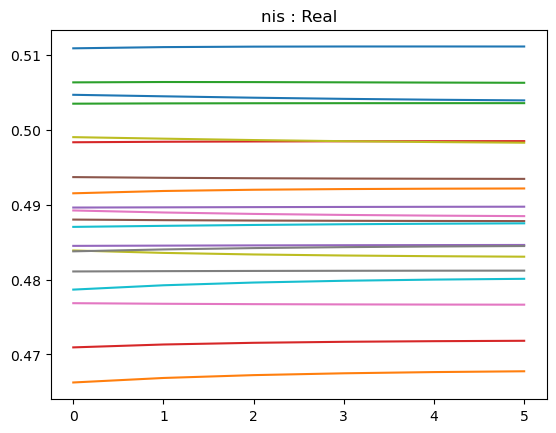

--- V = 4.0 ---
[0.005 0.002 0.004 0.    0.    0.    0.    0.001 0.001 0.003 0.003 0.002
 0.001 0.    0.    0.    0.002 0.002 0.005 0.001]
[0.003 0.001 0.002 0.    0.    0.    0.    0.    0.    0.002 0.002 0.
 0.    0.    0.    0.    0.002 0.002 0.003 0.001]
[0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.001]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


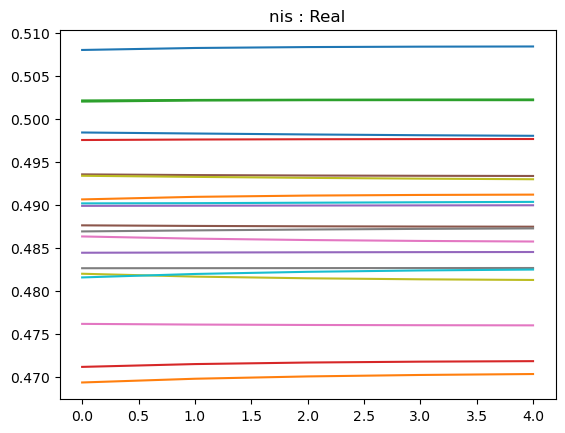

--- V = 4.1 ---
[0.004 0.    0.004 0.001 0.    0.    0.    0.001 0.    0.002 0.003 0.002
 0.001 0.001 0.    0.    0.001 0.002 0.004 0.   ]
[0.003 0.    0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.
 0.    0.    0.    0.    0.    0.001 0.002 0.   ]
[0.002 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


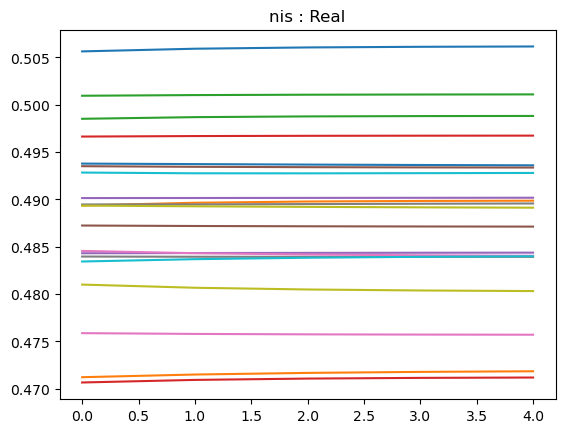

--- V = 4.2 ---
[0.003 0.    0.003 0.001 0.    0.    0.    0.001 0.    0.002 0.003 0.002
 0.001 0.001 0.    0.    0.    0.002 0.003 0.   ]
[0.002 0.    0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.
 0.    0.    0.    0.    0.    0.001 0.002 0.   ]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


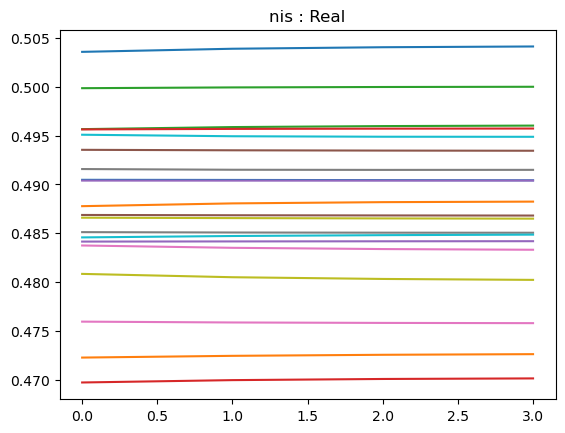

--- V = 4.3 ---
[0.002 0.    0.003 0.002 0.    0.    0.    0.001 0.001 0.002 0.002 0.002
 0.001 0.001 0.    0.    0.    0.002 0.002 0.   ]
[0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.001 0.001 0.001
 0.    0.    0.    0.    0.    0.001 0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


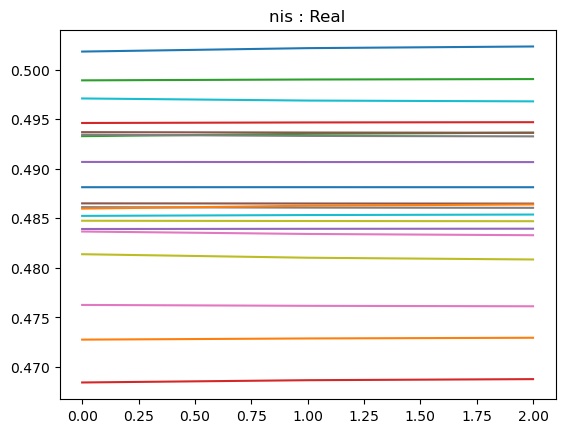

--- V = 4.3999999999999995 ---
[0.002 0.    0.002 0.002 0.    0.    0.    0.    0.002 0.002 0.002 0.002
 0.    0.001 0.    0.    0.    0.002 0.001 0.   ]
[0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.001 0.    0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


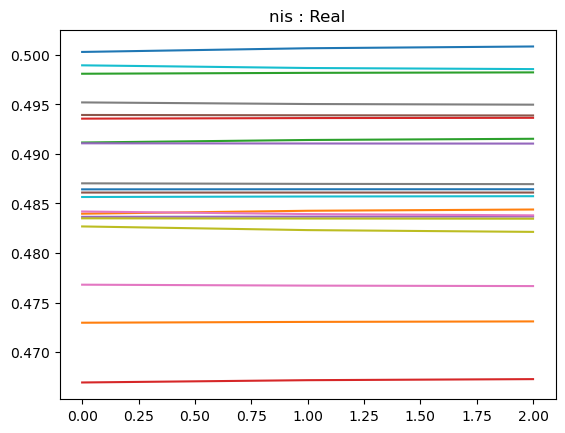

--- V = 4.5 ---
[0.001 0.    0.002 0.002 0.    0.    0.001 0.    0.003 0.002 0.002 0.003
 0.    0.001 0.    0.    0.002 0.002 0.    0.   ]
[0.    0.    0.001 0.001 0.    0.    0.    0.    0.001 0.    0.    0.001
 0.    0.    0.    0.    0.    0.001 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


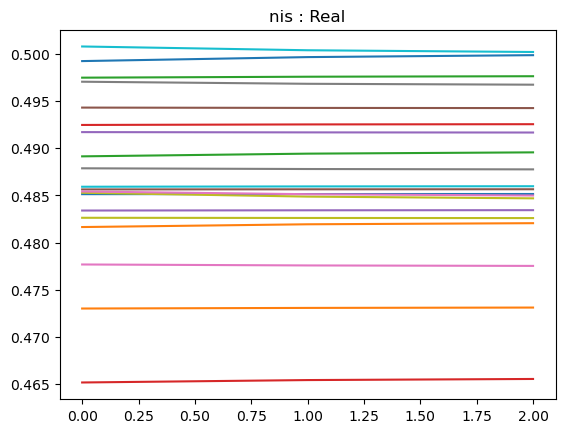

--- V = 4.6 ---
[0.001 0.    0.002 0.002 0.    0.    0.002 0.    0.006 0.002 0.    0.003
 0.    0.001 0.001 0.    0.003 0.002 0.    0.   ]
[0.    0.    0.001 0.001 0.    0.    0.    0.    0.003 0.    0.    0.002
 0.    0.    0.    0.    0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.    0.    0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


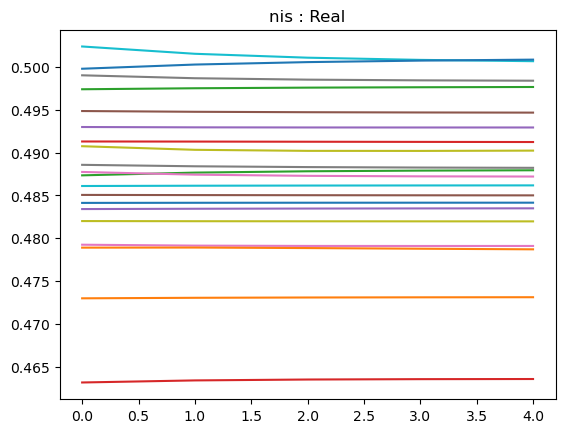

--- V = 4.7 ---
[0.    0.    0.002 0.003 0.    0.    0.003 0.    0.012 0.    0.004 0.004
 0.001 0.002 0.003 0.    0.005 0.002 0.    0.   ]
[0.    0.    0.    0.002 0.    0.    0.002 0.    0.007 0.003 0.003 0.005
 0.    0.001 0.002 0.    0.003 0.    0.    0.   ]
[0.    0.    0.    0.001 0.    0.    0.001 0.    0.005 0.004 0.003 0.004
 0.    0.001 0.001 0.    0.002 0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.001 0.    0.004 0.004 0.003 0.004
 0.    0.    0.    0.    0.001 0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.003 0.003 0.003
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.003 0.003 0.003
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.003 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]


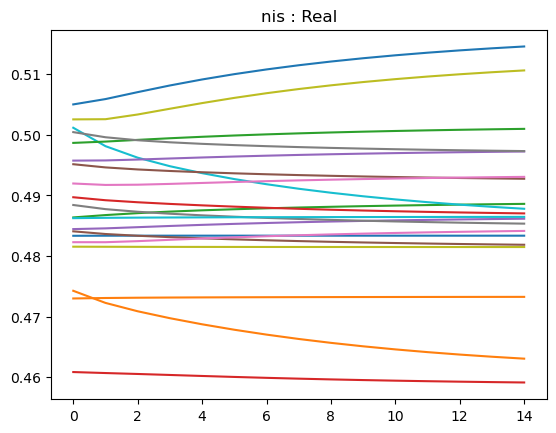

--- V = 4.8 ---
[0.    0.    0.    0.004 0.003 0.003 0.004 0.003 0.017 0.013 0.011 0.013
 0.003 0.003 0.004 0.003 0.006 0.002 0.    0.   ]
[0.    0.    0.001 0.003 0.003 0.004 0.004 0.004 0.015 0.015 0.011 0.014
 0.003 0.004 0.004 0.003 0.004 0.003 0.    0.   ]
[0.    0.    0.002 0.003 0.003 0.004 0.003 0.004 0.014 0.016 0.012 0.015
 0.003 0.004 0.003 0.004 0.003 0.004 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.004 0.003 0.004 0.014 0.016 0.013 0.015
 0.003 0.004 0.003 0.004 0.003 0.004 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.004 0.003 0.004 0.013 0.016 0.013 0.015
 0.003 0.003 0.003 0.004 0.003 0.004 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.003 0.004 0.012 0.016 0.013 0.015
 0.003 0.003 0.003 0.004 0.002 0.004 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.003 0.004 0.012 0.015 0.012 0.014
 0.003 0.003 0.003 0.004 0.002 0.004 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.002 0.003 0.011 0.014 0.012 0.013
 0.003 0.003 0.002 0.003 0.002 0.003 0.    0.   ]


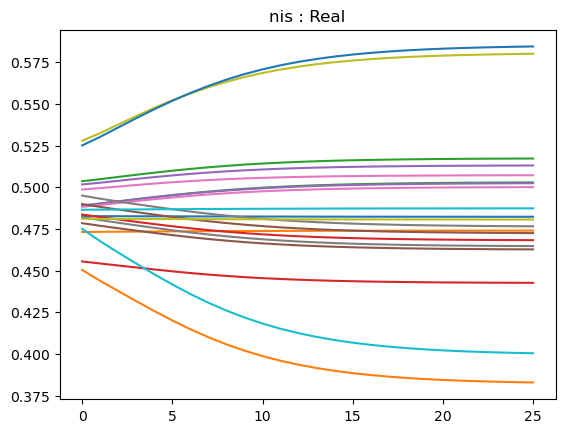

--- V = 4.9 ---
[0.    0.    0.002 0.002 0.    0.    0.001 0.    0.004 0.001 0.006 0.006
 0.002 0.002 0.    0.001 0.    0.    0.    0.   ]
[0.    0.    0.002 0.001 0.    0.    0.    0.    0.003 0.003 0.004 0.005
 0.001 0.001 0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.001 0.001 0.    0.    0.    0.    0.002 0.003 0.003 0.004
 0.001 0.001 0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.003 0.003
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.002 0.002 0.003
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.002 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.002 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]


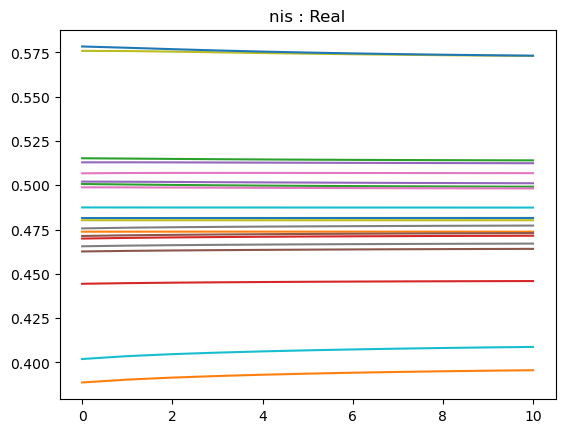

--- V = 5.0 ---
[0.    0.    0.008 0.009 0.007 0.007 0.007 0.006 0.029 0.026 0.031 0.033
 0.008 0.008 0.006 0.006 0.006 0.004 0.    0.   ]
[0.    0.    0.007 0.007 0.006 0.007 0.006 0.006 0.025 0.023 0.028 0.028
 0.007 0.007 0.006 0.006 0.005 0.004 0.    0.   ]
[0.    0.    0.006 0.006 0.006 0.006 0.005 0.005 0.022 0.021 0.024 0.024
 0.006 0.005 0.005 0.005 0.004 0.004 0.    0.   ]
[0.    0.    0.005 0.005 0.005 0.005 0.004 0.004 0.019 0.018 0.021 0.02
 0.005 0.004 0.005 0.005 0.004 0.004 0.    0.   ]
[0.    0.    0.005 0.004 0.005 0.004 0.004 0.003 0.017 0.015 0.018 0.017
 0.004 0.004 0.004 0.004 0.003 0.003 0.    0.   ]
[0.    0.    0.004 0.003 0.004 0.004 0.003 0.003 0.014 0.013 0.016 0.014
 0.003 0.003 0.004 0.004 0.003 0.003 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.003 0.002 0.012 0.011 0.013 0.012
 0.003 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0.    0.    0.003 0.002 0.003 0.003 0.002 0.002 0.01  0.009 0.011 0.01
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0

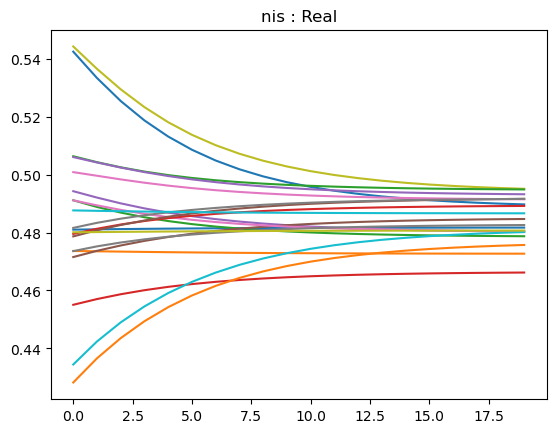

--- V = 5.1 ---
[0.    0.    0.002 0.002 0.003 0.    0.004 0.001 0.016 0.006 0.01  0.001
 0.003 0.    0.005 0.002 0.005 0.003 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.    0.002 0.    0.009 0.002 0.006 0.002
 0.002 0.    0.003 0.    0.003 0.002 0.    0.   ]
[0.    0.    0.    0.001 0.001 0.    0.001 0.    0.005 0.    0.004 0.002
 0.001 0.    0.002 0.    0.002 0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.    0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.    0.002 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


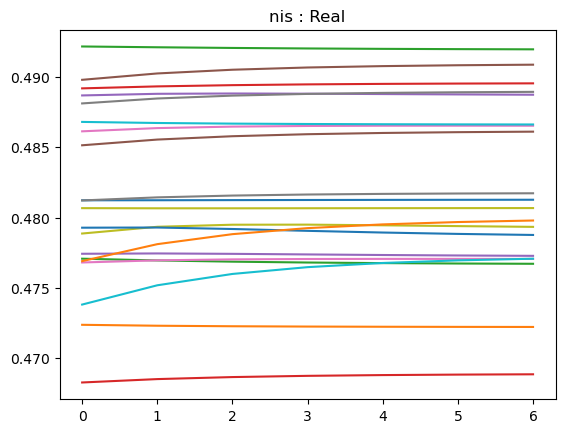

--- V = 5.2 ---
[0.    0.    0.    0.001 0.    0.    0.001 0.    0.007 0.005 0.003 0.
 0.    0.    0.002 0.002 0.003 0.003 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.004 0.003 0.002 0.
 0.    0.    0.001 0.    0.002 0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


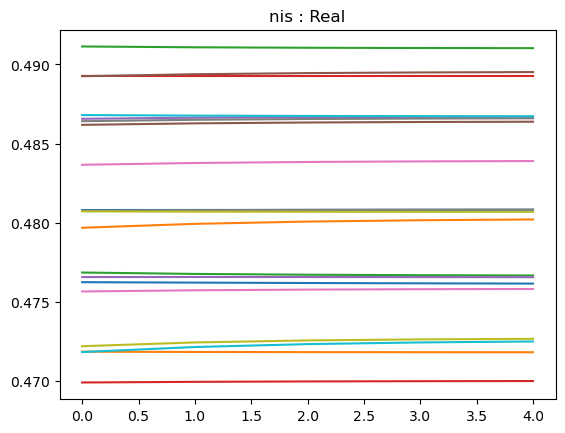

--- V = 5.3 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.004 0.003 0.    0.
 0.    0.    0.001 0.001 0.002 0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


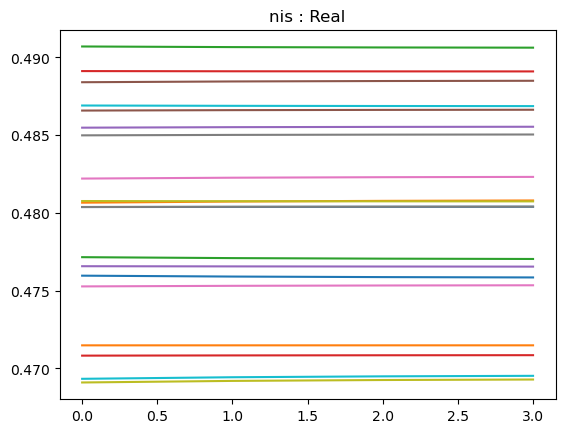

--- V = 5.4 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


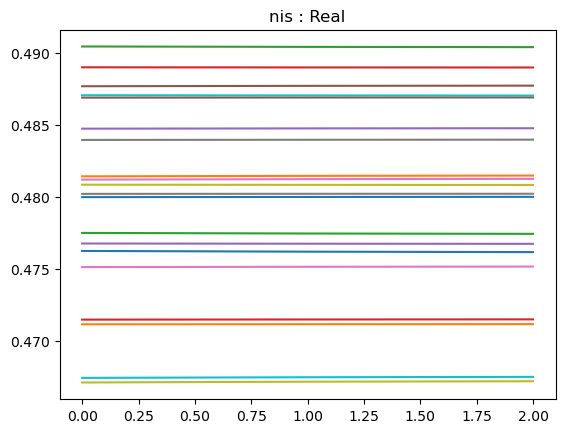

--- V = 5.5 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


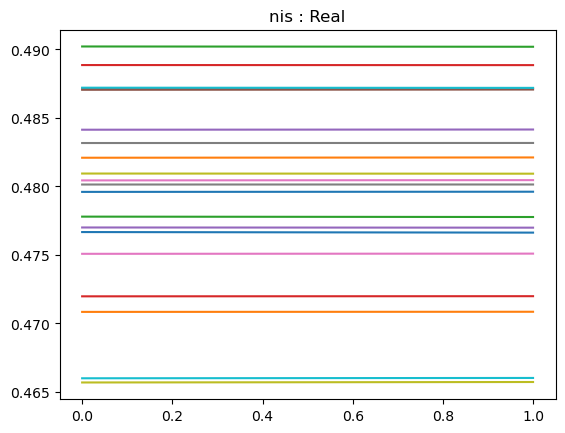

--- V = 5.6 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


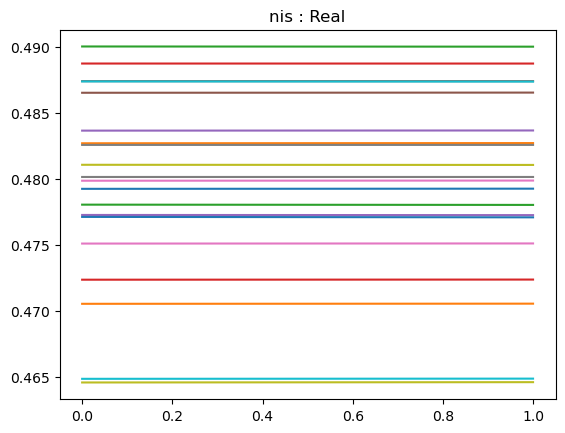

--- V = 5.7 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


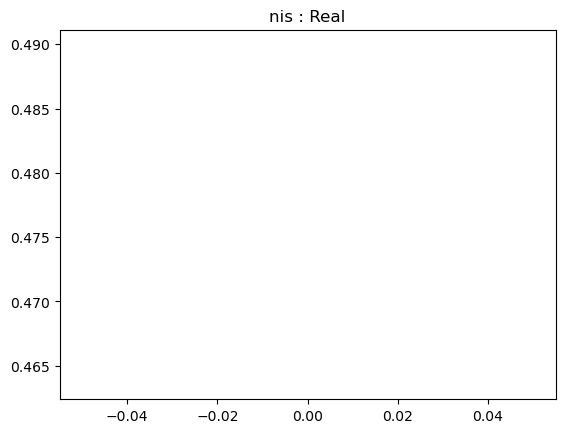

--- V = 5.8 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


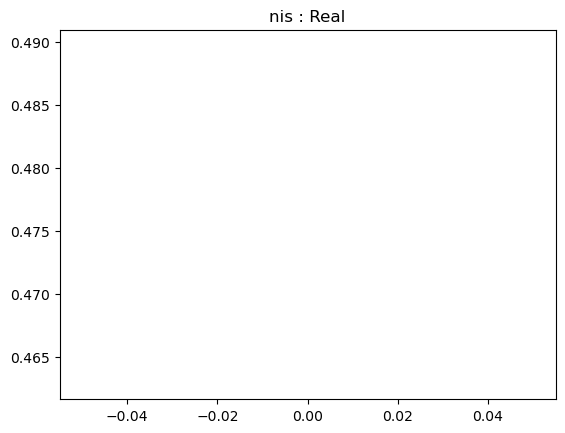

--- V = 5.9 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


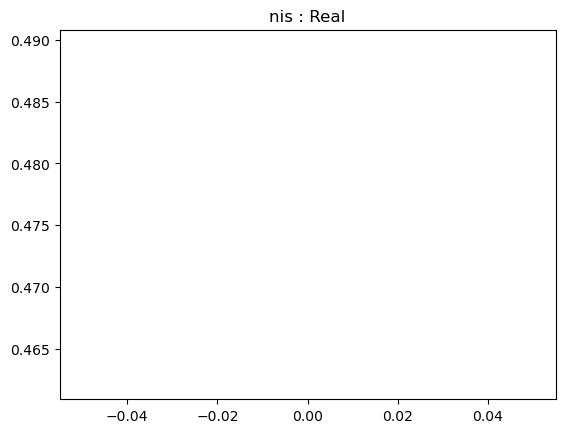

--- V = 6.0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


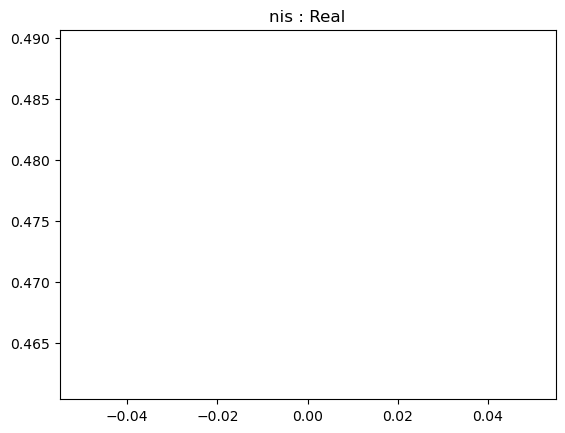

--- V = -0.1 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


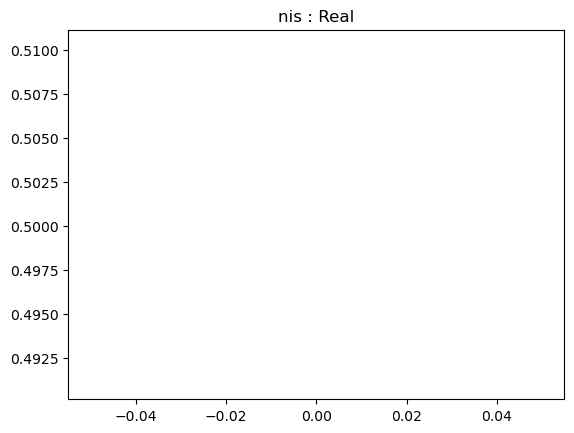

--- V = -0.2 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


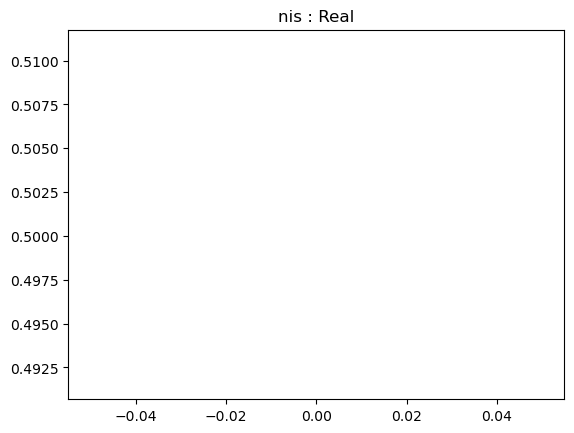

--- V = -0.30000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


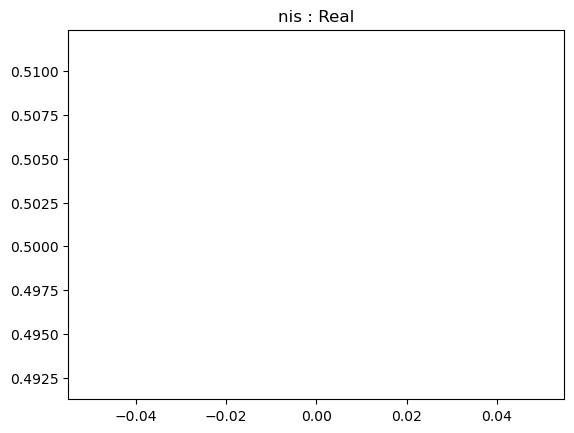

--- V = -0.4 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


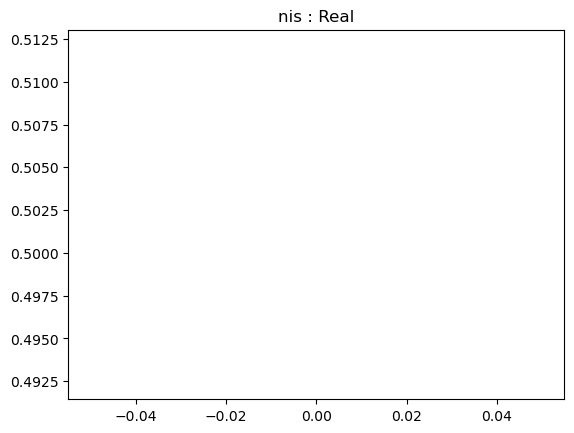

--- V = -0.5 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


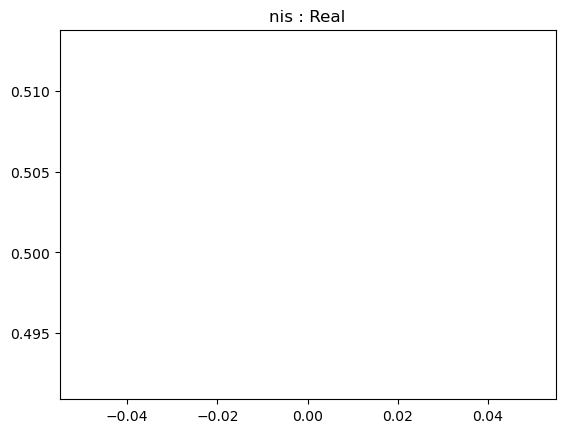

--- V = -0.6 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


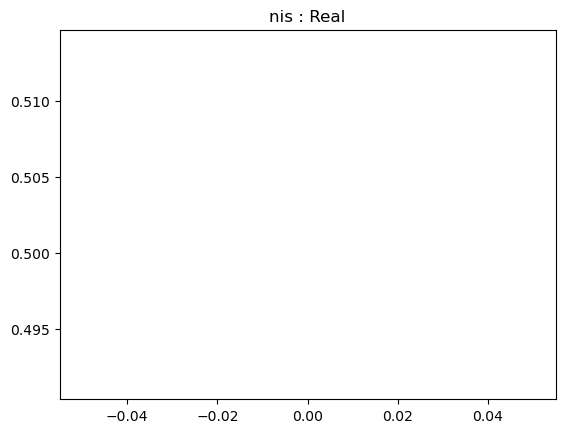

--- V = -0.7000000000000001 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


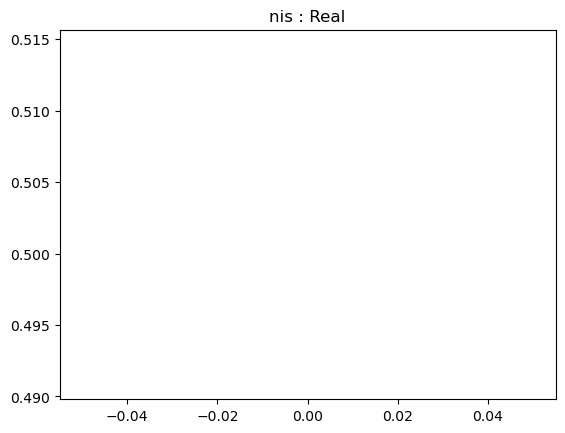

--- V = -0.8 ---
[0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


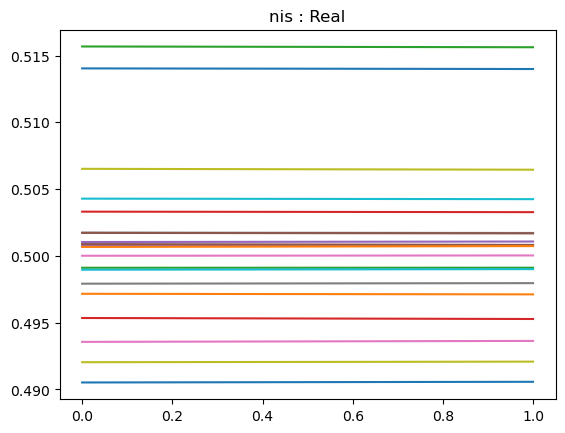

--- V = -0.9 ---
[0.001 0.    0.002 0.    0.001 0.    0.001 0.    0.001 0.    0.    0.001
 0.001 0.    0.002 0.    0.    0.001 0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


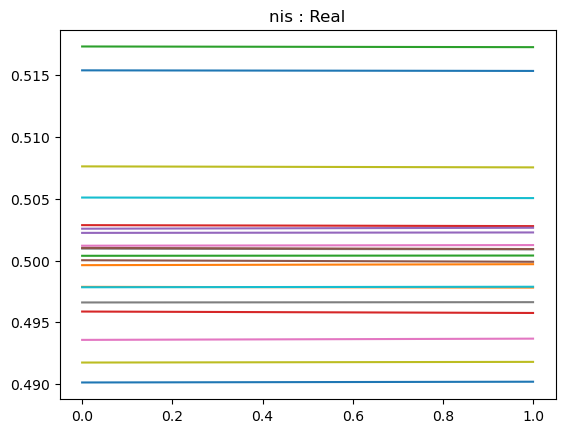

--- V = -1.0 ---
[0.002 0.    0.002 0.    0.003 0.002 0.002 0.001 0.001 0.    0.    0.001
 0.002 0.    0.003 0.001 0.    0.002 0.    0.002]
[0.001 0.    0.001 0.    0.002 0.001 0.001 0.001 0.    0.    0.    0.
 0.001 0.    0.002 0.001 0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


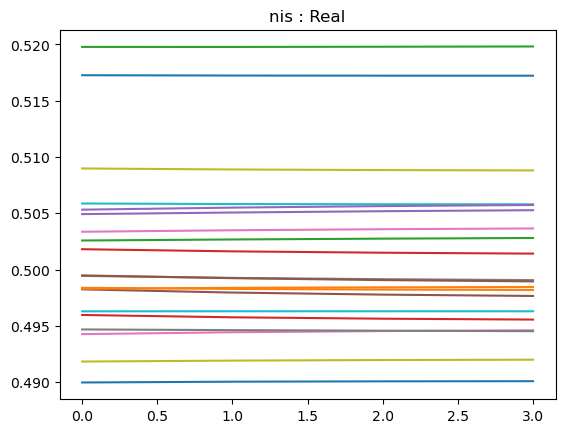

--- V = -1.1 ---
[0.003 0.    0.004 0.    0.004 0.003 0.004 0.002 0.002 0.    0.    0.002
 0.003 0.002 0.004 0.002 0.002 0.003 0.    0.002]
[0.002 0.    0.002 0.    0.003 0.002 0.002 0.002 0.001 0.    0.    0.001
 0.002 0.001 0.003 0.002 0.001 0.002 0.    0.001]
[0.001 0.    0.002 0.    0.002 0.002 0.002 0.001 0.    0.    0.    0.
 0.002 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.    0.002 0.001 0.001 0.001 0.    0.    0.    0.
 0.001 0.    0.002 0.001 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


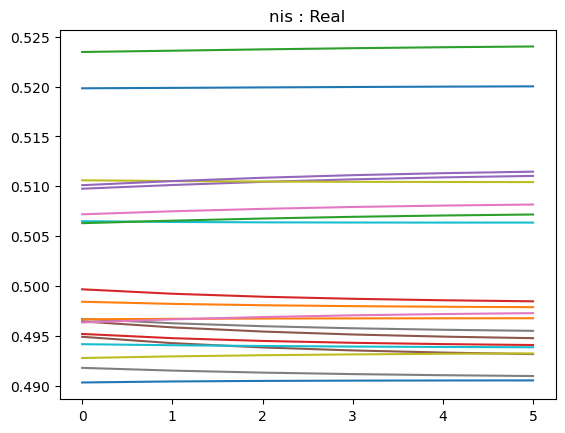

--- V = -1.2000000000000002 ---
[0.003 0.    0.004 0.    0.005 0.003 0.004 0.002 0.002 0.    0.    0.002
 0.004 0.002 0.005 0.003 0.003 0.003 0.002 0.002]
[0.002 0.    0.003 0.    0.004 0.003 0.003 0.002 0.    0.    0.    0.001
 0.003 0.002 0.004 0.002 0.002 0.002 0.001 0.001]
[0.001 0.    0.002 0.001 0.003 0.002 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.002 0.002 0.002 0.    0.001]
[0.    0.    0.001 0.    0.002 0.002 0.002 0.001 0.    0.    0.    0.
 0.001 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.002 0.001 0.001 0.001 0.    0.    0.    0.
 0.001 0.    0.002 0.001 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


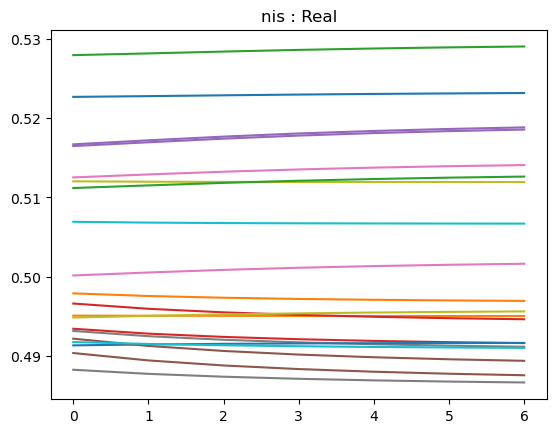

--- V = -1.3000000000000003 ---
[0.    0.001 0.001 0.001 0.002 0.    0.002 0.    0.    0.    0.    0.
 0.001 0.    0.002 0.    0.002 0.    0.001 0.   ]
[0.    0.    0.    0.    0.001 0.    0.001 0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.001 0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


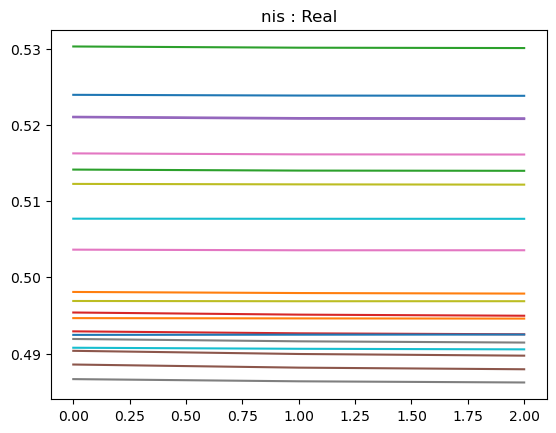

--- V = -1.4000000000000001 ---
[0.002 0.003 0.003 0.004 0.002 0.006 0.001 0.004 0.001 0.001 0.    0.001
 0.002 0.004 0.002 0.005 0.    0.003 0.    0.002]
[0.001 0.002 0.002 0.003 0.002 0.004 0.001 0.003 0.    0.    0.    0.
 0.002 0.003 0.002 0.003 0.    0.002 0.    0.001]
[0.    0.001 0.002 0.002 0.002 0.002 0.001 0.002 0.    0.    0.    0.
 0.001 0.002 0.002 0.002 0.    0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.001 0.002 0.    0.001 0.    0.    0.    0.
 0.001 0.001 0.001 0.002 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


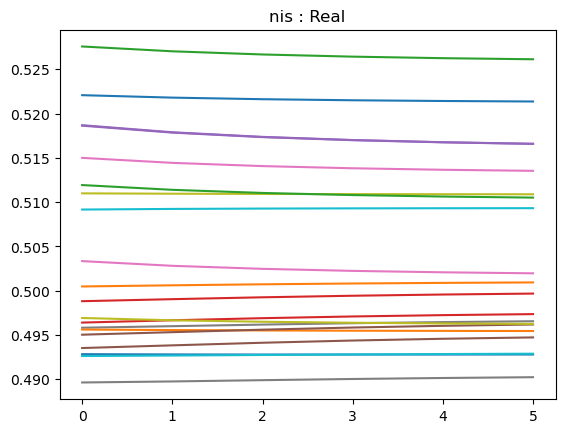

--- V = -1.5000000000000002 ---
[0.002 0.002 0.003 0.004 0.003 0.006 0.001 0.005 0.001 0.001 0.    0.001
 0.003 0.004 0.003 0.006 0.    0.004 0.    0.003]
[0.001 0.002 0.002 0.003 0.002 0.004 0.001 0.003 0.    0.    0.    0.
 0.002 0.003 0.002 0.004 0.    0.003 0.    0.002]
[0.001 0.001 0.002 0.002 0.002 0.003 0.001 0.002 0.    0.    0.    0.
 0.001 0.002 0.002 0.002 0.    0.002 0.    0.001]
[0.    0.    0.001 0.001 0.001 0.002 0.    0.001 0.    0.    0.    0.
 0.    0.001 0.001 0.002 0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


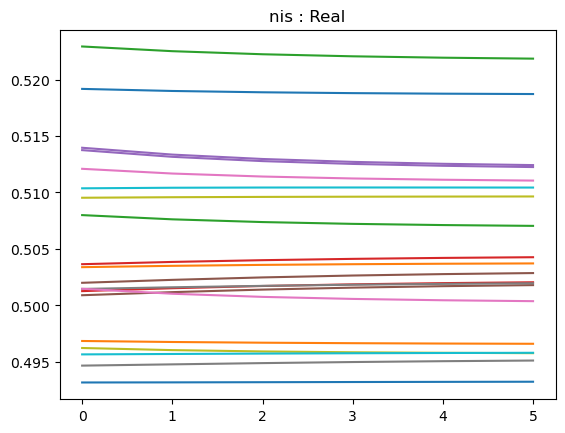

--- V = -1.6 ---
[0.001 0.001 0.002 0.002 0.001 0.004 0.    0.003 0.    0.    0.    0.001
 0.001 0.002 0.001 0.004 0.    0.003 0.    0.002]
[0.    0.    0.001 0.001 0.    0.002 0.    0.002 0.    0.    0.    0.
 0.    0.001 0.001 0.002 0.    0.002 0.    0.001]
[0.    0.    0.    0.    0.    0.002 0.    0.001 0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.001 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


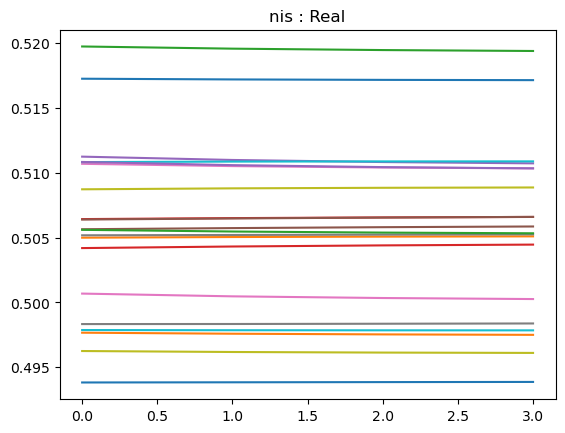

--- V = -1.7000000000000002 ---
[0.    0.    0.001 0.    0.    0.002 0.    0.002 0.    0.    0.    0.
 0.    0.    0.    0.002 0.    0.002 0.    0.001]
[0.    0.    0.    0.    0.    0.001 0.    0.001 0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.001 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


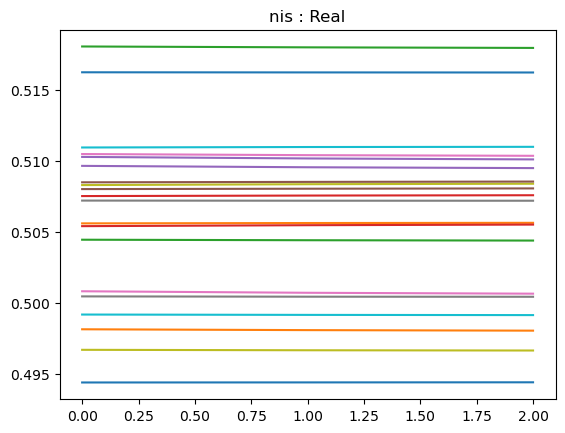

--- V = -1.8000000000000003 ---
[0.    0.    0.    0.    0.    0.001 0.    0.001 0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.001 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


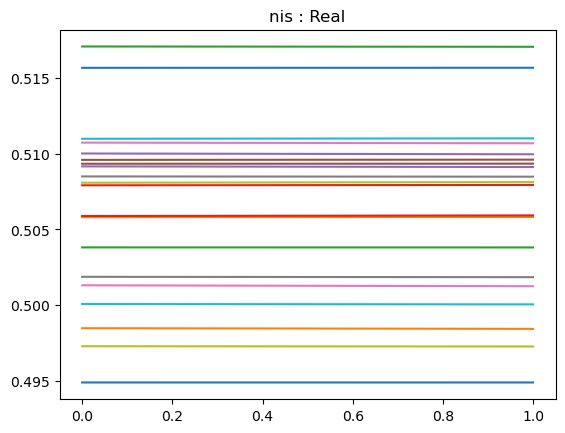

--- V = -1.9000000000000001 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


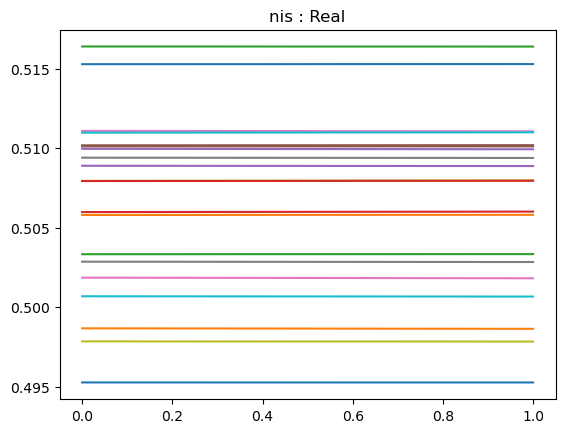

--- V = -2.0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


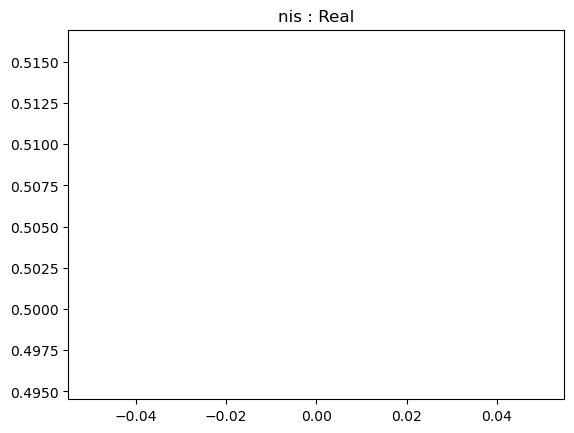

--- V = -2.1 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


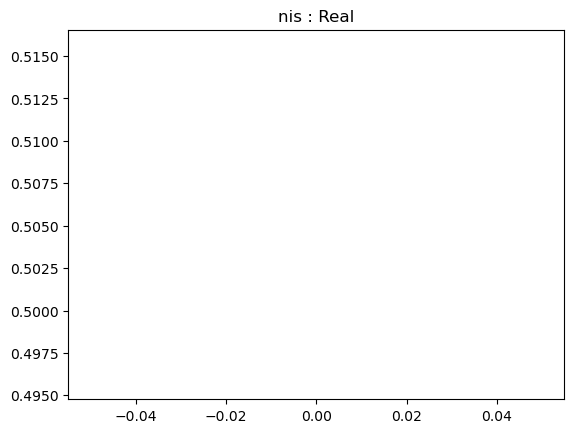

--- V = -2.2 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


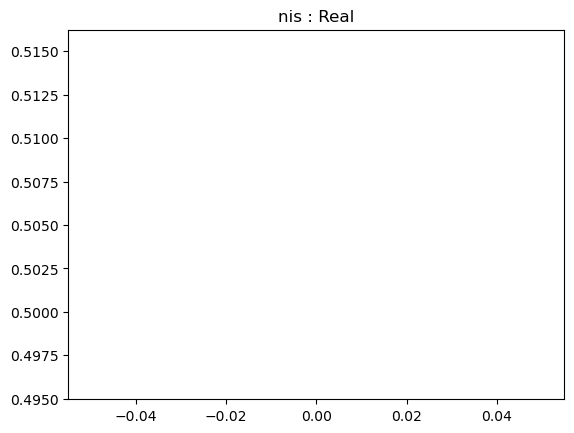

--- V = -2.3000000000000003 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


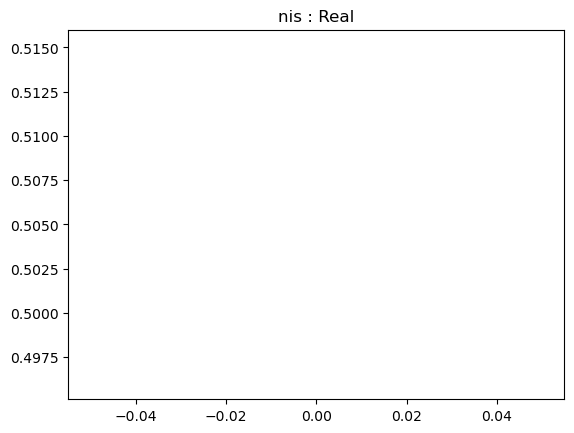

--- V = -2.4000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


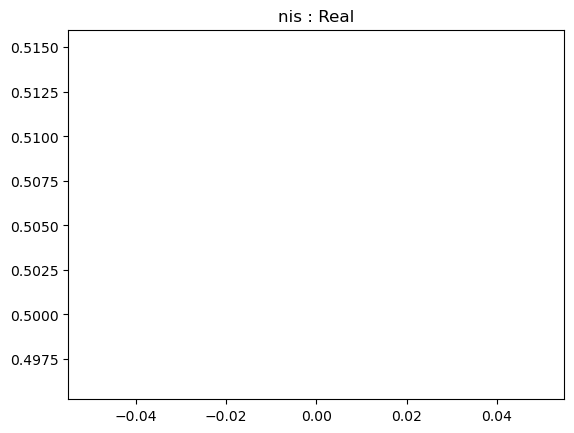

--- V = -2.5000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


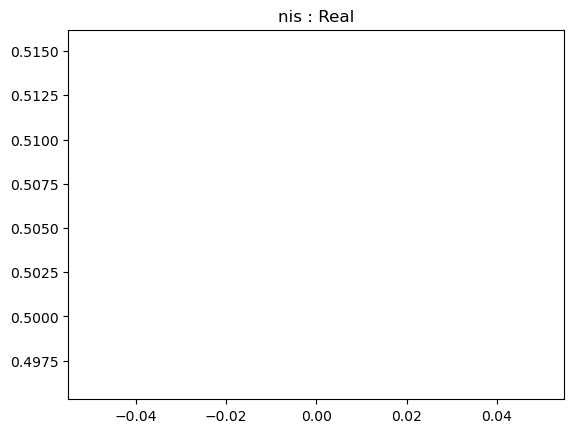

--- V = -2.6 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


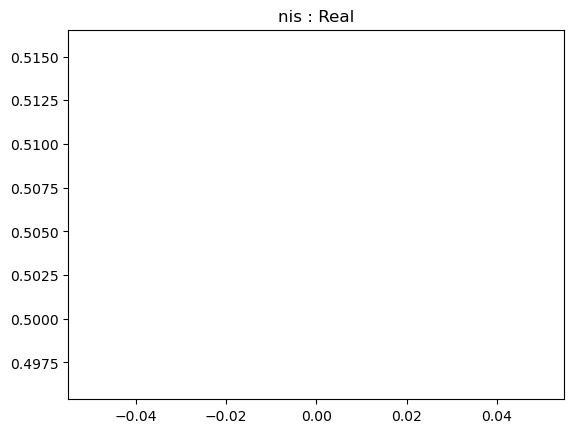

--- V = -2.7 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


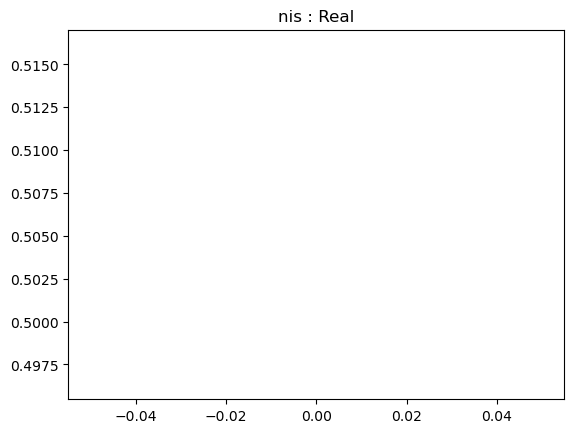

--- V = -2.8000000000000003 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


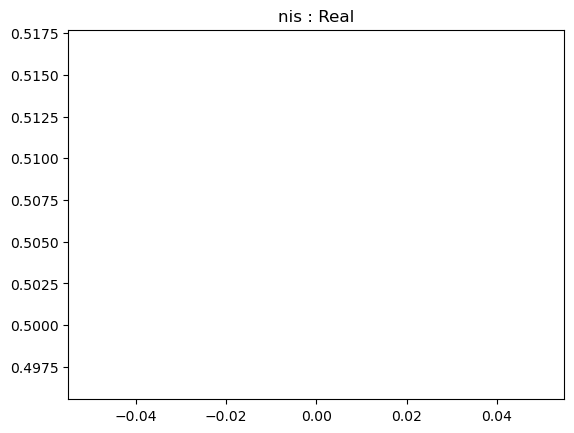

--- V = -2.9000000000000004 ---
[0.    0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


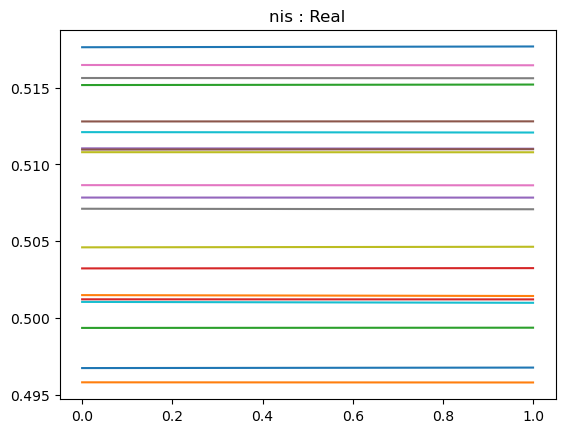

--- V = -3.0000000000000004 ---
[0.001 0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.    0.    0.001 0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


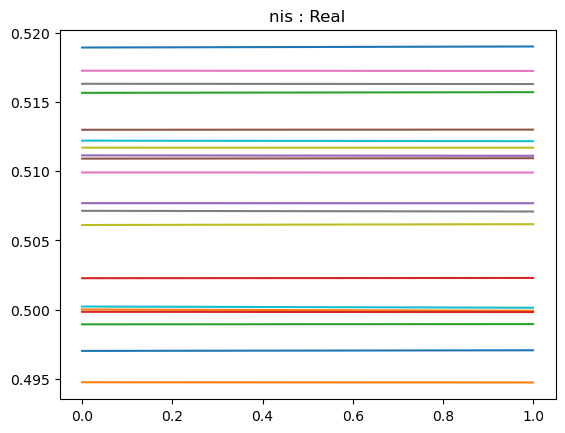

--- V = -3.1 ---
[0.002 0.002 0.    0.002 0.    0.    0.    0.    0.001 0.    0.    0.001
 0.    0.001 0.    0.    0.002 0.    0.002 0.001]
[0.001 0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


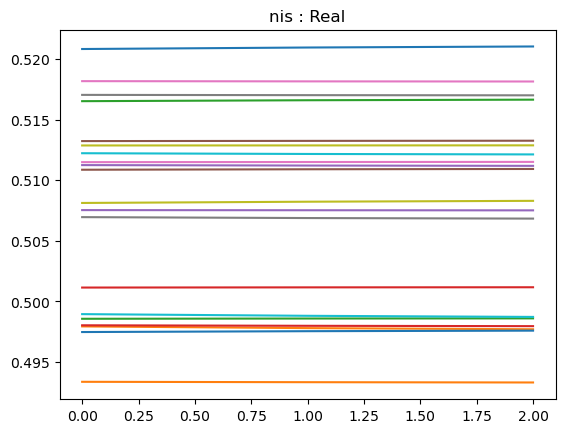

--- V = -3.2 ---
[0.002 0.003 0.001 0.002 0.    0.    0.001 0.    0.001 0.    0.    0.002
 0.    0.001 0.    0.    0.002 0.    0.003 0.002]
[0.002 0.002 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.    0.    0.001 0.    0.002 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


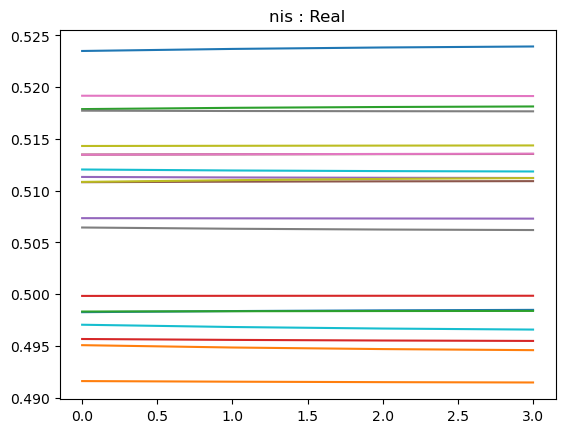

--- V = -3.3000000000000003 ---
[0.003 0.003 0.002 0.003 0.    0.    0.001 0.    0.002 0.    0.001 0.002
 0.    0.002 0.    0.    0.002 0.    0.003 0.002]
[0.002 0.002 0.001 0.002 0.    0.    0.    0.    0.001 0.    0.    0.001
 0.    0.    0.    0.    0.002 0.    0.002 0.002]
[0.002 0.002 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


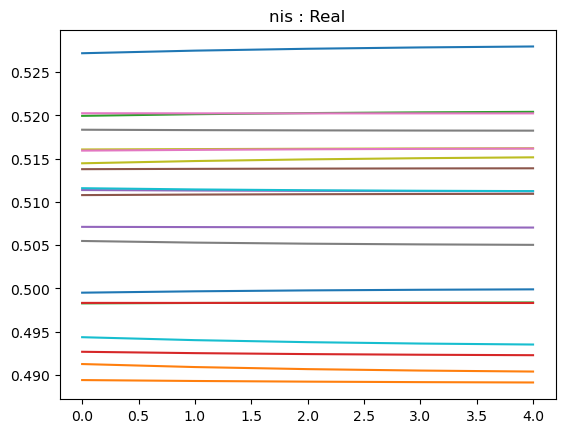

--- V = -3.4000000000000004 ---
[0.004 0.004 0.002 0.003 0.    0.    0.001 0.    0.002 0.    0.001 0.002
 0.    0.002 0.    0.    0.003 0.    0.004 0.002]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.001 0.    0.001 0.001
 0.    0.    0.    0.    0.002 0.    0.003 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.002 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


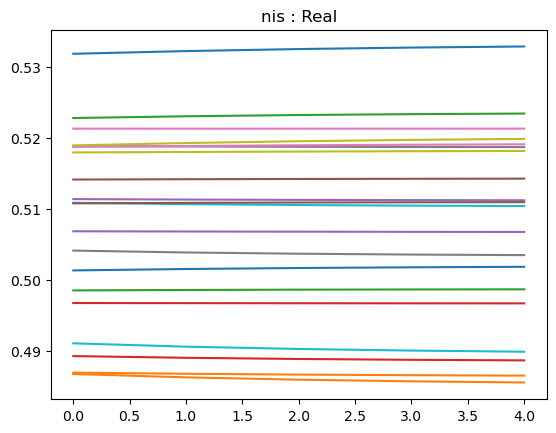

--- V = -3.5000000000000004 ---
[0.004 0.003 0.003 0.002 0.    0.    0.    0.    0.001 0.    0.002 0.002
 0.    0.001 0.    0.    0.002 0.    0.004 0.002]
[0.003 0.002 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.001 0.    0.002 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


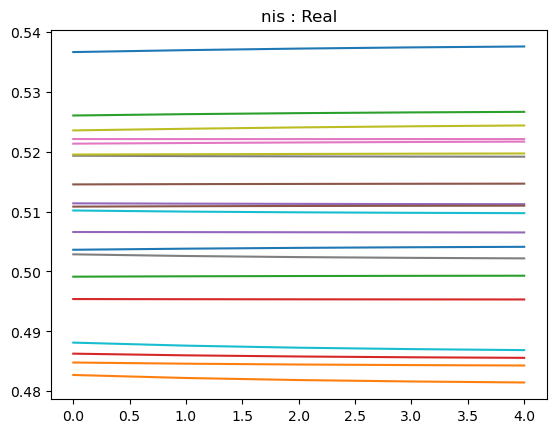

--- V = -3.6 ---
[0.002 0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.002 0.
 0.    0.    0.    0.    0.001 0.    0.002 0.   ]
[0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


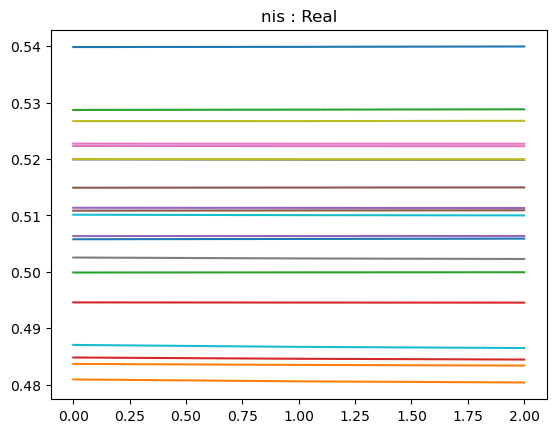

--- V = -3.7 ---
[0.    0.003 0.001 0.001 0.    0.    0.    0.    0.001 0.001 0.001 0.
 0.    0.    0.    0.    0.    0.002 0.    0.003]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.    0.002]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


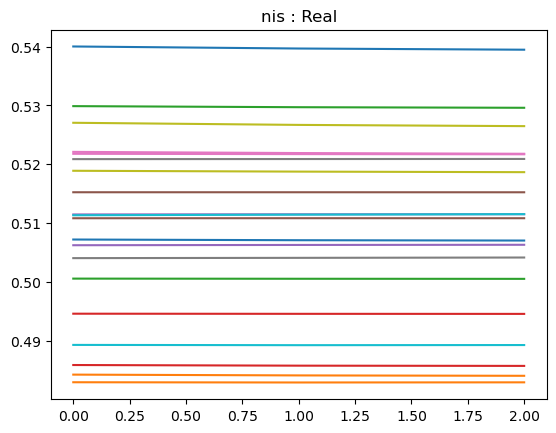

--- V = -3.8000000000000003 ---
[0.002 0.005 0.    0.003 0.    0.    0.001 0.001 0.002 0.002 0.    0.002
 0.    0.    0.    0.    0.002 0.003 0.002 0.005]
[0.002 0.003 0.    0.002 0.    0.    0.    0.    0.002 0.001 0.    0.001
 0.    0.    0.    0.    0.002 0.002 0.002 0.003]
[0.001 0.002 0.    0.001 0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.001 0.002]
[0.001 0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


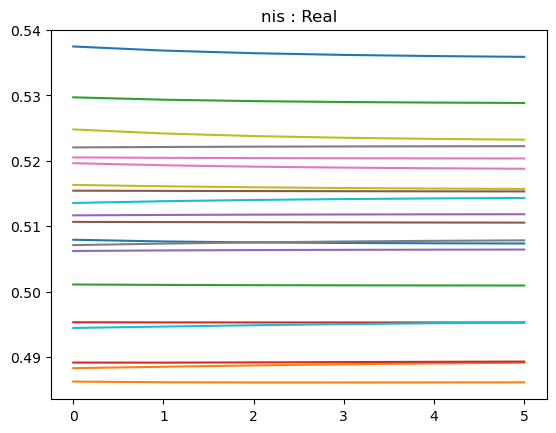

--- V = -3.9000000000000004 ---
[0.002 0.006 0.    0.004 0.    0.    0.001 0.    0.003 0.002 0.001 0.003
 0.    0.001 0.    0.    0.003 0.003 0.002 0.006]
[0.002 0.004 0.    0.003 0.    0.    0.    0.    0.002 0.001 0.    0.002
 0.    0.    0.    0.    0.002 0.002 0.002 0.004]
[0.002 0.003 0.    0.002 0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.001 0.002]
[0.001 0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.002]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


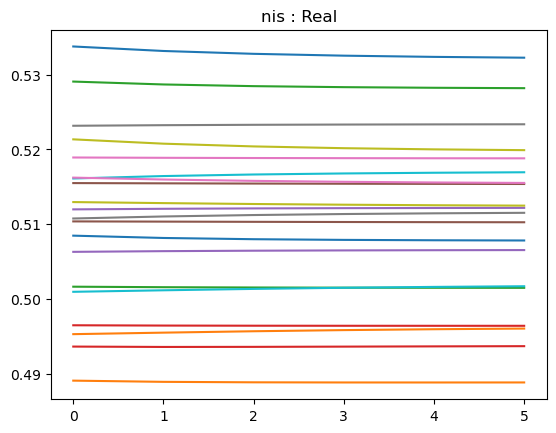

--- V = -4.0 ---
[0.002 0.005 0.    0.004 0.    0.    0.001 0.    0.003 0.001 0.002 0.003
 0.    0.001 0.    0.    0.002 0.002 0.001 0.005]
[0.001 0.003 0.    0.002 0.    0.    0.    0.    0.002 0.    0.    0.002
 0.    0.    0.    0.    0.002 0.002 0.001 0.003]
[0.001 0.002 0.    0.001 0.    0.    0.    0.    0.001 0.    0.    0.
 0.    0.    0.    0.    0.001 0.001 0.001 0.002]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


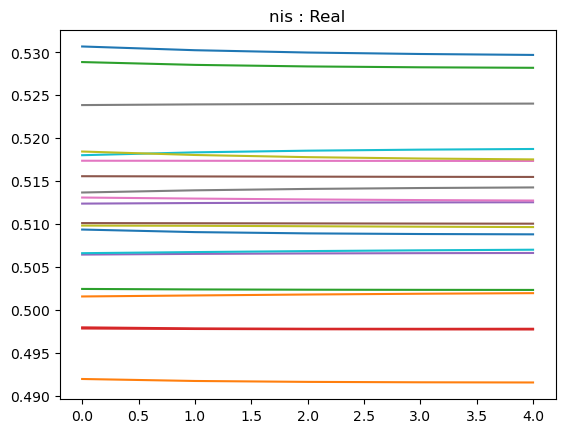

--- V = -4.1 ---
[0.    0.004 0.001 0.004 0.    0.    0.001 0.    0.002 0.    0.002 0.003
 0.001 0.001 0.    0.    0.002 0.001 0.    0.004]
[0.    0.003 0.    0.002 0.    0.    0.    0.    0.001 0.    0.    0.001
 0.    0.    0.    0.    0.001 0.    0.    0.002]
[0.    0.002 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


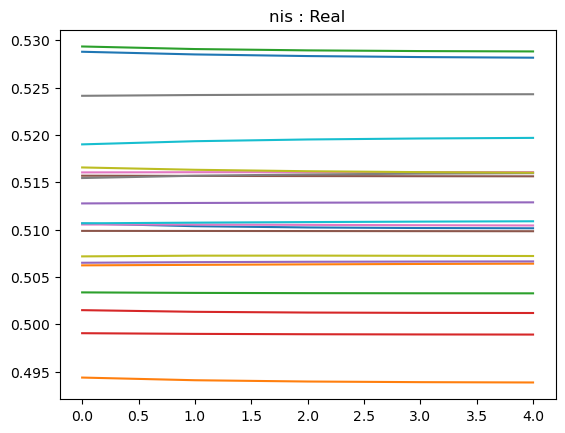

--- V = -4.2 ---
[0.    0.003 0.001 0.003 0.    0.    0.001 0.    0.002 0.    0.002 0.003
 0.001 0.001 0.    0.    0.002 0.    0.    0.003]
[0.    0.002 0.    0.002 0.    0.    0.    0.    0.001 0.    0.    0.001
 0.    0.    0.    0.    0.001 0.    0.    0.002]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


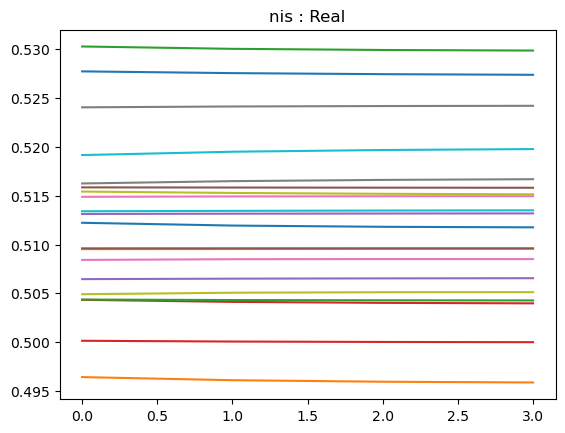

--- V = -4.3 ---
[0.    0.002 0.002 0.003 0.    0.    0.001 0.    0.002 0.001 0.002 0.002
 0.001 0.001 0.    0.    0.002 0.    0.    0.002]
[0.    0.001 0.    0.001 0.    0.    0.    0.    0.001 0.    0.001 0.001
 0.    0.    0.    0.    0.001 0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


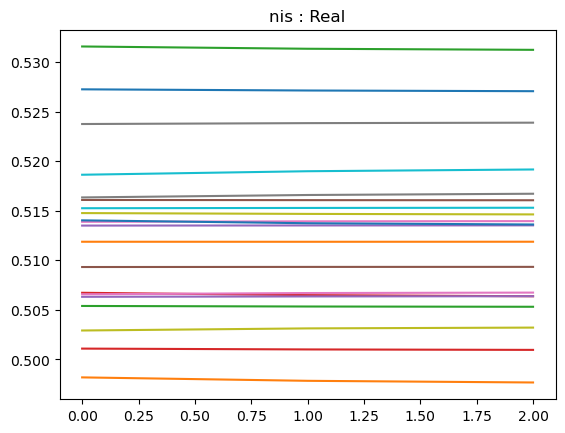

--- V = -4.3999999999999995 ---
[0.    0.002 0.002 0.002 0.    0.    0.    0.    0.002 0.002 0.002 0.002
 0.001 0.    0.    0.    0.002 0.    0.    0.001]
[0.    0.001 0.    0.001 0.    0.    0.    0.    0.001 0.    0.001 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


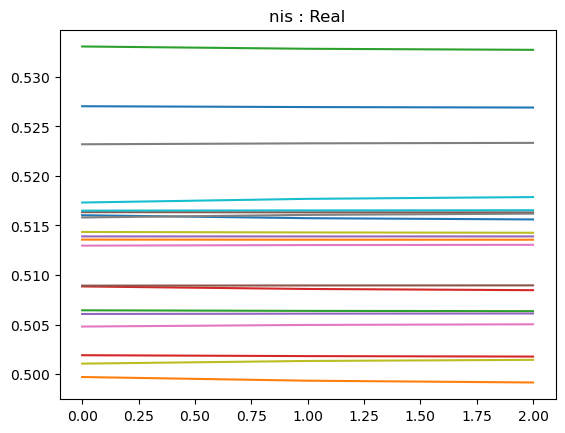

--- V = -4.5 ---
[0.    0.001 0.002 0.002 0.    0.    0.    0.001 0.002 0.003 0.003 0.002
 0.001 0.    0.    0.    0.002 0.002 0.    0.   ]
[0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.001 0.001 0.
 0.    0.    0.    0.    0.001 0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


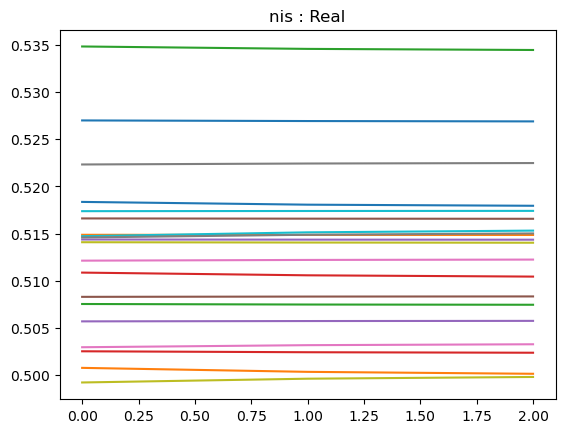

--- V = -4.6 ---
[0.    0.001 0.002 0.002 0.    0.    0.    0.002 0.002 0.006 0.003 0.
 0.001 0.    0.    0.001 0.002 0.003 0.    0.   ]
[0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.003 0.002 0.
 0.    0.    0.    0.    0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.001 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


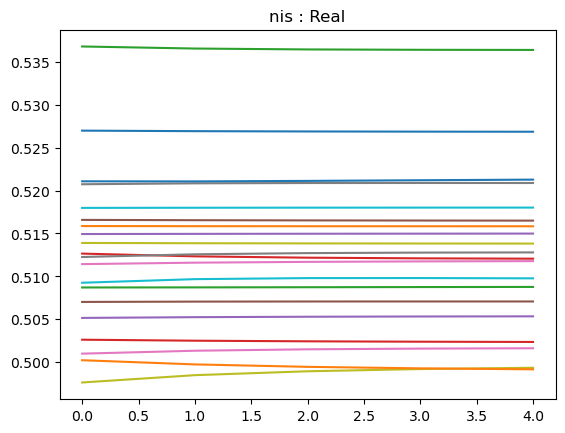

--- V = -4.7 ---
[0.    0.    0.003 0.002 0.    0.    0.    0.003 0.    0.012 0.004 0.004
 0.002 0.001 0.    0.003 0.002 0.005 0.    0.   ]
[0.    0.    0.002 0.    0.    0.    0.    0.002 0.003 0.007 0.005 0.003
 0.001 0.    0.    0.002 0.    0.003 0.    0.   ]
[0.    0.    0.001 0.    0.    0.    0.    0.001 0.004 0.005 0.004 0.003
 0.001 0.    0.    0.001 0.    0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.001 0.004 0.004 0.004 0.003
 0.    0.    0.    0.    0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.003 0.003 0.003
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.003 0.003 0.003
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.003 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]

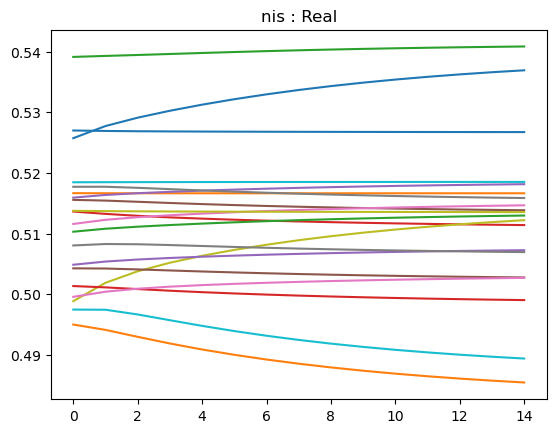

--- V = -4.8 ---
[0.    0.    0.004 0.    0.003 0.003 0.003 0.004 0.013 0.017 0.013 0.011
 0.003 0.003 0.003 0.004 0.002 0.006 0.    0.   ]
[0.    0.    0.003 0.001 0.004 0.003 0.004 0.004 0.015 0.015 0.014 0.011
 0.004 0.003 0.003 0.004 0.003 0.004 0.    0.   ]
[0.    0.    0.003 0.002 0.004 0.003 0.004 0.003 0.016 0.014 0.015 0.012
 0.004 0.003 0.004 0.003 0.004 0.003 0.    0.   ]
[0.    0.    0.003 0.003 0.004 0.003 0.004 0.003 0.016 0.014 0.015 0.013
 0.004 0.003 0.004 0.003 0.004 0.003 0.    0.   ]
[0.    0.    0.003 0.003 0.004 0.003 0.004 0.003 0.016 0.013 0.015 0.013
 0.003 0.003 0.004 0.003 0.004 0.003 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.004 0.003 0.016 0.012 0.015 0.013
 0.003 0.003 0.004 0.003 0.004 0.002 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.004 0.003 0.015 0.012 0.014 0.012
 0.003 0.003 0.004 0.003 0.004 0.002 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.003 0.002 0.014 0.011 0.013 0.012
 0.003 0.003 0.003 0.002 0.003 0.002 0.    0.   ]

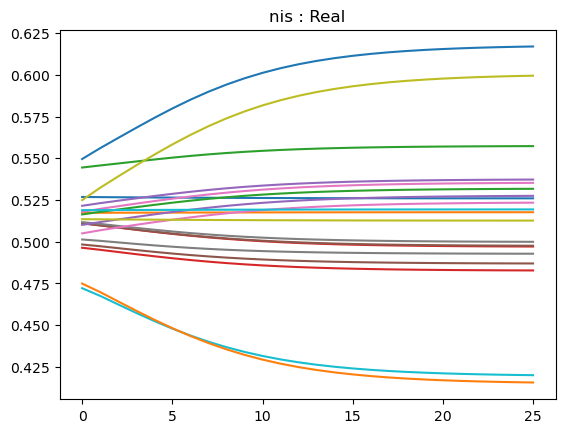

--- V = -4.9 ---
[0.    0.    0.002 0.002 0.    0.    0.    0.001 0.001 0.004 0.006 0.006
 0.002 0.002 0.001 0.    0.    0.    0.    0.   ]
[0.    0.    0.001 0.002 0.    0.    0.    0.    0.003 0.003 0.005 0.004
 0.001 0.001 0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.001 0.001 0.    0.    0.    0.    0.003 0.002 0.004 0.003
 0.001 0.001 0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.003 0.003
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.001 0.003 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.001 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.001 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.002 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]

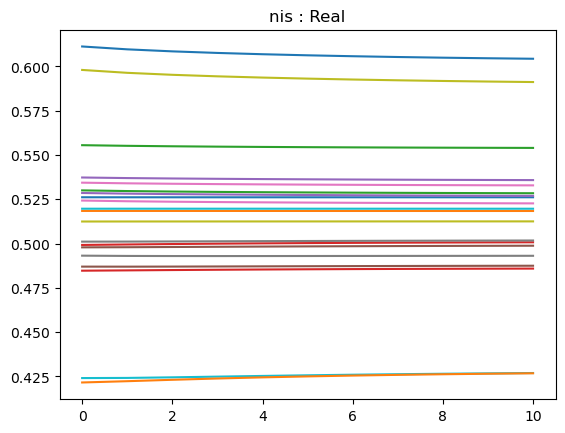

--- V = -5.0 ---
[0.    0.    0.009 0.008 0.007 0.007 0.006 0.007 0.026 0.029 0.033 0.031
 0.008 0.008 0.006 0.006 0.004 0.006 0.    0.   ]
[0.    0.    0.007 0.007 0.007 0.006 0.006 0.006 0.023 0.025 0.028 0.028
 0.007 0.007 0.006 0.006 0.004 0.005 0.    0.   ]
[0.    0.    0.006 0.006 0.006 0.006 0.005 0.005 0.021 0.022 0.024 0.024
 0.005 0.006 0.005 0.005 0.004 0.004 0.    0.   ]
[0.    0.    0.005 0.005 0.005 0.005 0.004 0.004 0.018 0.019 0.02  0.021
 0.004 0.005 0.005 0.005 0.004 0.004 0.    0.   ]
[0.    0.    0.004 0.005 0.004 0.005 0.003 0.004 0.015 0.017 0.017 0.018
 0.004 0.004 0.004 0.004 0.003 0.003 0.    0.   ]
[0.    0.    0.003 0.004 0.004 0.004 0.003 0.003 0.013 0.014 0.014 0.016
 0.003 0.003 0.004 0.004 0.003 0.003 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.002 0.003 0.011 0.012 0.012 0.013
 0.002 0.003 0.003 0.003 0.002 0.002 0.    0.   ]
[0.    0.    0.002 0.003 0.003 0.003 0.002 0.002 0.009 0.01  0.01  0.011
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]

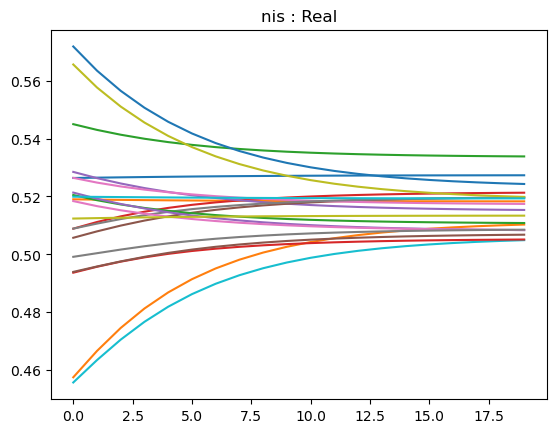

--- V = -5.1 ---
[0.    0.    0.002 0.002 0.    0.003 0.001 0.004 0.006 0.016 0.001 0.01
 0.    0.003 0.002 0.005 0.003 0.005 0.    0.   ]
[0.    0.    0.001 0.001 0.    0.002 0.    0.002 0.002 0.009 0.002 0.006
 0.    0.002 0.    0.003 0.002 0.003 0.    0.   ]
[0.    0.    0.001 0.    0.    0.001 0.    0.001 0.    0.005 0.002 0.004
 0.    0.001 0.    0.002 0.    0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.001 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


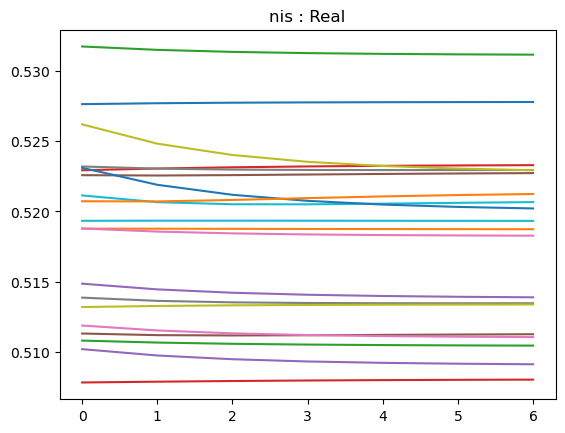

--- V = -5.2 ---
[0.    0.    0.001 0.    0.    0.    0.    0.001 0.005 0.007 0.    0.003
 0.    0.    0.002 0.002 0.003 0.003 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.004 0.    0.002
 0.    0.    0.    0.001 0.001 0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


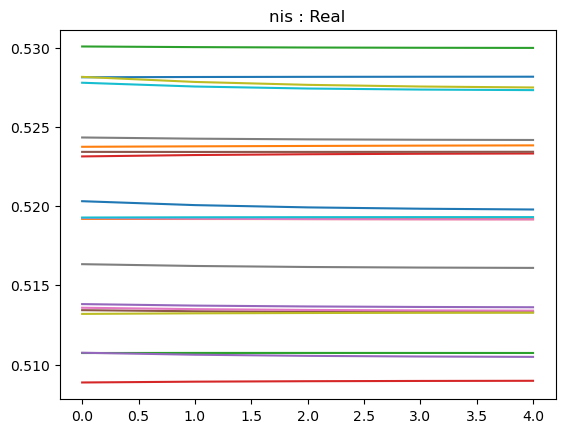

--- V = -5.3 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.004 0.    0.
 0.    0.    0.001 0.001 0.002 0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


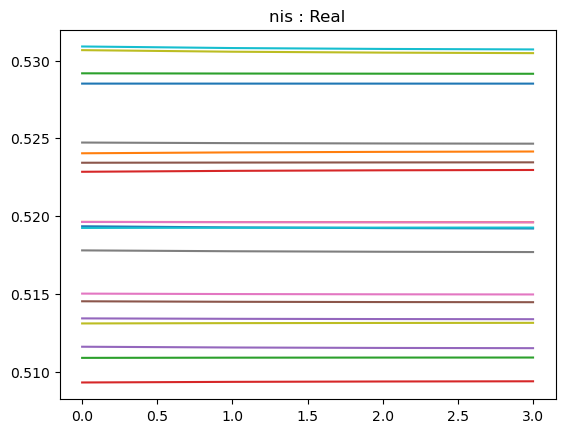

--- V = -5.4 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


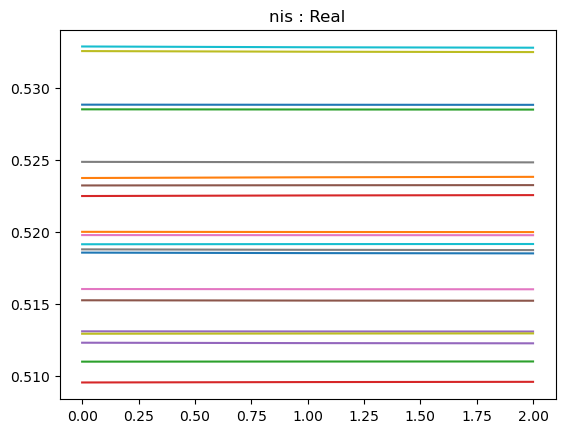

--- V = -5.5 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


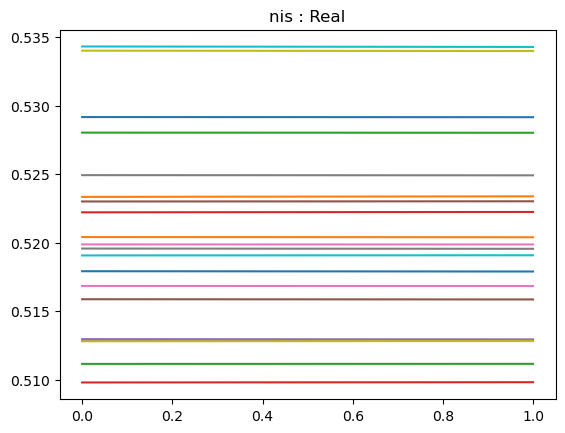

--- V = -5.6 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


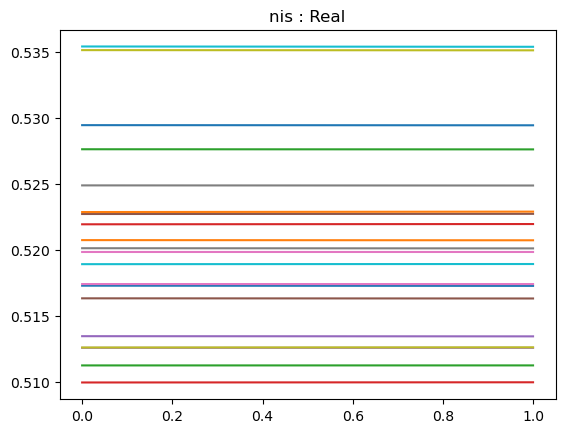

--- V = -5.7 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


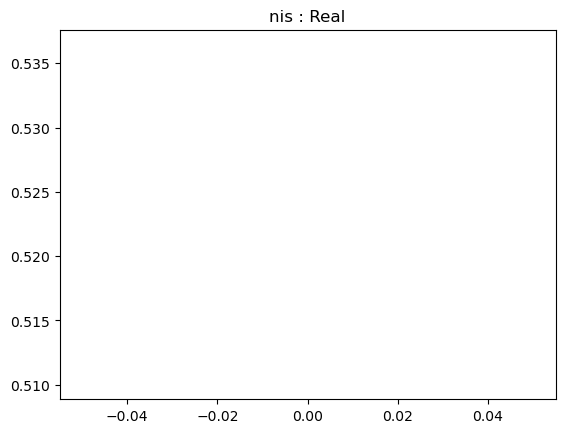

--- V = -5.8 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


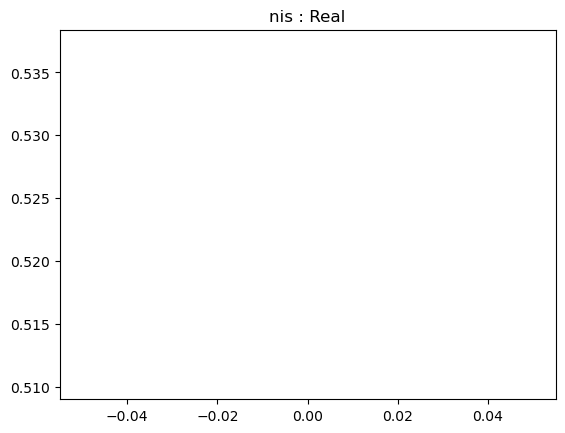

--- V = -5.9 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


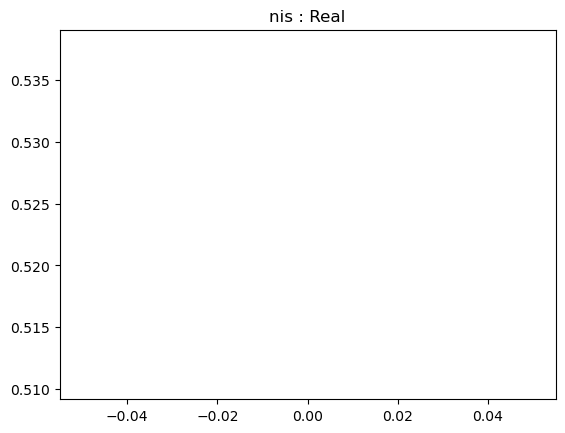

--- V = -6.0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


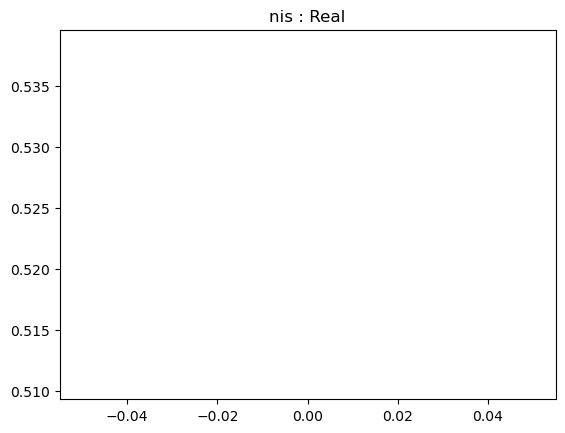

--- V = 0 ---
[0.007 0.007 0.008 0.008 0.002 0.002 0.002 0.002 0.    0.    0.005 0.005
 0.003 0.003 0.001 0.001 0.002 0.002 0.003 0.003]
[0.005 0.005 0.005 0.005 0.    0.    0.001 0.001 0.    0.    0.003 0.003
 0.002 0.002 0.    0.    0.002 0.002 0.002 0.002]
[0.003 0.003 0.004 0.004 0.    0.    0.    0.    0.    0.    0.002 0.002
 0.001 0.001 0.    0.    0.001 0.001 0.001 0.001]
[0.002 0.002 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.001 0.001 0.002 0.002 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 0.1 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 0.2 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 0.30000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 0.4 ---
[0 0 0

[0.002 0.002 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 3.4000000000000004 ---
[0.004 0.004 0.002 0.003 0.    0.    0.001 0.    0.002 0.    0.001 0.002
 0.    0.002 0.    0.    0.003 0.    0.004 0.002]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.001 0.    0.001 0.001
 0.    0.    0.    0.    0.002 0.    0.003 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.002 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 3.5000000000000004 ---
[0.004 0.003 0.003 0.002 0.    0.    0.    0.    0.001 0.    0.002 0.002
 0.    0.001 0.    0.    0.002 0.    0.004 0.002]
[0.00

[0.    0.    0.003 0.001 0.004 0.003 0.004 0.004 0.015 0.015 0.014 0.011
 0.004 0.003 0.003 0.004 0.003 0.004 0.    0.   ]
[0.    0.    0.003 0.002 0.004 0.003 0.004 0.003 0.016 0.014 0.015 0.012
 0.004 0.003 0.004 0.003 0.004 0.003 0.    0.   ]
[0.    0.    0.003 0.003 0.004 0.003 0.004 0.003 0.016 0.013 0.015 0.013
 0.004 0.003 0.004 0.003 0.004 0.003 0.    0.   ]
[0.    0.    0.003 0.003 0.004 0.003 0.004 0.003 0.016 0.013 0.015 0.013
 0.003 0.003 0.004 0.003 0.004 0.003 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.004 0.003 0.016 0.012 0.015 0.013
 0.003 0.003 0.004 0.003 0.004 0.002 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.004 0.003 0.015 0.011 0.014 0.012
 0.003 0.003 0.004 0.003 0.004 0.002 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.003 0.002 0.014 0.011 0.013 0.012
 0.003 0.003 0.003 0.002 0.003 0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.003 0.002 0.003 0.002 0.013 0.01  0.012 0.011
 0.003 0.002 0.003 0.002 0.003 0.002 0.    0.   ]
[0.    0.    0.0

[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 5.4 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 5.5 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 5.6 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 5.7 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 5.8 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 5.9 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 6.

[0.003 0.003 0.003 0.002 0.    0.    0.    0.001 0.    0.002 0.002 0.001
 0.002 0.    0.    0.    0.    0.002 0.002 0.003]
[0.002 0.002 0.002 0.001 0.    0.    0.    0.    0.    0.001 0.001 0.
 0.    0.    0.    0.    0.    0.001 0.002 0.002]
[0.002 0.002 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = -3.4000000000000004 ---
[0.004 0.004 0.003 0.002 0.    0.    0.    0.001 0.    0.002 0.002 0.001
 0.002 0.    0.    0.    0.    0.003 0.002 0.004]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.    0.001 0.001 0.001
 0.    0.    0.    0.    0.    0.002 0.002 0.003]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.001 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    

[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = -4.8 ---
[0.    0.    0.    0.004 0.003 0.003 0.004 0.003 0.017 0.013 0.01  0.013
 0.003 0.003 0.004 0.003 0.006 0.002 0.    0.   ]
[0.    0.    0.001 0.003 0.003 0.004 0.004 0.004 0.015 0.015 0.011 0.014
 0.003 0.004 0.004 0.003 0.004 0.003 0.    0.   ]
[0.    0.    0.002 0.003 0.003 0.004 0.003 0.004 0.014 0.016 0.012 0.015
 0.003 0.004 0.003 0.004 0.003 0.004 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.004 0.003 0.004 0.013 0.016 0.013 0.015
 0.003 0.004 0.003 0.004 0.003 0.004 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.004 0.003 0.004 0.013 0.016 0.013 0.015
 0.003 0.003 0.003 0.004 0.003 0.004 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.003 0.004 0.012 0.016 0.013 0.015
 0.003 0.003 0.003 0.004 0.002 0.004 0.    0.   ]
[0.    0.    0.003 0.003 0.003 0.003 0.003 0.004 0.011 0.015 0.012 0.014
 0.003 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = -5.3 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.004 0.003 0.    0.
 0.    0.    0.001 0.001 0.002 0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = -5.4 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = -5.5 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = -5.6 ---
[0.    0.    0.    0.    0.    0.    0.    0

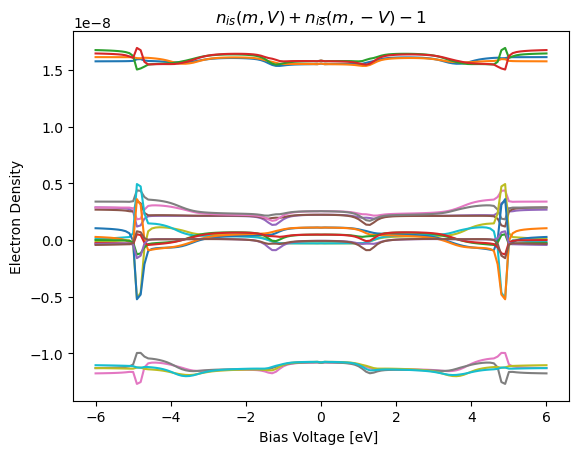

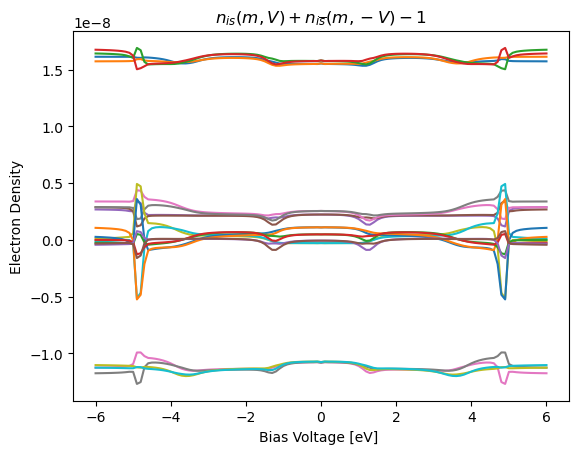

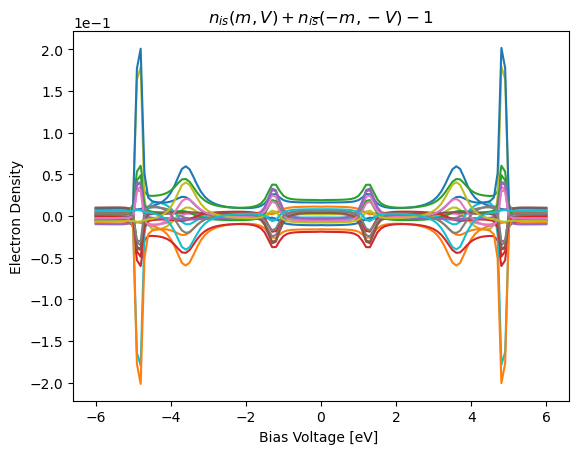

Lm2_Wg2_kmax4_pz0.5_epsilon0LR00_tleadLR9.6_9.6_tcoupLR1.5491933384829668_1.5491933384829668_T300_alpha0.6_t2.4_U1.2_lambda10.24_ef0_tol0.001_Vmax6_len121_emin-28.9_emax28.9_npoints10000_tolintegrand1e-15.txt
calculating currents ...


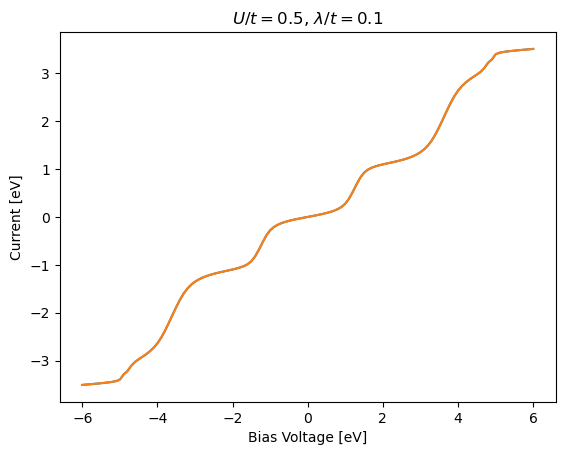

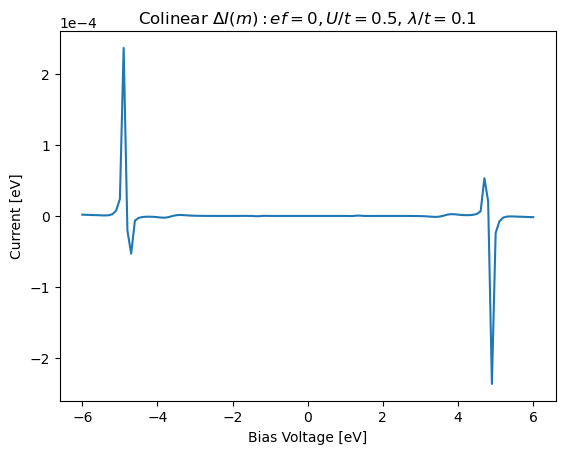

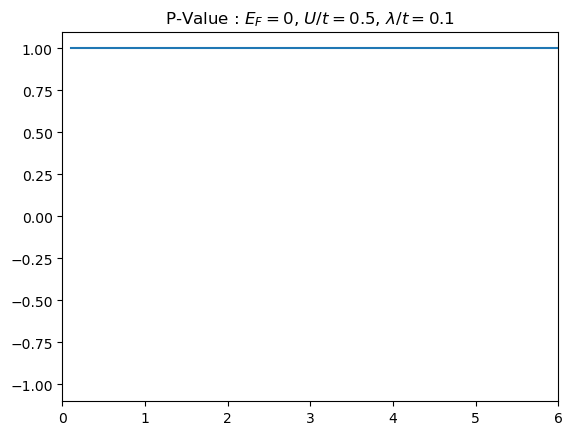

tleadL, tleadR = 9.6,9.6 & tcoupLR = 1.5491933384829668,1.5491933384829668
0.0 0.0
--- ef = 0, tsom/t = 0.1 , U/t = 1.0,
--- V = 0 ---
[0.007 0.007 0.008 0.008 0.002 0.002 0.002 0.002 0.    0.    0.005 0.005
 0.003 0.003 0.001 0.001 0.002 0.002 0.003 0.003]
[0.005 0.005 0.006 0.006 0.    0.    0.001 0.001 0.    0.    0.003 0.003
 0.002 0.002 0.001 0.001 0.002 0.002 0.002 0.002]
[0.004 0.004 0.004 0.004 0.    0.    0.    0.    0.    0.    0.003 0.003
 0.001 0.001 0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.003 0.003 0.    0.    0.    0.    0.    0.    0.002 0.002
 0.    0.    0.    0.    0.001 0.001 0.001 0.001]
[0.002 0.002 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.001 0.001 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 

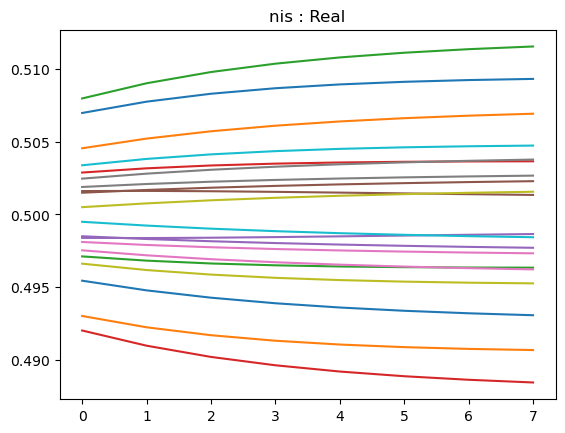

--- V = 0.1 ---
[0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


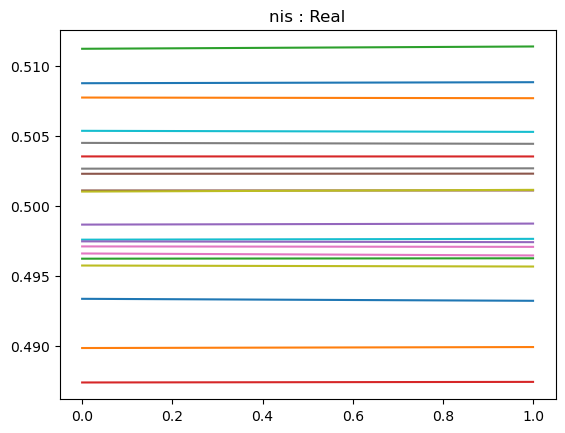

--- V = 0.2 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


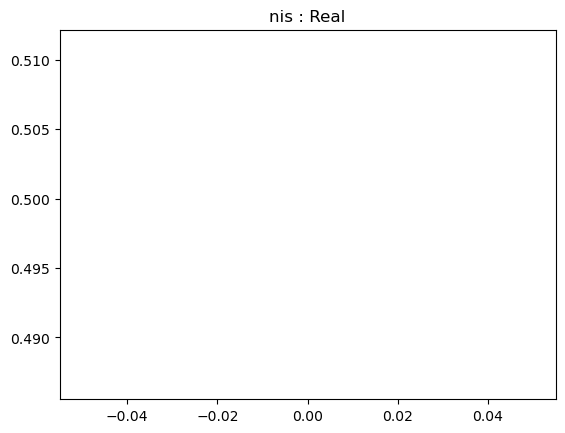

--- V = 0.30000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


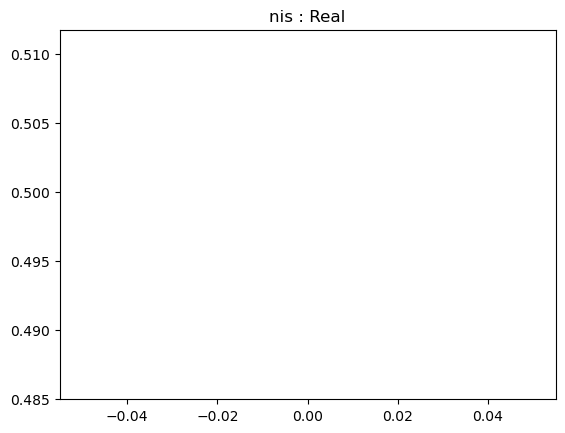

--- V = 0.4 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


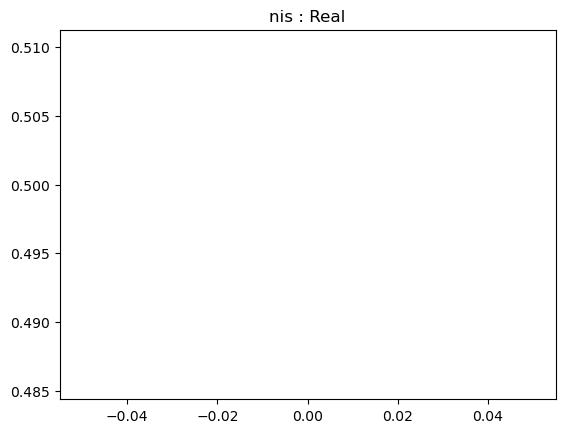

--- V = 0.5 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


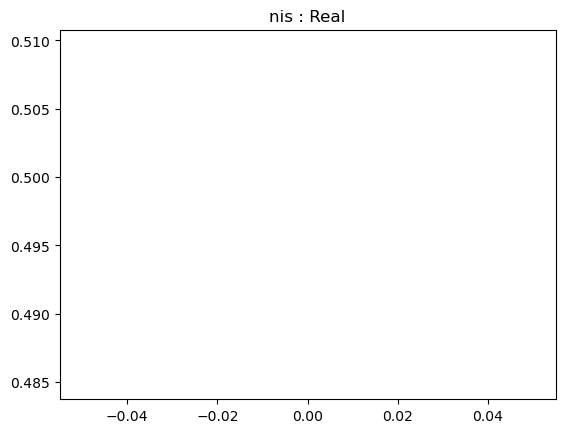

--- V = 0.6 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


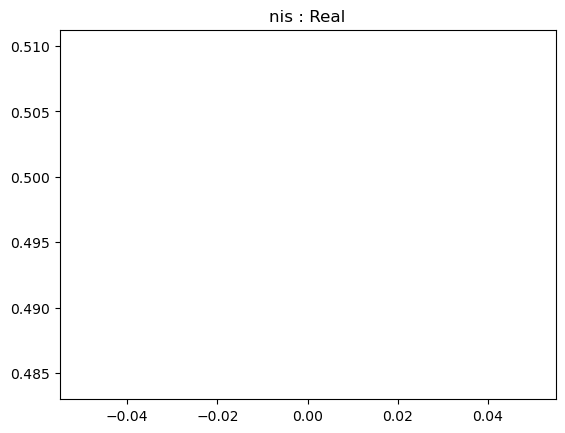

--- V = 0.7000000000000001 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


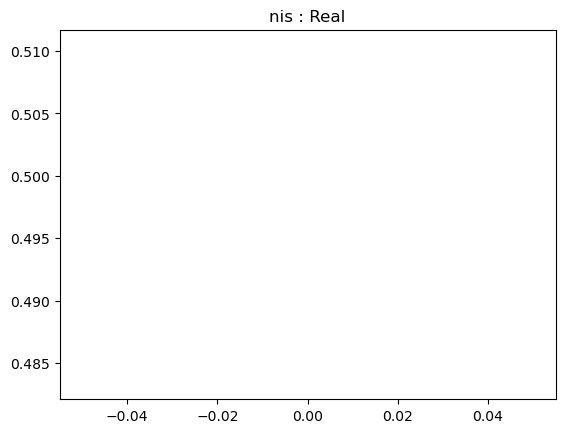

--- V = 0.8 ---
[0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


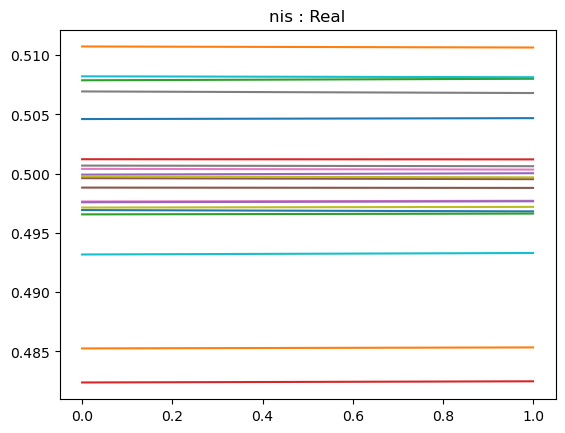

--- V = 0.9 ---
[0.    0.001 0.    0.002 0.    0.002 0.    0.001 0.    0.001 0.001 0.
 0.    0.001 0.    0.002 0.001 0.    0.001 0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


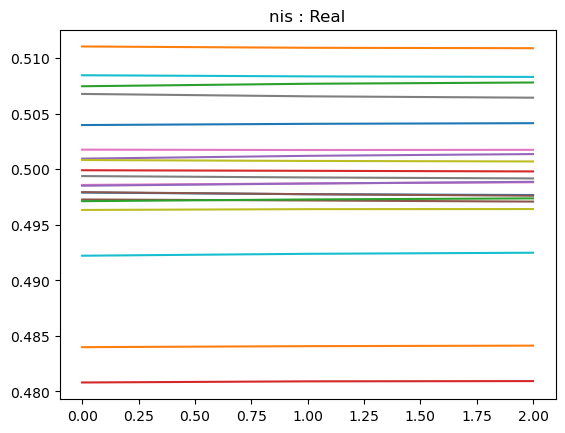

--- V = 1.0 ---
[0.    0.002 0.    0.003 0.002 0.003 0.002 0.002 0.    0.001 0.001 0.
 0.001 0.002 0.002 0.003 0.002 0.    0.002 0.   ]
[0.    0.001 0.    0.002 0.002 0.002 0.001 0.002 0.    0.    0.    0.
 0.001 0.002 0.002 0.002 0.001 0.    0.    0.   ]
[0.    0.    0.    0.001 0.001 0.002 0.001 0.001 0.    0.    0.    0.
 0.    0.001 0.001 0.002 0.001 0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


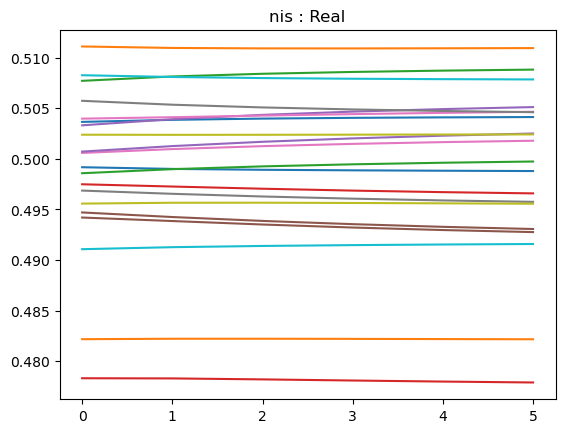

--- V = 1.1 ---
[0.    0.003 0.    0.004 0.004 0.005 0.003 0.004 0.    0.002 0.002 0.
 0.003 0.004 0.004 0.005 0.003 0.002 0.003 0.001]
[0.    0.002 0.002 0.003 0.004 0.004 0.003 0.003 0.    0.    0.001 0.
 0.003 0.003 0.004 0.004 0.003 0.002 0.002 0.001]
[0.    0.001 0.002 0.002 0.003 0.004 0.003 0.003 0.    0.    0.    0.
 0.002 0.003 0.003 0.004 0.002 0.002 0.001 0.   ]
[0.    0.001 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0.    0.    0.001 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.001 0.002 0.    0.    0.    0.
 0.001 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.001 0.001 0.    0.    0.    0.
 0.001 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.    0.   

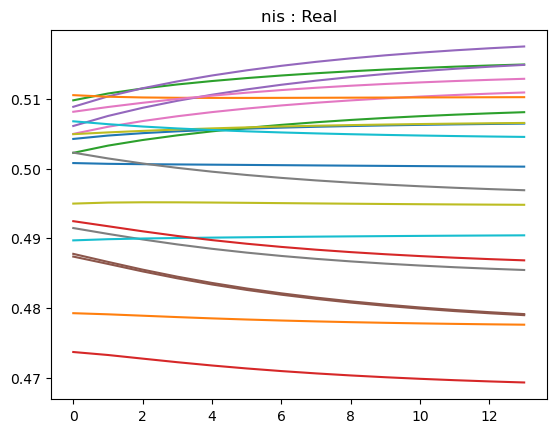

--- V = 1.2000000000000002 ---
[0.001 0.004 0.002 0.005 0.005 0.008 0.004 0.006 0.    0.002 0.002 0.001
 0.003 0.006 0.005 0.007 0.004 0.005 0.003 0.003]
[0.001 0.002 0.003 0.004 0.005 0.006 0.004 0.005 0.    0.001 0.001 0.001
 0.004 0.004 0.005 0.006 0.004 0.004 0.002 0.002]
[0.001 0.002 0.003 0.003 0.005 0.005 0.004 0.004 0.    0.    0.    0.
 0.003 0.004 0.005 0.005 0.003 0.004 0.002 0.002]
[0.001 0.002 0.003 0.003 0.004 0.005 0.003 0.004 0.    0.    0.    0.
 0.003 0.003 0.004 0.005 0.003 0.003 0.001 0.002]
[0.001 0.001 0.002 0.003 0.004 0.004 0.003 0.003 0.    0.    0.    0.
 0.003 0.003 0.004 0.004 0.003 0.003 0.001 0.001]
[0.001 0.001 0.002 0.002 0.004 0.004 0.003 0.003 0.    0.    0.    0.
 0.002 0.003 0.004 0.004 0.002 0.003 0.    0.001]
[0.    0.    0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.001]
[0.    0.    0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0.

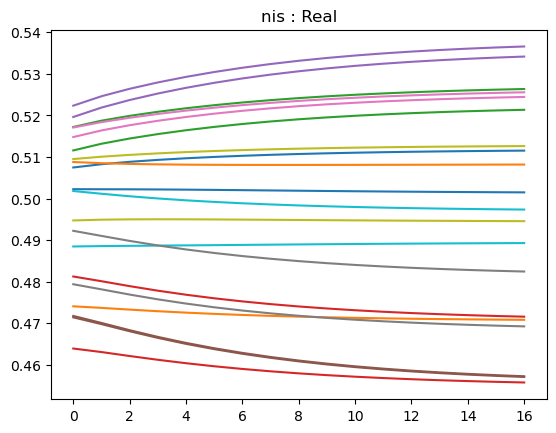

--- V = 1.3000000000000003 ---
[0.    0.    0.    0.002 0.    0.002 0.    0.002 0.    0.    0.    0.
 0.    0.001 0.    0.002 0.    0.002 0.    0.001]
[0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


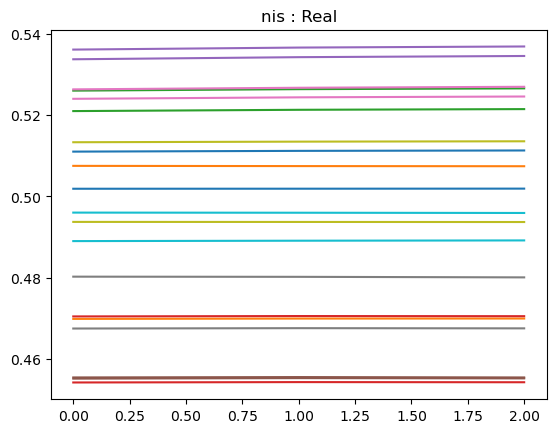

--- V = 1.4000000000000001 ---
[0.003 0.002 0.004 0.003 0.007 0.005 0.005 0.003 0.002 0.002 0.    0.
 0.005 0.004 0.007 0.005 0.003 0.002 0.002 0.001]
[0.002 0.002 0.004 0.003 0.005 0.005 0.004 0.003 0.001 0.    0.    0.
 0.004 0.004 0.005 0.005 0.003 0.002 0.001 0.001]
[0.002 0.002 0.003 0.003 0.004 0.004 0.003 0.003 0.    0.    0.    0.
 0.003 0.003 0.004 0.004 0.002 0.002 0.001 0.001]
[0.001 0.001 0.003 0.003 0.004 0.004 0.003 0.003 0.    0.    0.    0.
 0.003 0.003 0.004 0.004 0.002 0.002 0.    0.001]
[0.001 0.001 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.001 0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.002 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.001 0.001 0.    0.    0.    0.
 0.001 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.

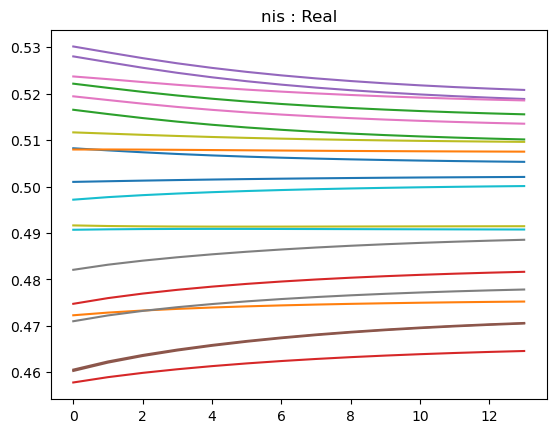

--- V = 1.5000000000000002 ---
[0.004 0.003 0.007 0.005 0.01  0.006 0.008 0.004 0.002 0.002 0.002 0.
 0.007 0.005 0.01  0.007 0.006 0.003 0.004 0.002]
[0.003 0.003 0.005 0.005 0.007 0.006 0.005 0.004 0.001 0.001 0.    0.
 0.005 0.004 0.007 0.006 0.005 0.003 0.003 0.002]
[0.002 0.002 0.004 0.004 0.006 0.005 0.004 0.003 0.    0.    0.    0.
 0.004 0.004 0.006 0.005 0.004 0.003 0.002 0.001]
[0.002 0.002 0.003 0.003 0.005 0.004 0.003 0.003 0.    0.    0.    0.
 0.003 0.003 0.004 0.004 0.003 0.003 0.001 0.001]
[0.001 0.001 0.003 0.003 0.004 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.004 0.003 0.002 0.002 0.001 0.   ]
[0.    0.    0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.002 0.002 0.001 0.    0.    0.    0.
 0.002 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.001 0.001 0.    0.    0.    0.
 0.001 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.

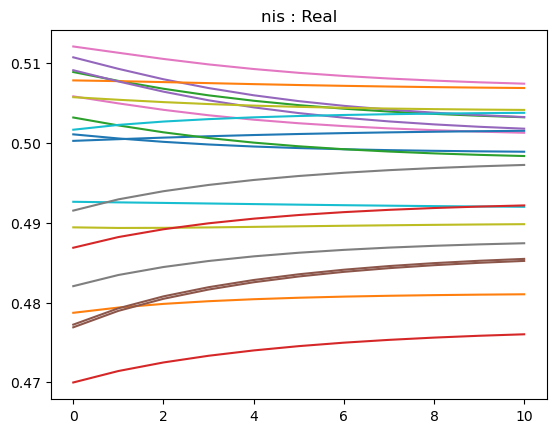

--- V = 1.6 ---
[0.002 0.002 0.003 0.003 0.006 0.002 0.004 0.    0.    0.    0.001 0.
 0.003 0.002 0.005 0.002 0.004 0.    0.003 0.   ]
[0.001 0.001 0.002 0.002 0.004 0.002 0.003 0.001 0.    0.    0.    0.
 0.002 0.002 0.003 0.002 0.003 0.    0.002 0.   ]
[0.    0.    0.002 0.002 0.002 0.002 0.002 0.    0.    0.    0.    0.
 0.002 0.001 0.002 0.002 0.002 0.    0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.001 0.001 0.    0.    0.    0.    0.
 0.001 0.    0.002 0.001 0.001 0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


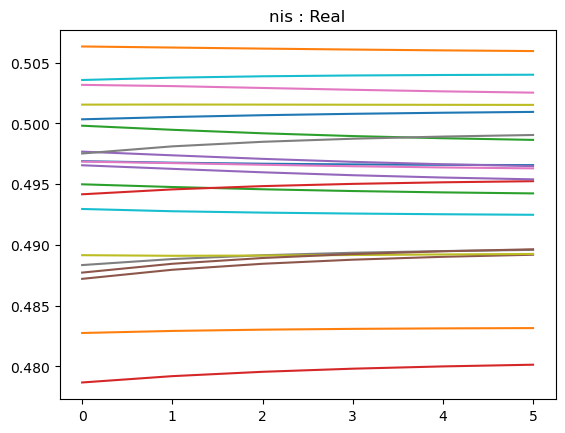

--- V = 1.7000000000000002 ---
[0.    0.    0.002 0.001 0.003 0.    0.002 0.    0.    0.    0.    0.
 0.001 0.    0.003 0.    0.003 0.    0.002 0.   ]
[0.    0.    0.001 0.001 0.002 0.    0.001 0.    0.    0.    0.    0.
 0.    0.    0.002 0.    0.002 0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


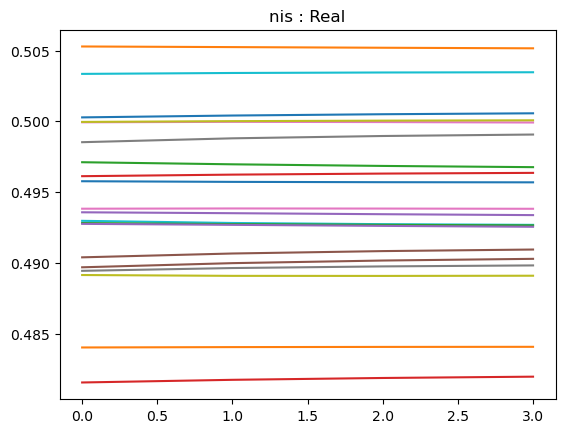

--- V = 1.8000000000000003 ---
[0.    0.    0.    0.    0.002 0.    0.002 0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.002 0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


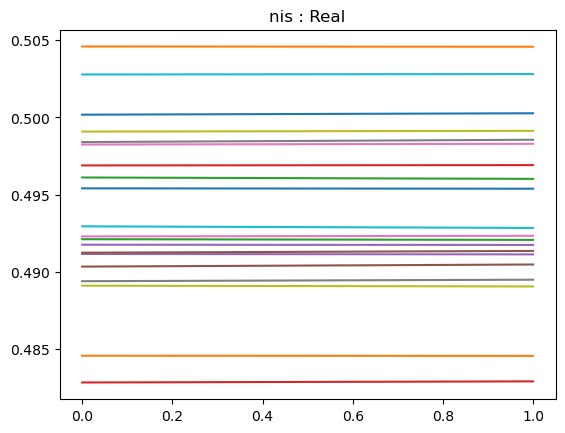

--- V = 1.9000000000000001 ---
[0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


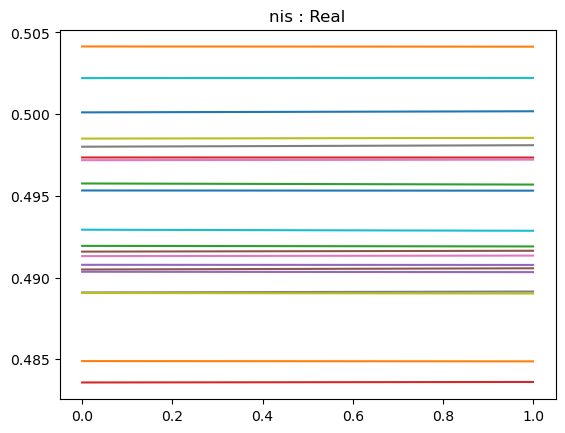

--- V = 2.0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


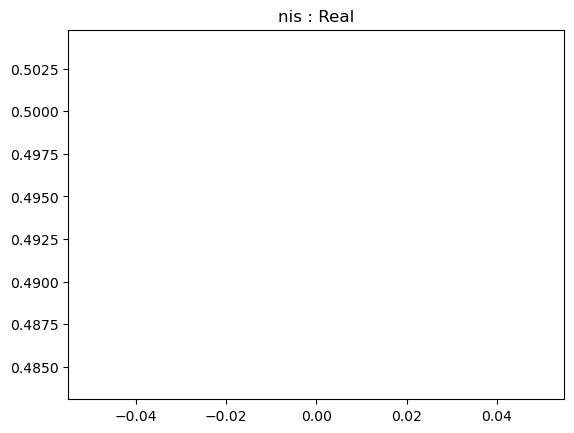

--- V = 2.1 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


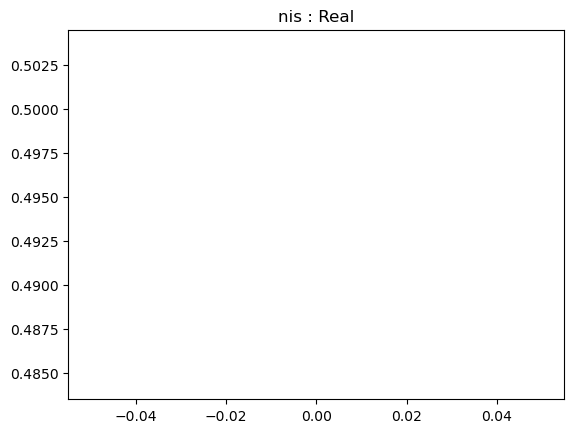

--- V = 2.2 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


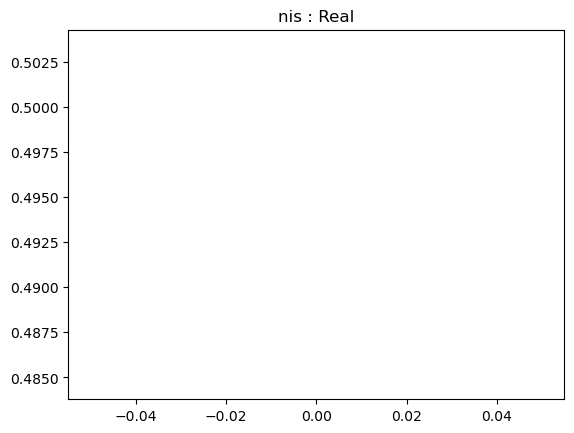

--- V = 2.3000000000000003 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


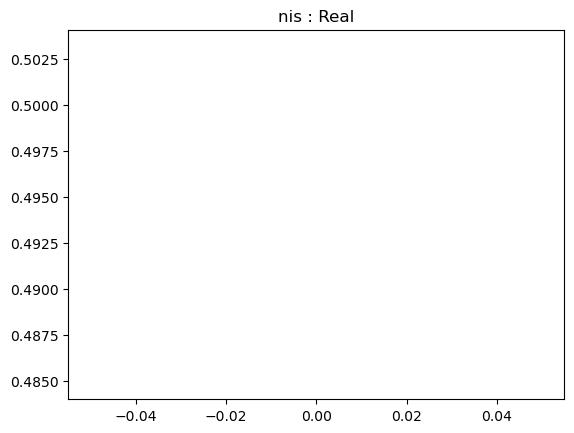

--- V = 2.4000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


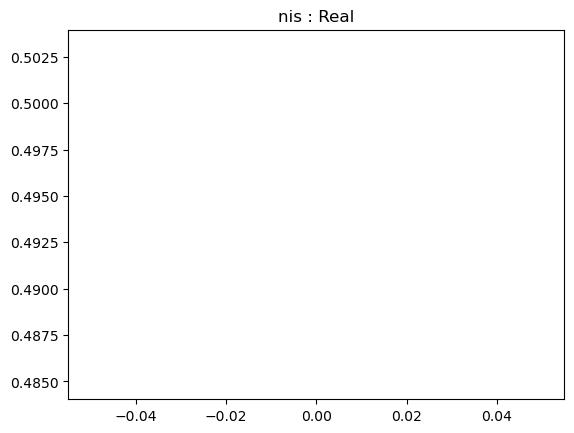

--- V = 2.5000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


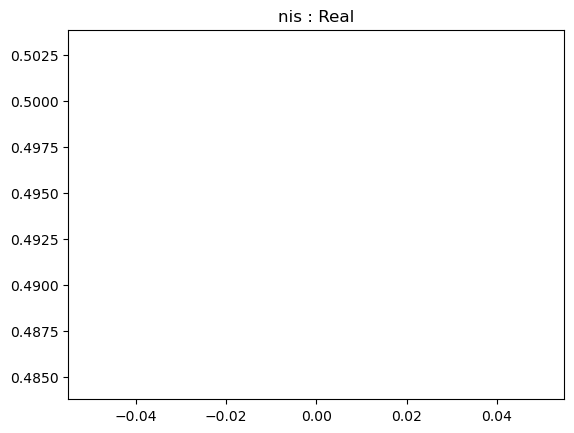

--- V = 2.6 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


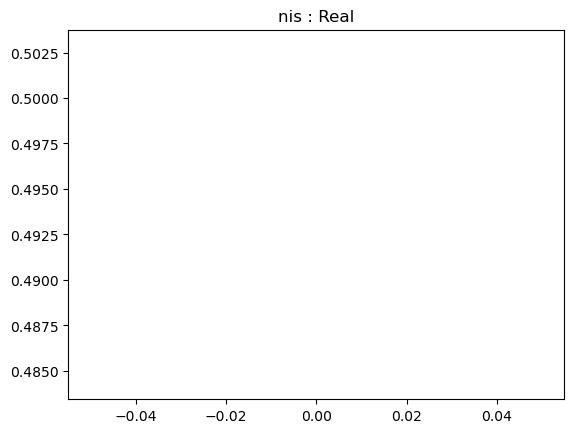

--- V = 2.7 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


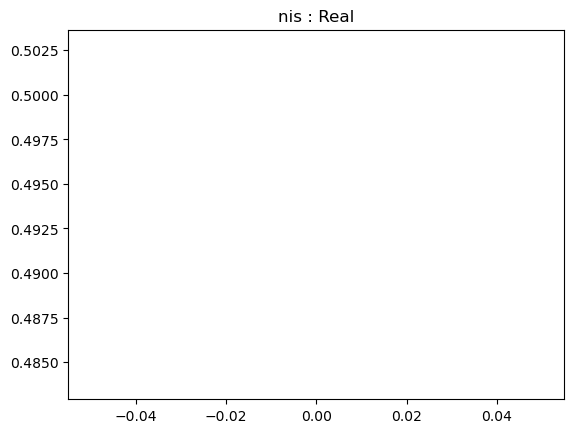

--- V = 2.8000000000000003 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


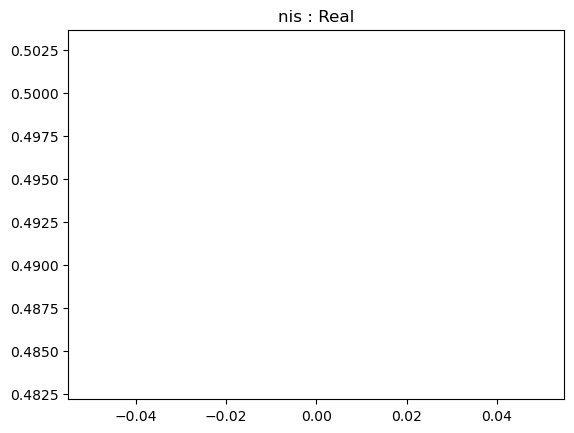

--- V = 2.9000000000000004 ---
[0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


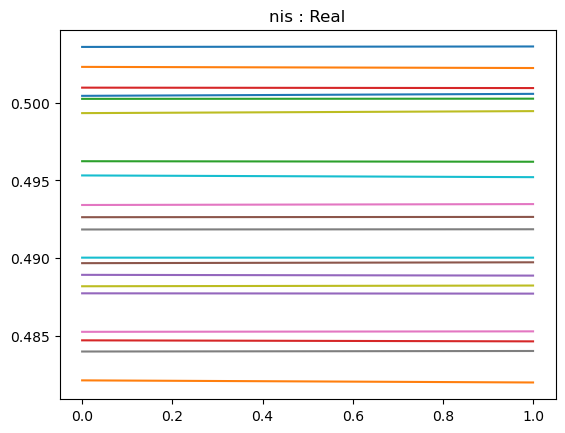

--- V = 3.0000000000000004 ---
[0.002 0.001 0.002 0.    0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.    0.001 0.001 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


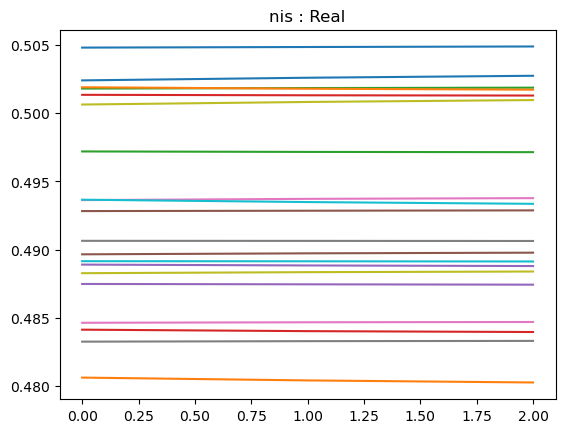

--- V = 3.1 ---
[0.003 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.002 0.
 0.001 0.    0.    0.    0.    0.002 0.002 0.002]
[0.002 0.002 0.001 0.    0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.    0.    0.001 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


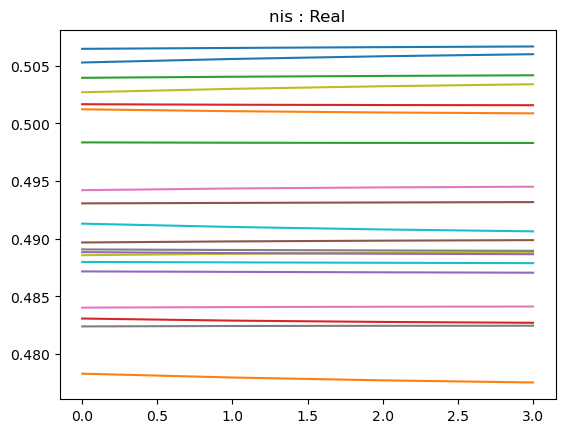

--- V = 3.2 ---
[0.003 0.003 0.003 0.001 0.    0.    0.    0.001 0.    0.001 0.002 0.
 0.001 0.    0.    0.    0.    0.002 0.003 0.003]
[0.003 0.002 0.002 0.001 0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.    0.001 0.002 0.002]
[0.002 0.002 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


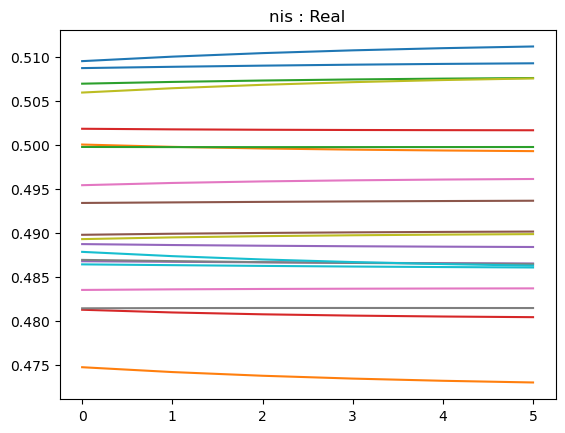

--- V = 3.3000000000000003 ---
[0.005 0.004 0.003 0.002 0.    0.    0.    0.001 0.    0.002 0.002 0.001
 0.002 0.    0.    0.    0.001 0.003 0.003 0.004]
[0.004 0.003 0.002 0.002 0.    0.    0.    0.    0.    0.001 0.002 0.001
 0.001 0.    0.    0.    0.001 0.002 0.003 0.003]
[0.003 0.003 0.002 0.001 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.002 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


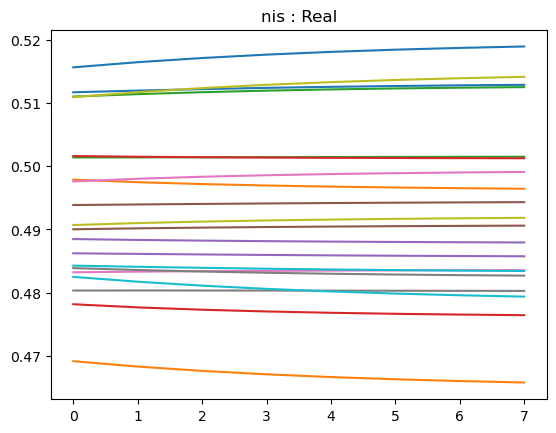

--- V = 3.4000000000000004 ---
[0.005 0.005 0.004 0.003 0.    0.    0.    0.001 0.001 0.002 0.003 0.002
 0.002 0.    0.    0.    0.002 0.003 0.004 0.005]
[0.004 0.004 0.003 0.003 0.    0.    0.    0.    0.001 0.001 0.002 0.002
 0.001 0.    0.    0.    0.002 0.002 0.004 0.004]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.001 0.001 0.002 0.001
 0.    0.    0.    0.    0.002 0.002 0.003 0.003]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.001 0.001 0.003 0.003]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0

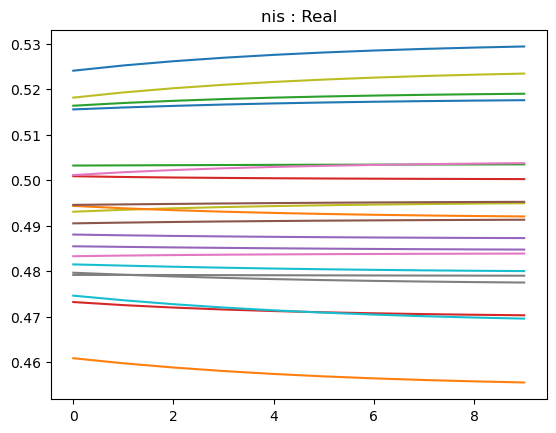

--- V = 3.5000000000000004 ---
[0.004 0.005 0.003 0.004 0.    0.    0.    0.    0.001 0.002 0.002 0.003
 0.001 0.    0.    0.    0.002 0.003 0.003 0.005]
[0.004 0.004 0.002 0.003 0.    0.    0.    0.    0.001 0.001 0.002 0.002
 0.    0.    0.    0.    0.002 0.002 0.003 0.004]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.002
 0.    0.    0.    0.    0.001 0.002 0.003 0.003]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0

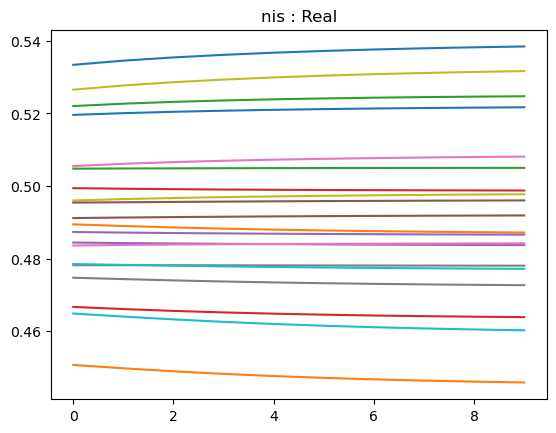

--- V = 3.6 ---
[0.001 0.003 0.001 0.003 0.    0.    0.    0.    0.    0.    0.    0.002
 0.    0.    0.    0.    0.    0.001 0.    0.003]
[0.001 0.002 0.001 0.002 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.    0.    0.    0.    0.001 0.002]
[0.001 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


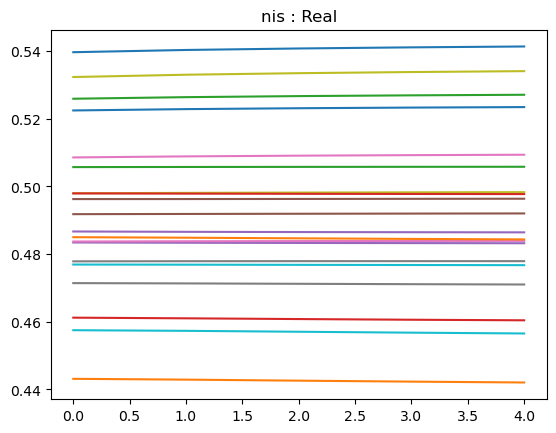

--- V = 3.7 ---
[0.002 0.    0.    0.001 0.    0.    0.    0.    0.001 0.001 0.    0.001
 0.    0.    0.    0.    0.001 0.    0.002 0.   ]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


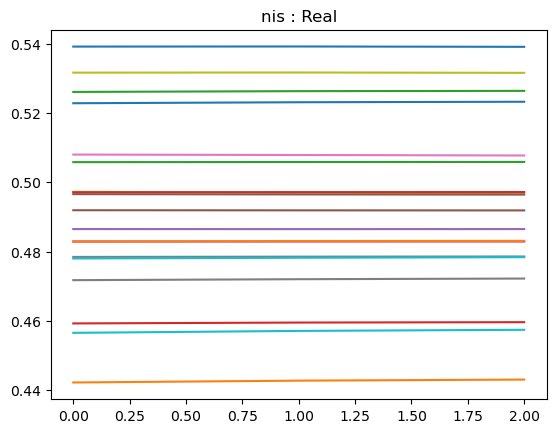

--- V = 3.8000000000000003 ---
[0.006 0.004 0.003 0.    0.    0.    0.002 0.001 0.003 0.003 0.002 0.
 0.    0.    0.    0.    0.004 0.003 0.006 0.003]
[0.004 0.003 0.002 0.001 0.    0.    0.001 0.    0.002 0.002 0.001 0.
 0.    0.    0.    0.    0.003 0.003 0.004 0.003]
[0.003 0.003 0.001 0.001 0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.002 0.002 0.003 0.003]
[0.003 0.003 0.001 0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.002 0.002 0.003 0.003]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.002 0.001 0.002 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.002 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.

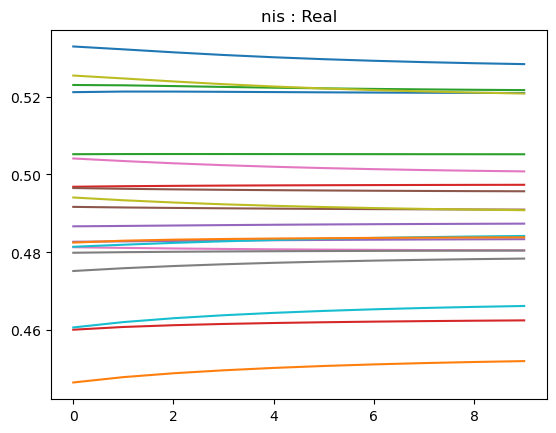

--- V = 3.9000000000000004 ---
[0.008 0.004 0.005 0.    0.    0.    0.002 0.002 0.003 0.004 0.003 0.
 0.001 0.    0.    0.    0.004 0.004 0.008 0.004]
[0.006 0.004 0.003 0.001 0.    0.    0.001 0.001 0.003 0.003 0.002 0.
 0.    0.    0.    0.    0.003 0.003 0.005 0.004]
[0.004 0.003 0.002 0.001 0.    0.    0.    0.    0.002 0.002 0.001 0.
 0.    0.    0.    0.    0.003 0.002 0.004 0.003]
[0.003 0.003 0.001 0.001 0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.002 0.002 0.003 0.003]
[0.003 0.002 0.001 0.    0.    0.    0.    0.    0.002 0.001 0.    0.
 0.    0.    0.    0.    0.002 0.002 0.003 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.

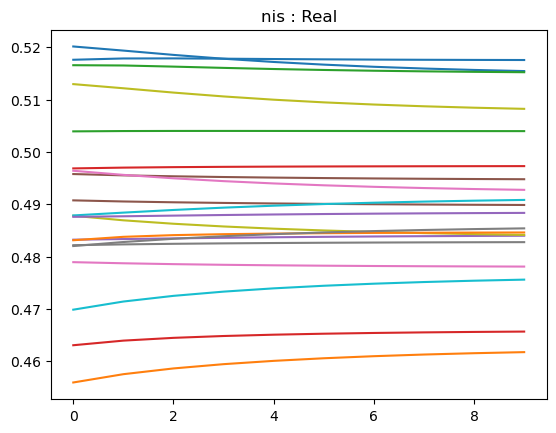

--- V = 4.0 ---
[0.008 0.002 0.005 0.    0.    0.    0.001 0.002 0.002 0.003 0.003 0.002
 0.001 0.    0.    0.    0.004 0.003 0.007 0.002]
[0.005 0.003 0.003 0.    0.    0.    0.    0.001 0.002 0.002 0.002 0.
 0.    0.    0.    0.    0.003 0.002 0.005 0.003]
[0.003 0.002 0.002 0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.002 0.002 0.003 0.002]
[0.002 0.002 0.001 0.    0.    0.    0.    0.    0.002 0.001 0.    0.
 0.    0.    0.    0.    0.002 0.001 0.002 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.001 0.001]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


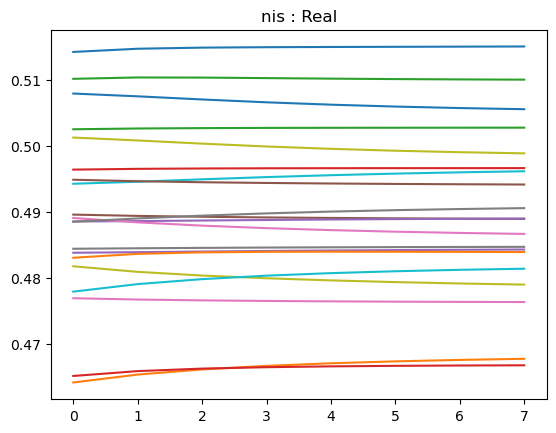

--- V = 4.1 ---
[0.006 0.001 0.004 0.001 0.    0.    0.    0.001 0.001 0.003 0.003 0.002
 0.001 0.001 0.    0.    0.002 0.003 0.005 0.001]
[0.004 0.001 0.002 0.    0.    0.    0.    0.    0.002 0.002 0.001 0.
 0.    0.    0.    0.    0.002 0.002 0.003 0.001]
[0.002 0.001 0.001 0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.002 0.001 0.002 0.001]
[0.002 0.001 0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.    0.002 0.001]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


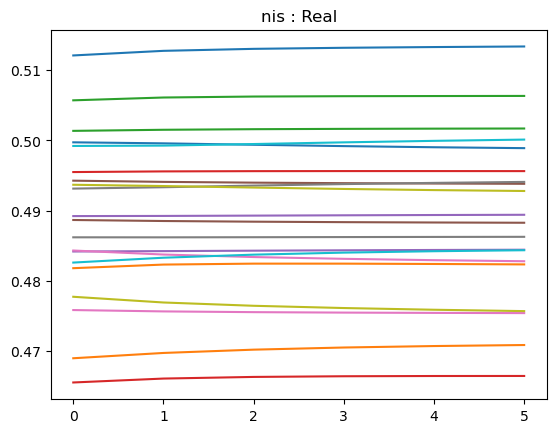

--- V = 4.2 ---
[0.004 0.    0.003 0.002 0.    0.    0.    0.001 0.    0.003 0.002 0.002
 0.001 0.001 0.    0.    0.001 0.002 0.004 0.   ]
[0.003 0.    0.002 0.    0.    0.    0.    0.    0.001 0.002 0.    0.001
 0.    0.    0.    0.    0.001 0.001 0.002 0.   ]
[0.002 0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.    0.001 0.   ]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


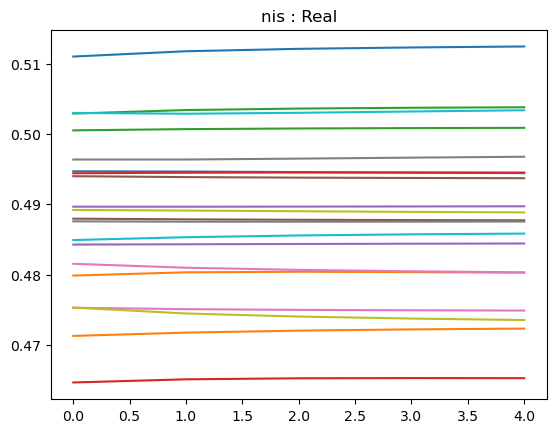

--- V = 4.3 ---
[0.003 0.    0.003 0.002 0.    0.    0.    0.001 0.    0.003 0.002 0.003
 0.    0.001 0.    0.    0.    0.002 0.002 0.   ]
[0.002 0.    0.001 0.    0.    0.    0.    0.    0.    0.001 0.    0.001
 0.    0.    0.    0.    0.    0.001 0.002 0.   ]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


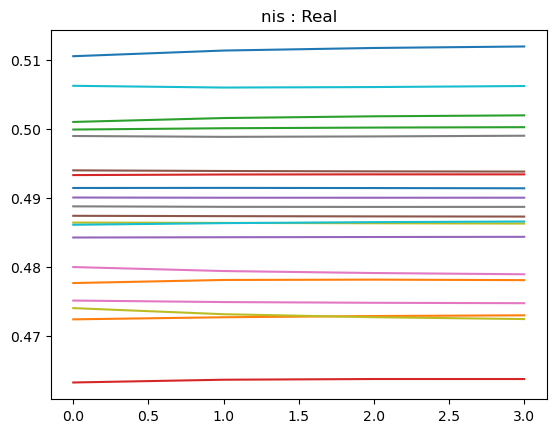

--- V = 4.3999999999999995 ---
[0.002 0.    0.002 0.002 0.    0.    0.    0.001 0.001 0.003 0.001 0.003
 0.    0.001 0.    0.    0.    0.002 0.002 0.   ]
[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001
 0.    0.    0.    0.    0.    0.001 0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


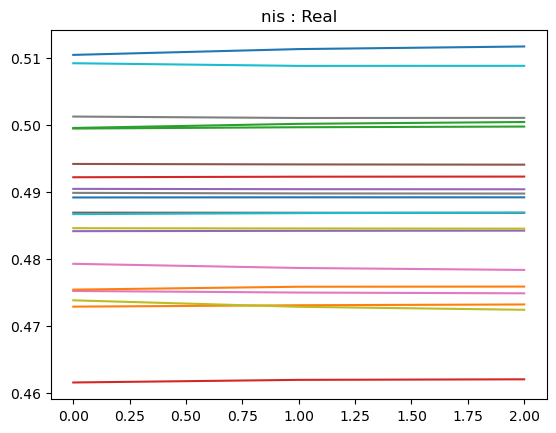

--- V = 4.5 ---
[0.002 0.    0.002 0.002 0.    0.    0.    0.001 0.003 0.003 0.    0.002
 0.    0.001 0.    0.    0.001 0.002 0.001 0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001
 0.    0.    0.    0.    0.    0.001 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


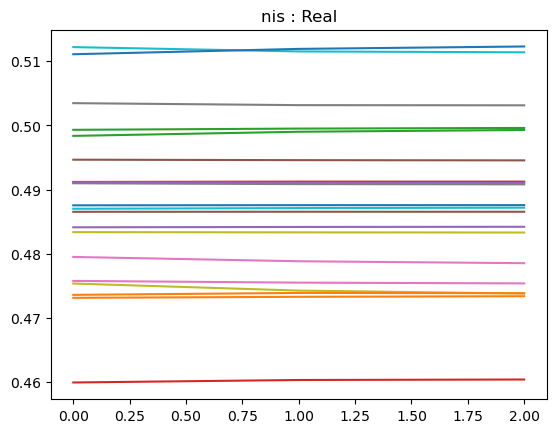

--- V = 4.6 ---
[0.001 0.    0.002 0.002 0.    0.    0.002 0.001 0.007 0.004 0.002 0.001
 0.    0.    0.002 0.001 0.003 0.003 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.    0.001 0.001
 0.    0.    0.    0.    0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


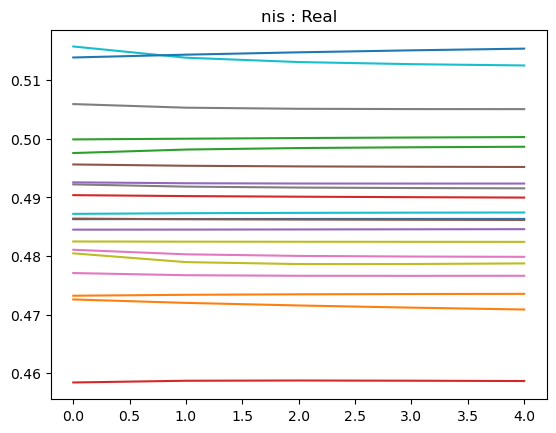

--- V = 4.7 ---
[0.001 0.    0.    0.001 0.002 0.    0.004 0.001 0.015 0.003 0.007 0.
 0.002 0.    0.003 0.001 0.005 0.002 0.    0.   ]
[0.    0.    0.    0.002 0.    0.001 0.002 0.001 0.008 0.006 0.004 0.007
 0.001 0.002 0.002 0.    0.002 0.    0.    0.   ]
[0.    0.    0.    0.002 0.001 0.002 0.002 0.002 0.008 0.008 0.006 0.007
 0.001 0.002 0.002 0.001 0.002 0.001 0.    0.   ]
[0.    0.    0.    0.002 0.001 0.002 0.002 0.002 0.008 0.009 0.007 0.008
 0.002 0.002 0.002 0.002 0.002 0.002 0.    0.   ]
[0.    0.    0.001 0.002 0.002 0.002 0.002 0.002 0.009 0.011 0.008 0.01
 0.002 0.002 0.002 0.002 0.002 0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.002 0.002 0.003 0.011 0.012 0.01  0.011
 0.002 0.003 0.002 0.002 0.002 0.003 0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.003 0.003 0.003 0.012 0.014 0.012 0.013
 0.003 0.003 0.002 0.003 0.003 0.003 0.    0.   ]
[0.    0.    0.002 0.003 0.003 0.003 0.003 0.004 0.014 0.017 0.014 0.016
 0.003 0.004 0.003 0.003 0.003 0.004 0.    0.   ]
[0. 

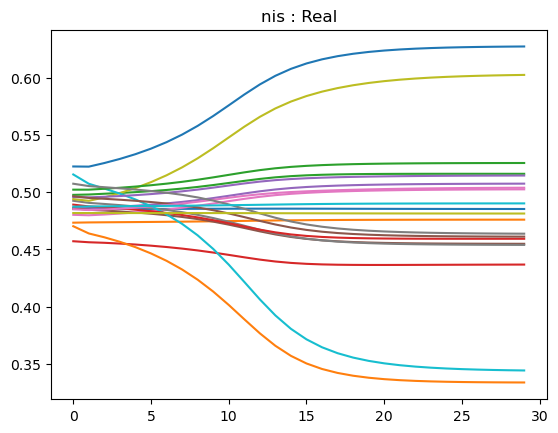

--- V = 4.8 ---
[0.002 0.    0.    0.    0.    0.002 0.    0.001 0.    0.007 0.    0.004
 0.    0.    0.    0.003 0.    0.003 0.001 0.   ]
[0.    0.    0.    0.    0.    0.001 0.    0.    0.001 0.004 0.    0.002
 0.    0.    0.    0.002 0.    0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.003 0.    0.001
 0.    0.    0.    0.001 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


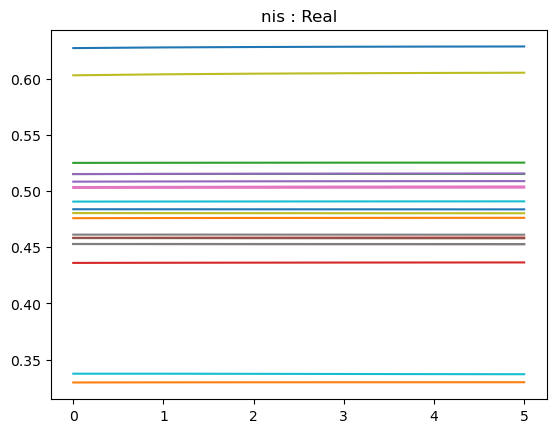

--- V = 4.9 ---
[0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


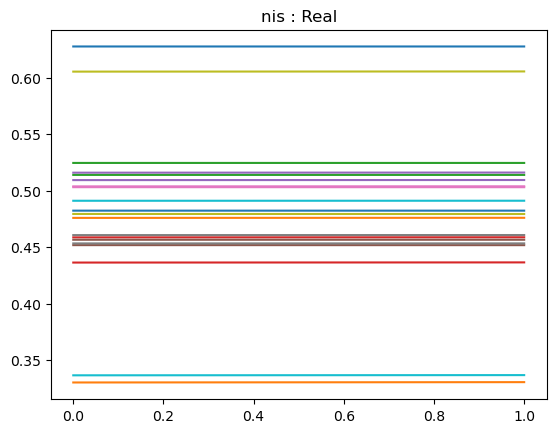

--- V = 5.0 ---
[0.001 0.    0.001 0.001 0.    0.    0.    0.002 0.    0.007 0.002 0.006
 0.    0.002 0.    0.    0.    0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.004 0.002 0.004
 0.    0.001 0.    0.    0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.002 0.003
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.001 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.001 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


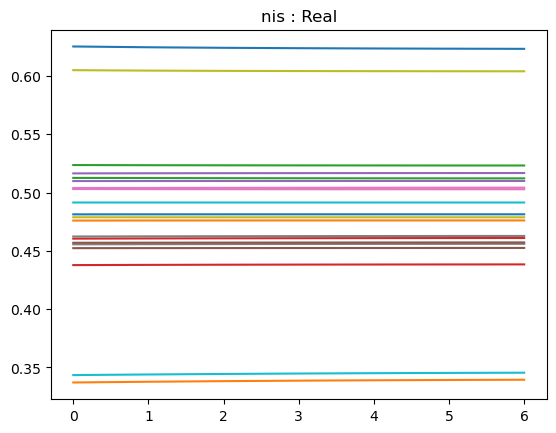

--- V = 5.1 ---
[0.    0.    0.002 0.004 0.    0.004 0.    0.005 0.003 0.02  0.005 0.021
 0.002 0.005 0.    0.004 0.    0.005 0.    0.   ]
[0.    0.    0.002 0.003 0.    0.003 0.    0.004 0.003 0.014 0.006 0.014
 0.002 0.003 0.    0.003 0.    0.003 0.    0.   ]
[0.    0.    0.002 0.002 0.    0.002 0.    0.003 0.004 0.011 0.006 0.011
 0.002 0.003 0.    0.002 0.    0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.    0.002 0.    0.002 0.003 0.009 0.006 0.009
 0.001 0.002 0.    0.002 0.    0.002 0.    0.   ]
[0.    0.    0.001 0.002 0.    0.002 0.    0.002 0.003 0.008 0.006 0.008
 0.001 0.002 0.    0.002 0.    0.002 0.    0.   ]
[0.    0.    0.001 0.002 0.    0.001 0.    0.002 0.003 0.007 0.005 0.007
 0.001 0.002 0.    0.001 0.    0.002 0.    0.   ]
[0.    0.    0.001 0.001 0.    0.001 0.    0.001 0.003 0.006 0.005 0.007
 0.001 0.002 0.    0.001 0.    0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.    0.001 0.    0.001 0.003 0.006 0.005 0.006
 0.    0.001 0.    0.001 0.    0.001 0.    0.   ]


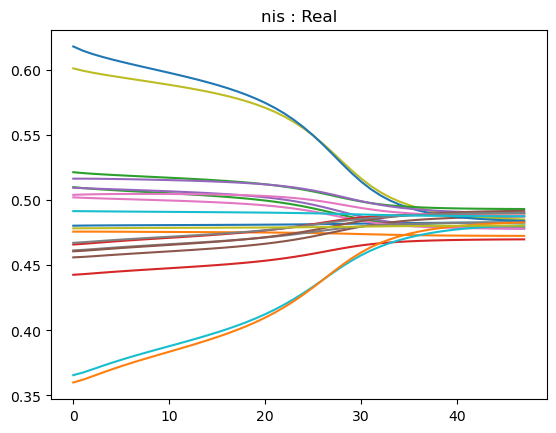

--- V = 5.2 ---
[0.    0.    0.    0.    0.002 0.    0.002 0.001 0.011 0.007 0.006 0.002
 0.002 0.    0.003 0.002 0.004 0.003 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.001 0.    0.006 0.003 0.003 0.
 0.001 0.    0.002 0.    0.002 0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.001 0.002 0.
 0.    0.    0.    0.    0.001 0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.    0.001 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


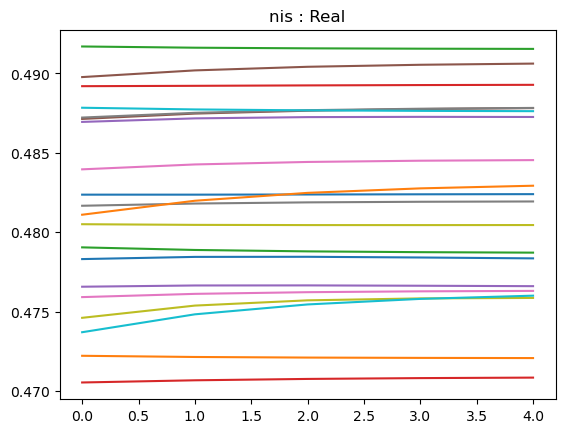

--- V = 5.3 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.005 0.004 0.002 0.
 0.    0.    0.002 0.001 0.002 0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.002 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


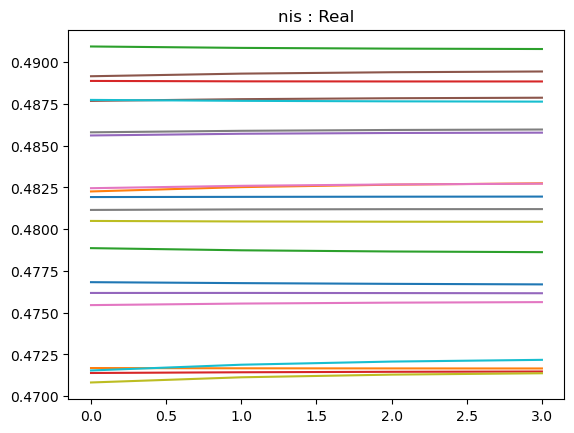

--- V = 5.4 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.003 0.    0.
 0.    0.    0.001 0.001 0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


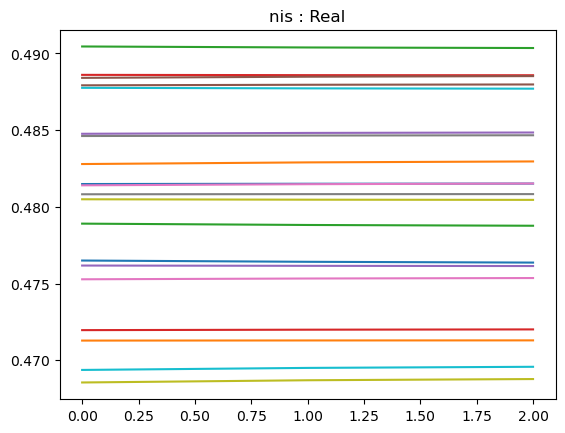

--- V = 5.5 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


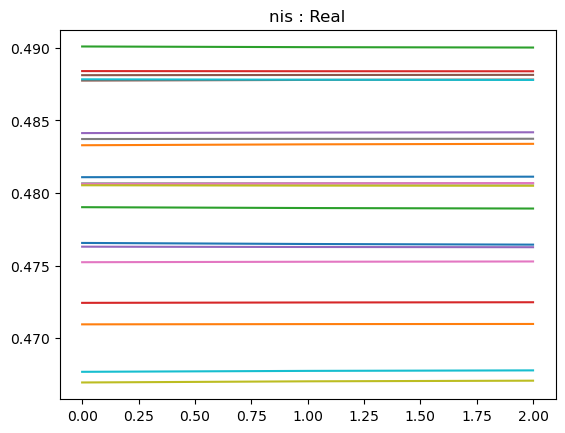

--- V = 5.6 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


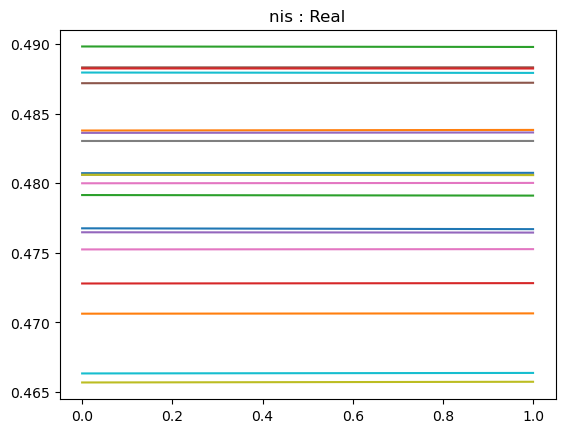

--- V = 5.7 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


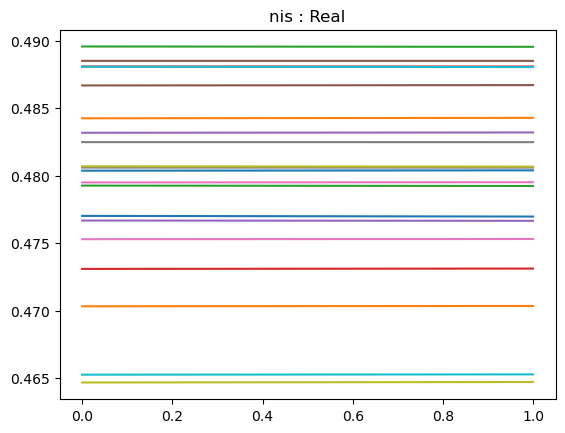

--- V = 5.8 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


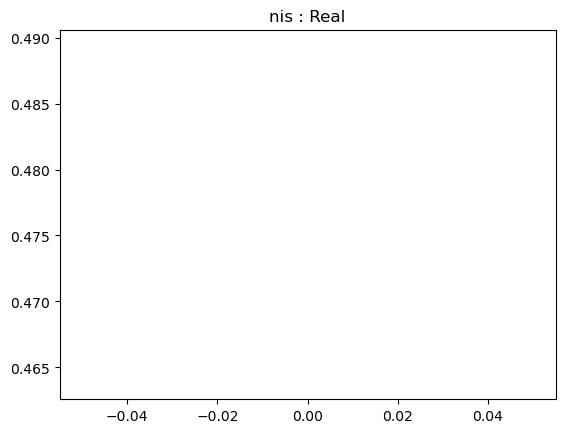

--- V = 5.9 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


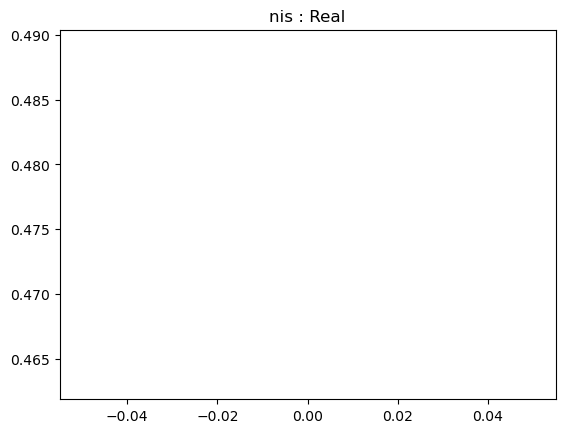

--- V = 6.0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


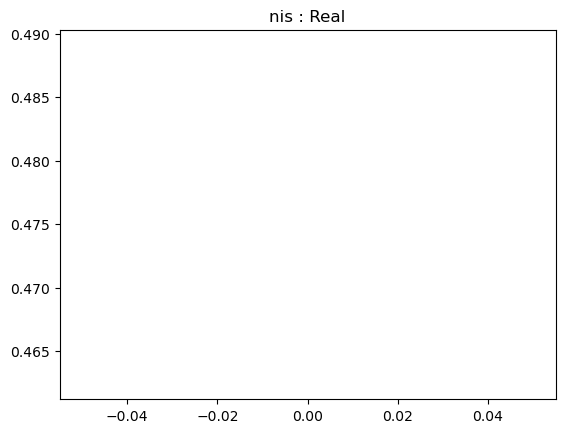

--- V = -0.1 ---
[0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


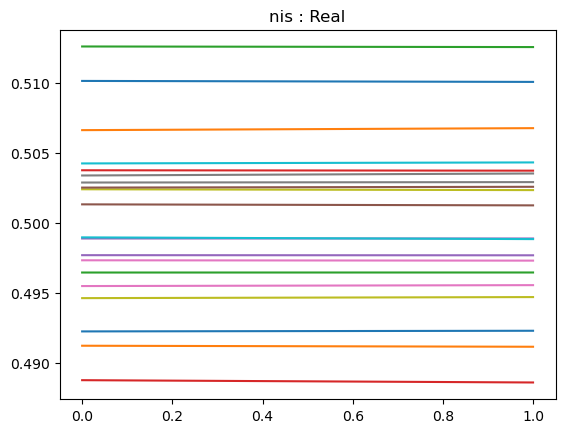

--- V = -0.2 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


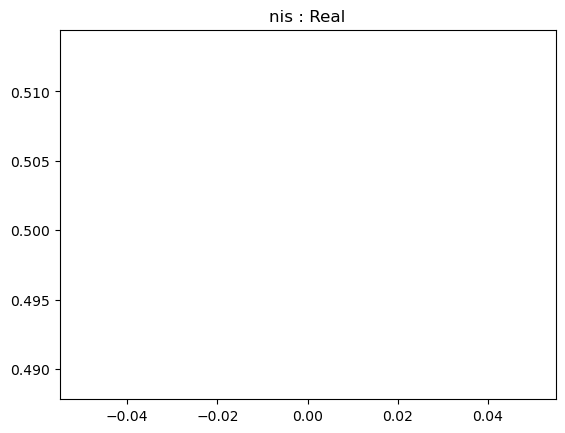

--- V = -0.30000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


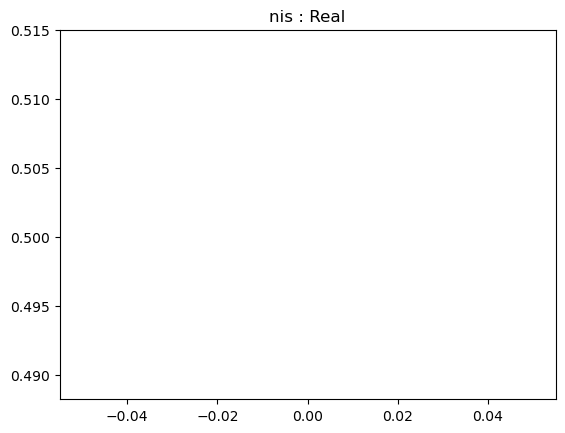

--- V = -0.4 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


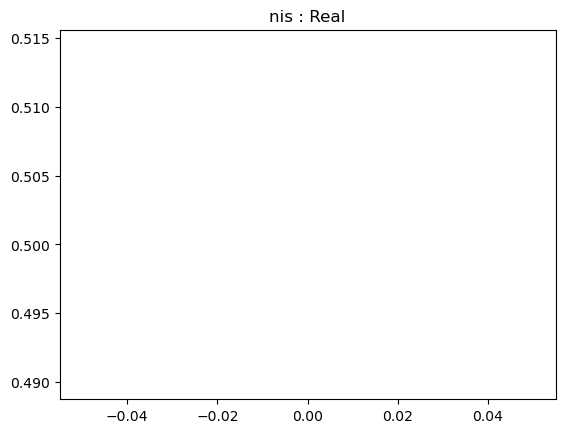

--- V = -0.5 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


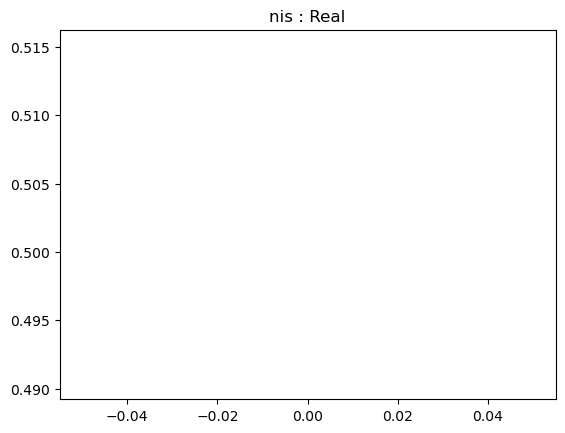

--- V = -0.6 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


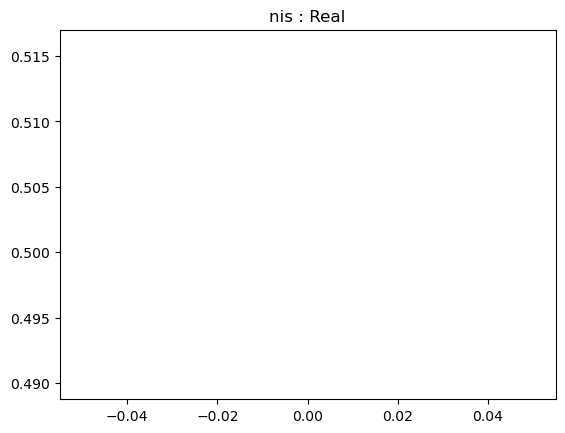

--- V = -0.7000000000000001 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


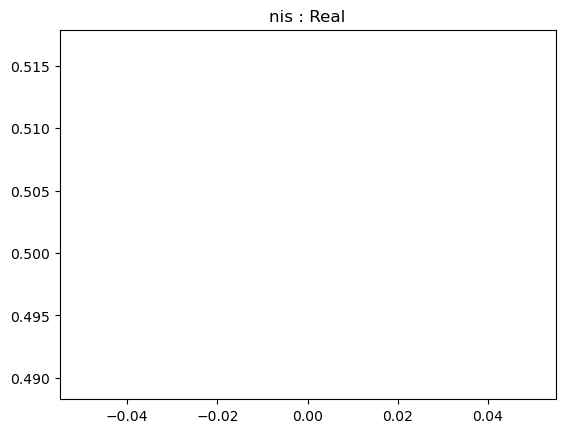

--- V = -0.8 ---
[0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


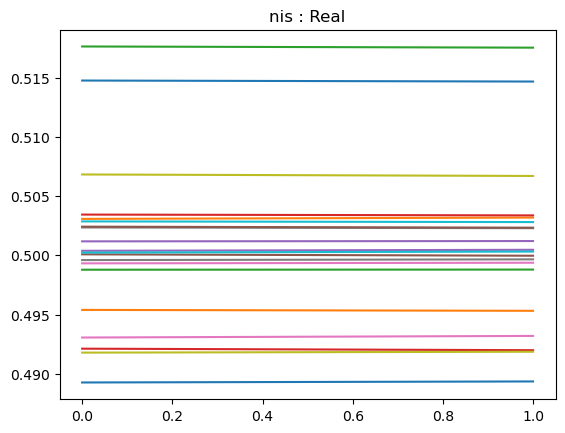

--- V = -0.9 ---
[0.001 0.    0.002 0.    0.002 0.    0.001 0.    0.001 0.    0.    0.001
 0.001 0.    0.002 0.    0.    0.001 0.    0.001]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


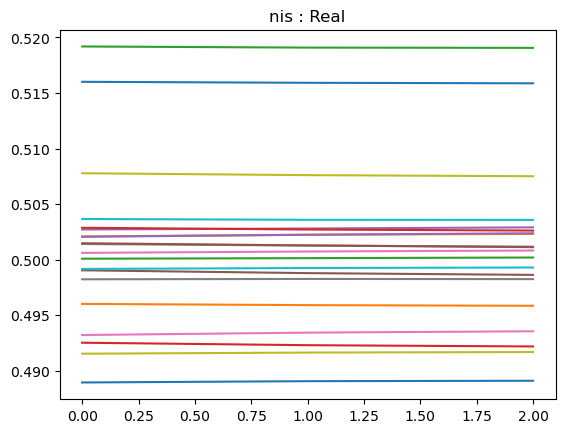

--- V = -1.0 ---
[0.002 0.    0.003 0.    0.003 0.002 0.002 0.002 0.001 0.    0.    0.001
 0.002 0.001 0.003 0.002 0.    0.002 0.    0.002]
[0.001 0.    0.002 0.    0.002 0.002 0.002 0.001 0.    0.    0.    0.
 0.002 0.001 0.002 0.002 0.    0.001 0.    0.   ]
[0.    0.    0.001 0.    0.002 0.001 0.001 0.001 0.    0.    0.    0.
 0.001 0.    0.002 0.001 0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


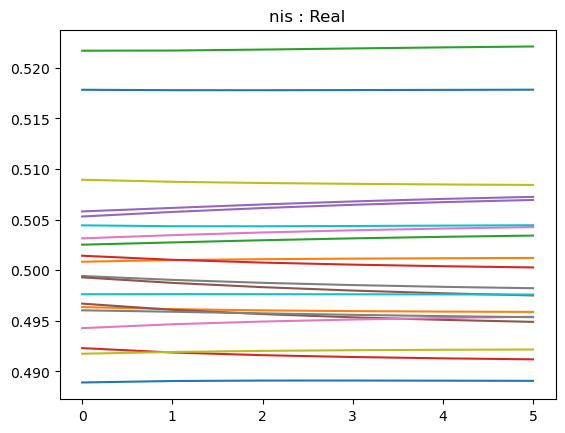

--- V = -1.1 ---
[0.003 0.    0.004 0.    0.005 0.004 0.004 0.003 0.002 0.    0.    0.002
 0.004 0.003 0.005 0.004 0.002 0.003 0.001 0.003]
[0.002 0.    0.003 0.002 0.004 0.004 0.003 0.003 0.    0.    0.    0.001
 0.003 0.003 0.004 0.004 0.002 0.003 0.001 0.002]
[0.001 0.    0.002 0.002 0.004 0.003 0.003 0.003 0.    0.    0.    0.
 0.003 0.002 0.004 0.003 0.002 0.002 0.    0.001]
[0.001 0.    0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0.    0.    0.002 0.001 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.002 0.001 0.    0.    0.    0.
 0.001 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.001 0.001 0.    0.    0.    0.
 0.001 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.  

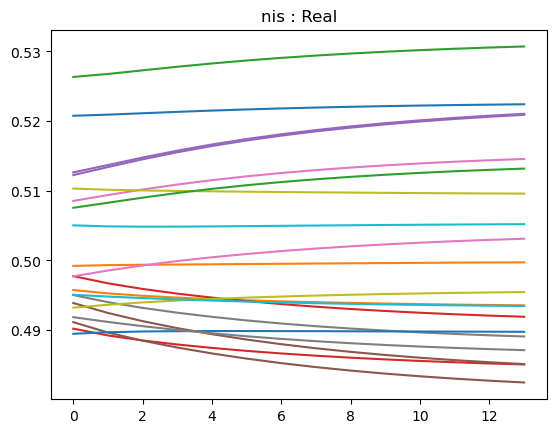

--- V = -1.2000000000000002 ---
[0.004 0.001 0.005 0.002 0.008 0.005 0.006 0.004 0.002 0.    0.001 0.002
 0.006 0.003 0.007 0.005 0.005 0.004 0.003 0.003]
[0.002 0.001 0.004 0.003 0.006 0.005 0.005 0.004 0.001 0.    0.001 0.001
 0.004 0.004 0.006 0.005 0.004 0.004 0.002 0.002]
[0.002 0.001 0.003 0.003 0.005 0.005 0.004 0.004 0.    0.    0.    0.
 0.004 0.003 0.005 0.005 0.004 0.003 0.002 0.002]
[0.002 0.001 0.003 0.003 0.005 0.004 0.004 0.003 0.    0.    0.    0.
 0.003 0.003 0.005 0.004 0.003 0.003 0.002 0.001]
[0.001 0.001 0.003 0.002 0.004 0.004 0.003 0.003 0.    0.    0.    0.
 0.003 0.003 0.004 0.004 0.003 0.003 0.001 0.001]
[0.001 0.001 0.002 0.002 0.004 0.004 0.003 0.003 0.    0.    0.    0.
 0.003 0.002 0.004 0.004 0.003 0.002 0.001 0.   ]
[0.    0.    0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.001 0.   ]
[0.    0.    0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0

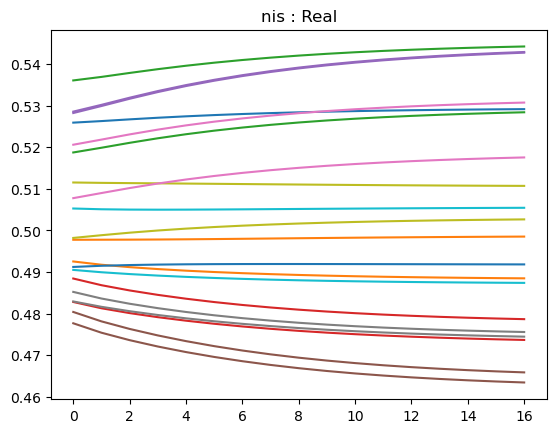

--- V = -1.3000000000000003 ---
[0.    0.    0.002 0.    0.002 0.    0.002 0.    0.    0.    0.    0.
 0.001 0.    0.002 0.    0.002 0.    0.001 0.   ]
[0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


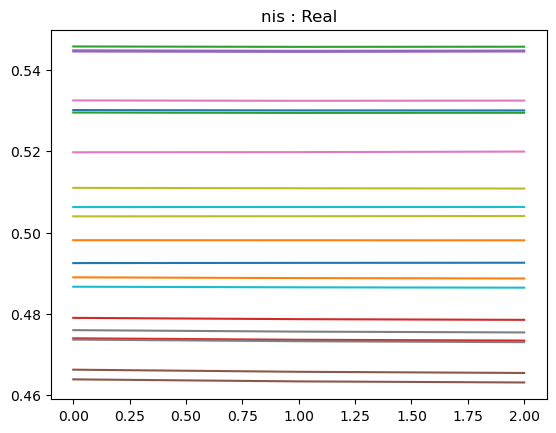

--- V = -1.4000000000000001 ---
[0.002 0.003 0.003 0.004 0.005 0.007 0.003 0.005 0.002 0.002 0.    0.
 0.004 0.005 0.005 0.007 0.002 0.003 0.001 0.002]
[0.002 0.002 0.003 0.004 0.005 0.005 0.003 0.004 0.    0.001 0.    0.
 0.004 0.004 0.005 0.005 0.002 0.003 0.001 0.001]
[0.002 0.002 0.003 0.003 0.004 0.004 0.003 0.003 0.    0.    0.    0.
 0.003 0.003 0.004 0.004 0.002 0.002 0.001 0.001]
[0.001 0.001 0.003 0.003 0.004 0.004 0.003 0.003 0.    0.    0.    0.
 0.003 0.003 0.004 0.004 0.002 0.002 0.001 0.   ]
[0.001 0.001 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.001 0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.002 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.001 0.001 0.    0.    0.    0.
 0.001 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0

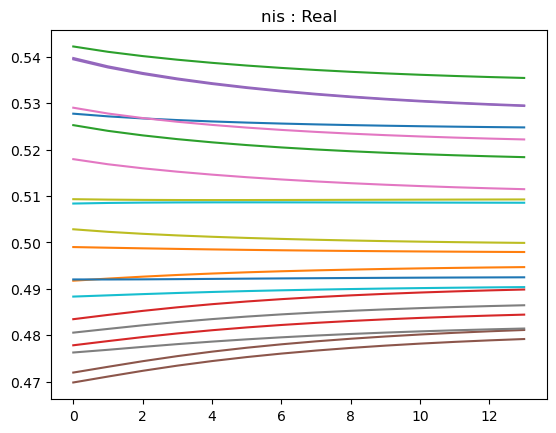

--- V = -1.5000000000000002 ---
[0.003 0.004 0.005 0.007 0.006 0.01  0.004 0.008 0.002 0.002 0.    0.002
 0.005 0.007 0.007 0.01  0.003 0.006 0.002 0.004]
[0.003 0.003 0.005 0.005 0.006 0.007 0.004 0.005 0.001 0.001 0.    0.
 0.004 0.005 0.006 0.007 0.003 0.005 0.002 0.003]
[0.002 0.002 0.004 0.004 0.005 0.006 0.003 0.004 0.    0.    0.    0.
 0.004 0.004 0.005 0.006 0.003 0.004 0.001 0.002]
[0.002 0.002 0.003 0.003 0.004 0.005 0.003 0.003 0.    0.    0.    0.
 0.003 0.003 0.004 0.004 0.003 0.003 0.001 0.001]
[0.001 0.001 0.003 0.003 0.003 0.004 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.004 0.002 0.002 0.    0.001]
[0.    0.    0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.002 0.001 0.002 0.    0.    0.    0.
 0.001 0.002 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.001 0.001 0.    0.    0.    0.
 0.001 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.  

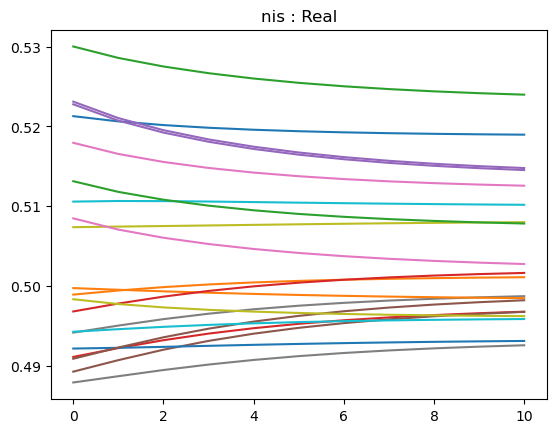

--- V = -1.6 ---
[0.002 0.002 0.003 0.003 0.002 0.006 0.    0.004 0.    0.    0.    0.001
 0.002 0.003 0.002 0.005 0.    0.004 0.    0.003]
[0.001 0.001 0.002 0.002 0.002 0.004 0.001 0.003 0.    0.    0.    0.
 0.002 0.002 0.002 0.003 0.    0.003 0.    0.002]
[0.    0.    0.002 0.002 0.002 0.002 0.    0.002 0.    0.    0.    0.
 0.001 0.002 0.002 0.002 0.    0.002 0.    0.   ]
[0.    0.    0.001 0.001 0.001 0.002 0.    0.001 0.    0.    0.    0.
 0.    0.001 0.001 0.002 0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


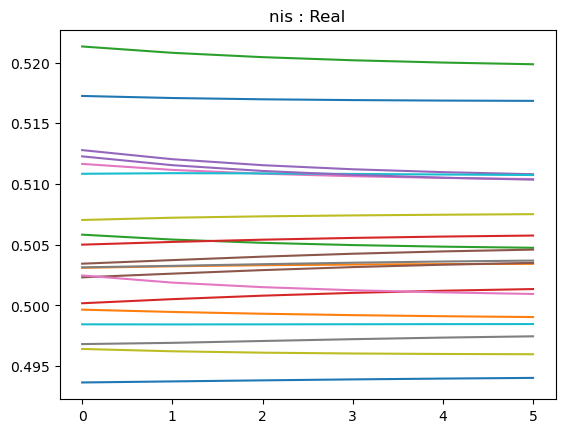

--- V = -1.7000000000000002 ---
[0.    0.    0.001 0.002 0.    0.003 0.    0.002 0.    0.    0.    0.
 0.    0.001 0.    0.003 0.    0.003 0.    0.002]
[0.    0.    0.001 0.001 0.    0.002 0.    0.001 0.    0.    0.    0.
 0.    0.    0.    0.002 0.    0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


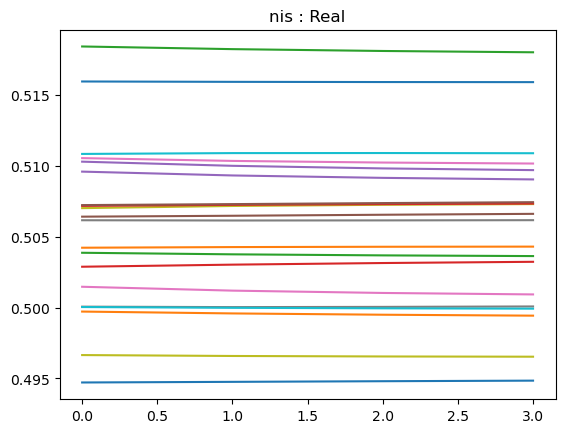

--- V = -1.8000000000000003 ---
[0.    0.    0.    0.    0.    0.002 0.    0.002 0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.002 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


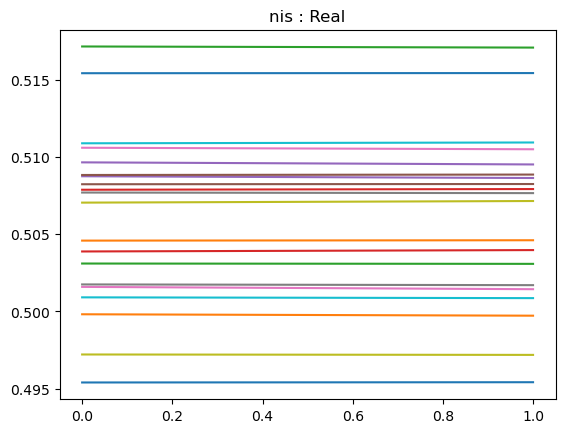

--- V = -1.9000000000000001 ---
[0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


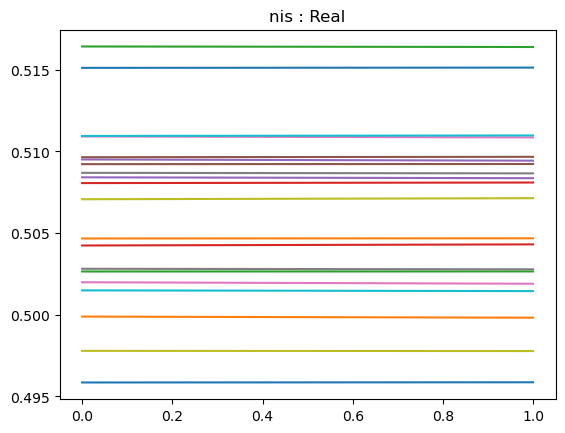

--- V = -2.0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


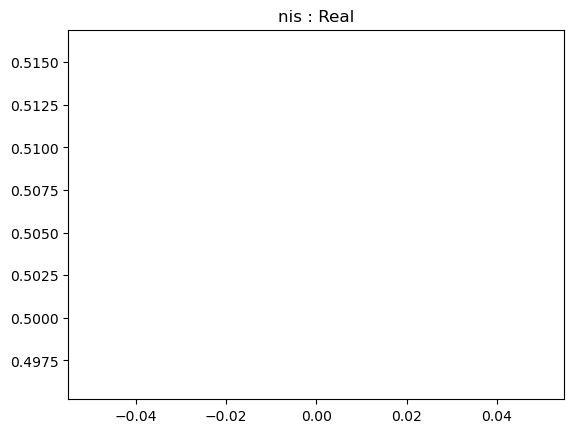

--- V = -2.1 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


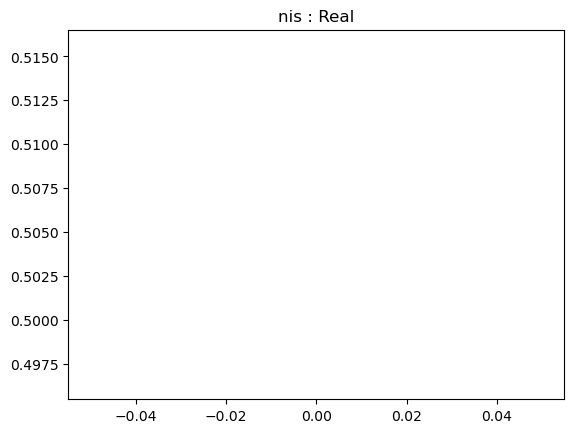

--- V = -2.2 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


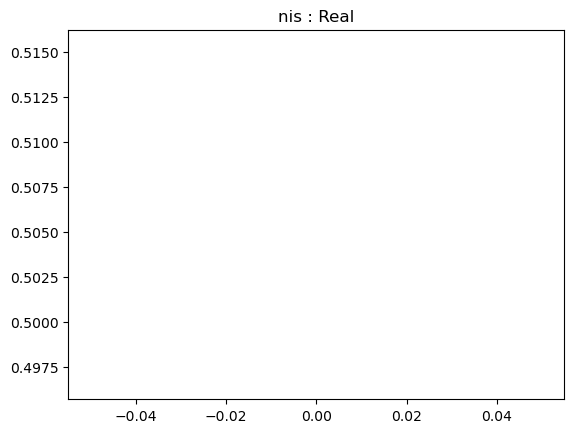

--- V = -2.3000000000000003 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


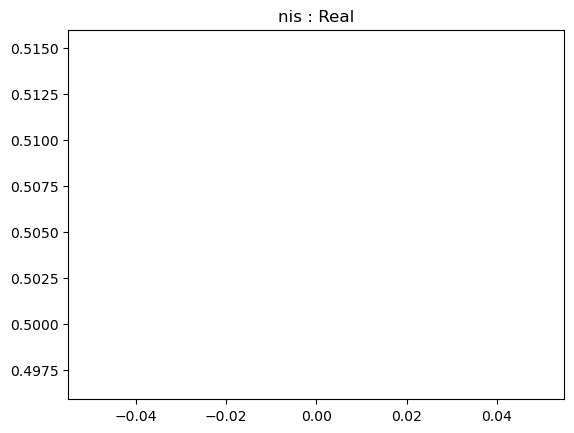

--- V = -2.4000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


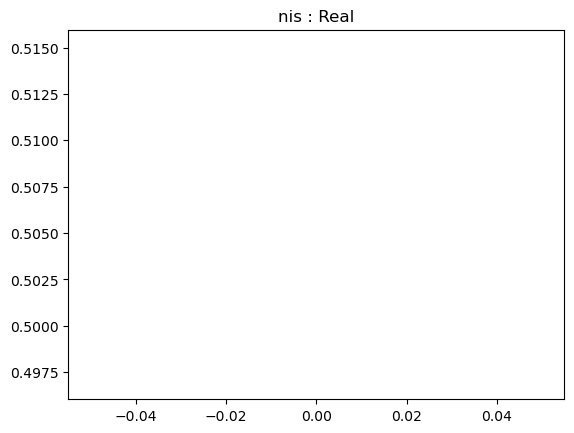

--- V = -2.5000000000000004 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


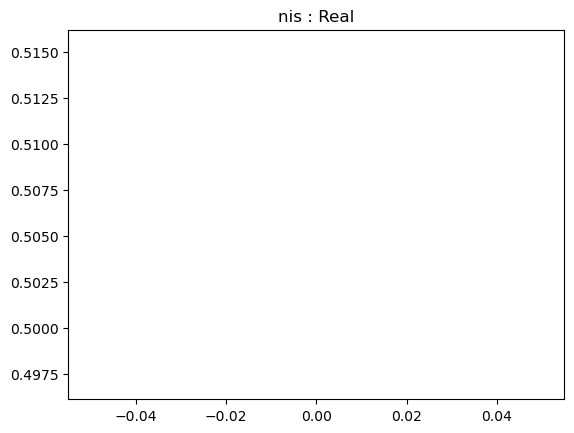

--- V = -2.6 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


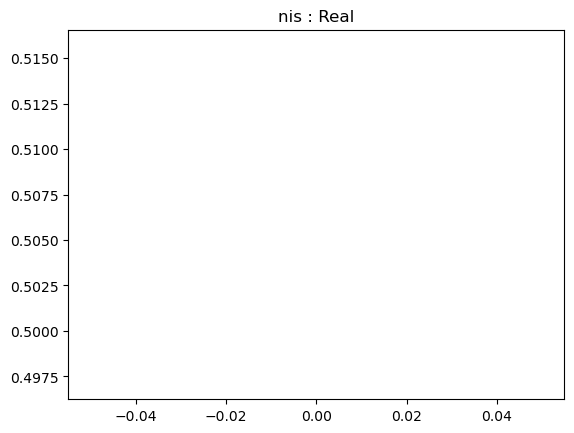

--- V = -2.7 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


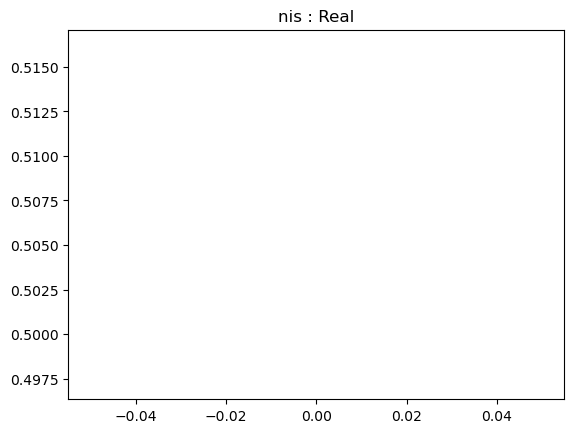

--- V = -2.8000000000000003 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


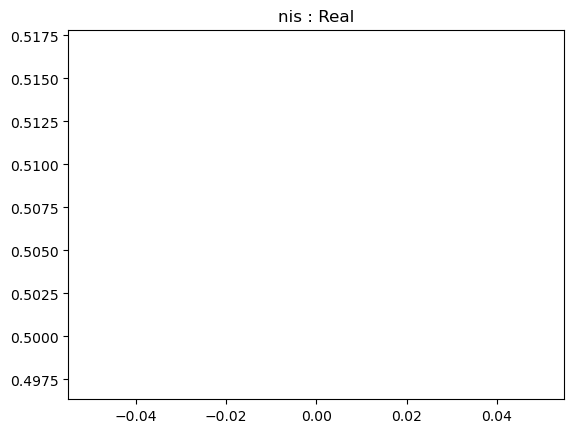

--- V = -2.9000000000000004 ---
[0.001 0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


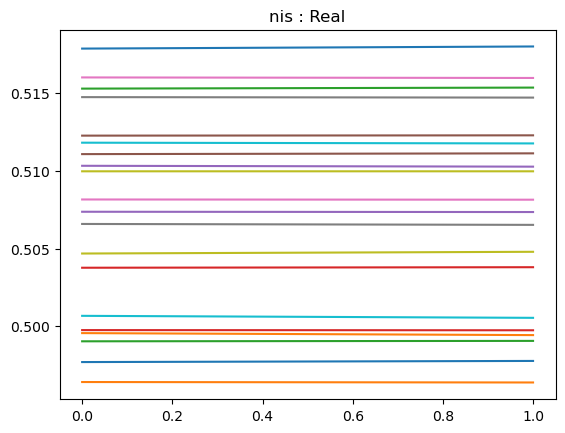

--- V = -3.0000000000000004 ---
[0.001 0.002 0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.    0.    0.001 0.    0.002 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


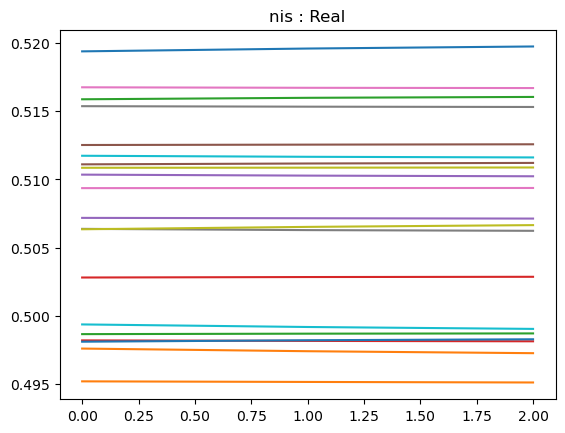

--- V = -3.1 ---
[0.002 0.003 0.    0.002 0.    0.    0.    0.    0.001 0.    0.    0.002
 0.    0.001 0.    0.    0.002 0.    0.002 0.002]
[0.002 0.002 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.    0.    0.    0.    0.002 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


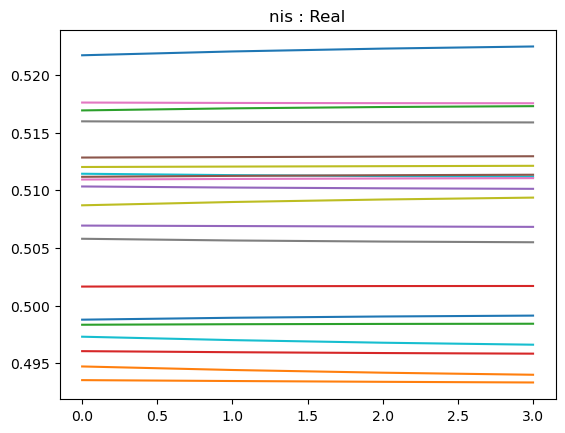

--- V = -3.2 ---
[0.003 0.003 0.001 0.003 0.    0.    0.001 0.    0.001 0.    0.    0.002
 0.    0.001 0.    0.    0.002 0.    0.003 0.003]
[0.002 0.003 0.001 0.002 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.    0.    0.001 0.    0.002 0.002]
[0.002 0.002 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


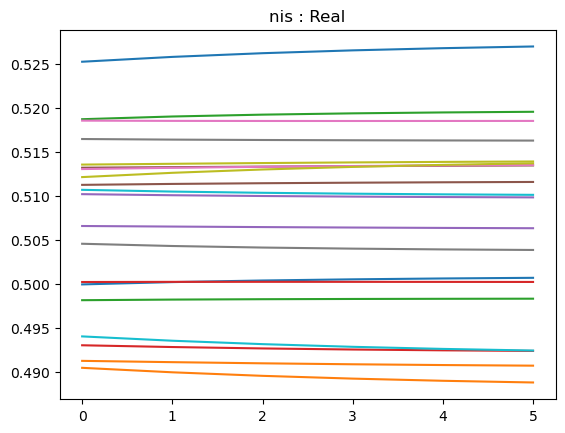

--- V = -3.3000000000000003 ---
[0.004 0.005 0.002 0.003 0.    0.    0.001 0.    0.002 0.    0.001 0.002
 0.    0.002 0.    0.    0.003 0.001 0.004 0.003]
[0.003 0.004 0.002 0.002 0.    0.    0.    0.    0.001 0.    0.001 0.002
 0.    0.001 0.    0.    0.002 0.001 0.003 0.003]
[0.003 0.003 0.001 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.002 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


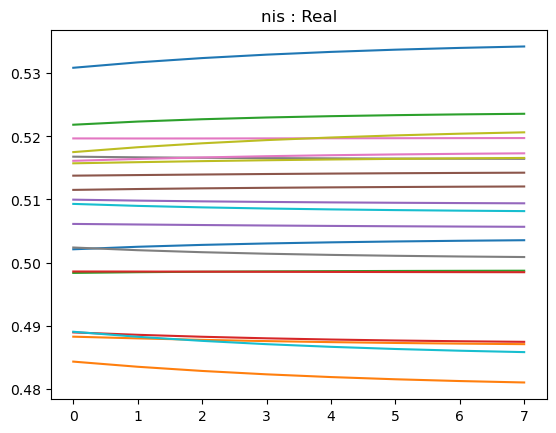

--- V = -3.4000000000000004 ---
[0.005 0.005 0.003 0.004 0.    0.    0.001 0.    0.002 0.001 0.002 0.003
 0.    0.002 0.    0.    0.003 0.002 0.005 0.004]
[0.004 0.004 0.003 0.003 0.    0.    0.    0.    0.001 0.001 0.002 0.002
 0.    0.001 0.    0.    0.002 0.002 0.004 0.004]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.001 0.001 0.001 0.002
 0.    0.    0.    0.    0.002 0.002 0.003 0.003]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.001 0.001 0.003 0.003]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.0

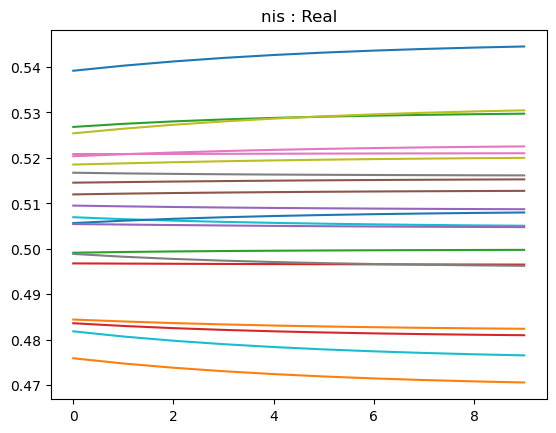

--- V = -3.5000000000000004 ---
[0.005 0.004 0.004 0.003 0.    0.    0.    0.    0.002 0.001 0.003 0.002
 0.    0.001 0.    0.    0.003 0.002 0.005 0.003]
[0.004 0.004 0.003 0.002 0.    0.    0.    0.    0.001 0.001 0.002 0.002
 0.    0.    0.    0.    0.002 0.002 0.004 0.003]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.    0.    0.002 0.001
 0.    0.    0.    0.    0.002 0.001 0.003 0.003]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.0

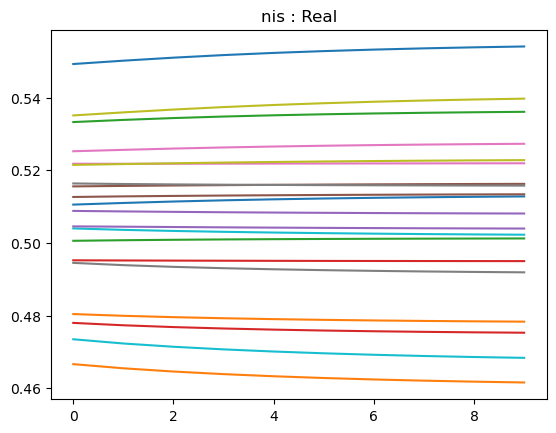

--- V = -3.6 ---
[0.003 0.001 0.003 0.001 0.    0.    0.    0.    0.    0.    0.002 0.
 0.    0.    0.    0.    0.001 0.    0.003 0.   ]
[0.002 0.001 0.002 0.001 0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.    0.    0.002 0.001]
[0.001 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


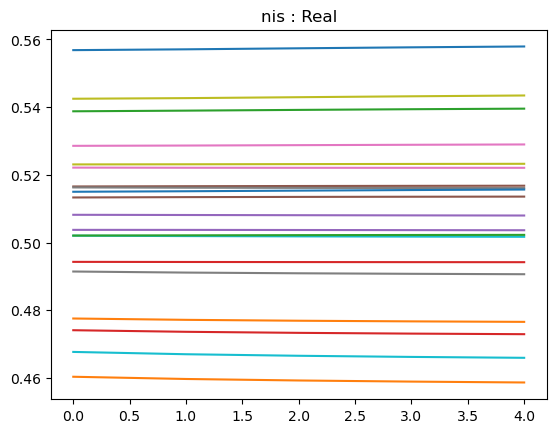

--- V = -3.7 ---
[0.    0.002 0.001 0.    0.    0.    0.    0.    0.001 0.001 0.001 0.
 0.    0.    0.    0.    0.    0.001 0.    0.002]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


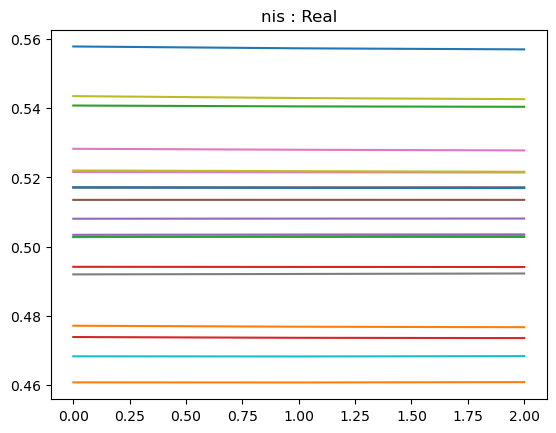

--- V = -3.8000000000000003 ---
[0.004 0.006 0.    0.003 0.    0.    0.001 0.002 0.003 0.003 0.    0.002
 0.    0.    0.    0.    0.003 0.004 0.003 0.006]
[0.003 0.004 0.001 0.002 0.    0.    0.    0.001 0.002 0.002 0.    0.001
 0.    0.    0.    0.    0.003 0.003 0.003 0.004]
[0.003 0.003 0.001 0.001 0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.002 0.002 0.003 0.003]
[0.003 0.003 0.    0.001 0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.002 0.002 0.003 0.003]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.002 0.002 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.001 0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.001 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0

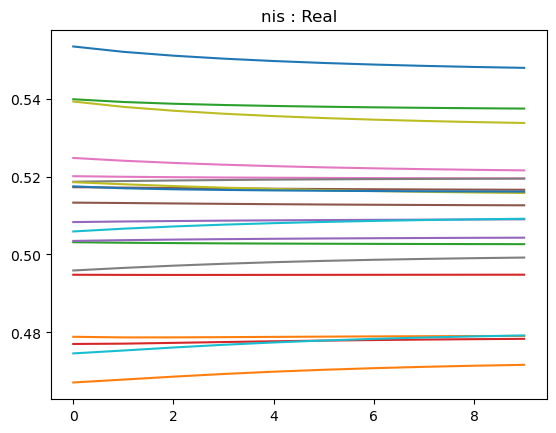

--- V = -3.9000000000000004 ---
[0.004 0.008 0.    0.005 0.    0.    0.002 0.002 0.004 0.003 0.    0.003
 0.    0.001 0.    0.    0.004 0.004 0.004 0.008]
[0.004 0.006 0.001 0.003 0.    0.    0.001 0.001 0.003 0.003 0.    0.002
 0.    0.    0.    0.    0.003 0.003 0.004 0.005]
[0.003 0.004 0.001 0.002 0.    0.    0.    0.    0.002 0.002 0.    0.001
 0.    0.    0.    0.    0.002 0.003 0.003 0.004]
[0.003 0.003 0.001 0.001 0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.002 0.002 0.003 0.003]
[0.002 0.003 0.    0.001 0.    0.    0.    0.    0.001 0.002 0.    0.
 0.    0.    0.    0.    0.002 0.002 0.002 0.003]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]

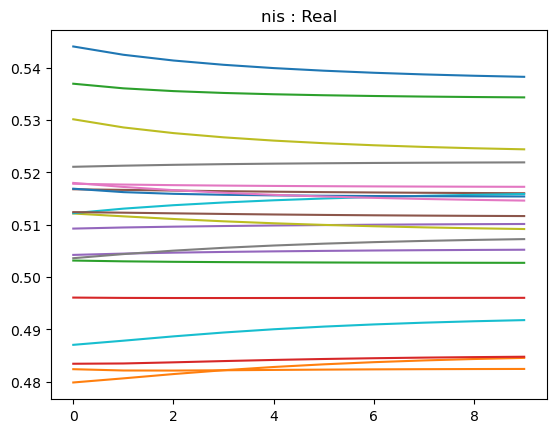

--- V = -4.0 ---
[0.002 0.008 0.    0.005 0.    0.    0.002 0.001 0.003 0.002 0.002 0.003
 0.    0.001 0.    0.    0.003 0.004 0.002 0.007]
[0.003 0.005 0.    0.003 0.    0.    0.001 0.    0.002 0.002 0.    0.002
 0.    0.    0.    0.    0.002 0.003 0.003 0.005]
[0.002 0.003 0.    0.002 0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.002 0.002 0.002 0.003]
[0.002 0.002 0.    0.001 0.    0.    0.    0.    0.001 0.002 0.    0.
 0.    0.    0.    0.    0.001 0.002 0.002 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.
 0.    0.    0.    0.    0.    0.001 0.001 0.001]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


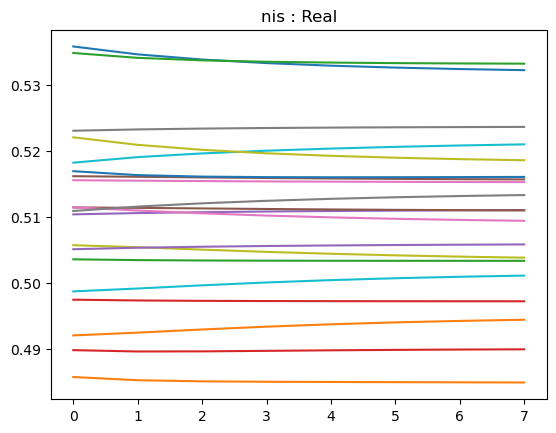

--- V = -4.1 ---
[0.001 0.006 0.001 0.004 0.    0.    0.001 0.    0.003 0.001 0.002 0.003
 0.001 0.001 0.    0.    0.003 0.002 0.001 0.005]
[0.001 0.004 0.    0.002 0.    0.    0.    0.    0.002 0.002 0.    0.001
 0.    0.    0.    0.    0.002 0.002 0.001 0.003]
[0.001 0.002 0.    0.001 0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.001 0.002 0.001 0.002]
[0.001 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.001 0.001 0.002]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


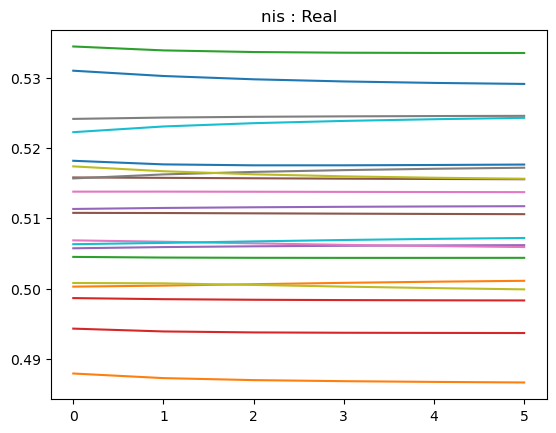

--- V = -4.2 ---
[0.    0.004 0.002 0.003 0.    0.    0.001 0.    0.003 0.    0.002 0.002
 0.001 0.001 0.    0.    0.002 0.001 0.    0.004]
[0.    0.003 0.    0.002 0.    0.    0.    0.    0.002 0.001 0.001 0.
 0.    0.    0.    0.    0.001 0.001 0.    0.002]
[0.    0.002 0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.001 0.    0.001]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


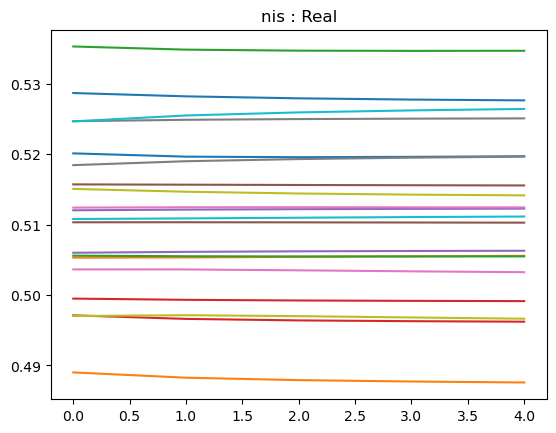

--- V = -4.3 ---
[0.    0.003 0.002 0.003 0.    0.    0.001 0.    0.003 0.    0.003 0.002
 0.001 0.    0.    0.    0.002 0.    0.    0.002]
[0.    0.002 0.    0.001 0.    0.    0.    0.    0.001 0.    0.001 0.
 0.    0.    0.    0.    0.001 0.    0.    0.002]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


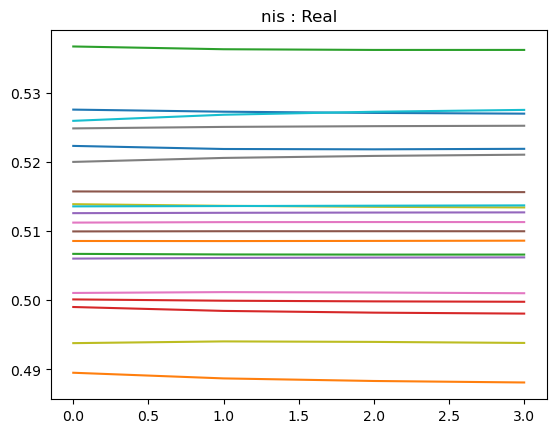

--- V = -4.3999999999999995 ---
[0.    0.002 0.002 0.002 0.    0.    0.001 0.    0.003 0.001 0.003 0.001
 0.001 0.    0.    0.    0.002 0.    0.    0.002]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.001 0.    0.001 0.
 0.    0.    0.    0.    0.001 0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


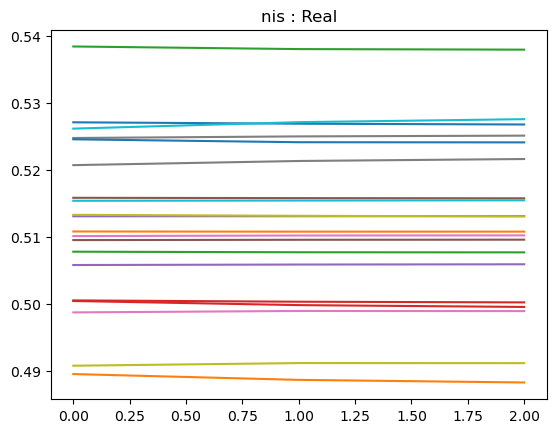

--- V = -4.5 ---
[0.    0.002 0.002 0.002 0.    0.    0.001 0.    0.003 0.003 0.002 0.
 0.001 0.    0.    0.    0.002 0.001 0.    0.001]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001 0.
 0.    0.    0.    0.    0.001 0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


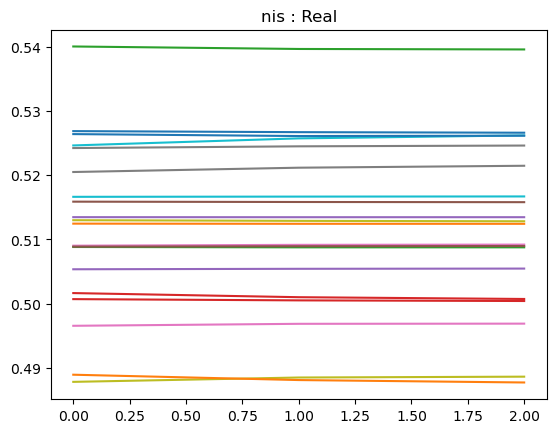

--- V = -4.6 ---
[0.    0.001 0.002 0.002 0.    0.    0.001 0.002 0.004 0.007 0.001 0.002
 0.    0.    0.001 0.002 0.003 0.003 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.001 0.001
 0.    0.    0.    0.    0.001 0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


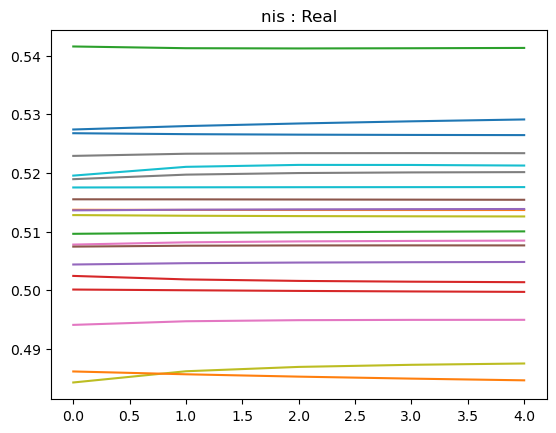

--- V = -4.7 ---
[0.    0.001 0.001 0.    0.    0.002 0.001 0.004 0.003 0.015 0.    0.007
 0.    0.002 0.001 0.003 0.002 0.005 0.    0.   ]
[0.    0.    0.002 0.    0.001 0.    0.001 0.002 0.006 0.008 0.007 0.004
 0.002 0.001 0.    0.002 0.    0.002 0.    0.   ]
[0.    0.    0.002 0.    0.002 0.001 0.002 0.002 0.008 0.008 0.007 0.006
 0.002 0.001 0.001 0.002 0.001 0.002 0.    0.   ]
[0.    0.    0.002 0.    0.002 0.001 0.002 0.002 0.009 0.008 0.008 0.007
 0.002 0.002 0.002 0.002 0.002 0.002 0.    0.   ]
[0.    0.    0.002 0.001 0.002 0.002 0.002 0.002 0.011 0.009 0.01  0.008
 0.002 0.002 0.002 0.002 0.002 0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.002 0.003 0.002 0.012 0.011 0.011 0.01
 0.003 0.002 0.002 0.002 0.003 0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.003 0.002 0.003 0.003 0.014 0.012 0.013 0.012
 0.003 0.003 0.003 0.002 0.003 0.003 0.    0.   ]
[0.    0.    0.003 0.002 0.003 0.003 0.004 0.003 0.017 0.014 0.016 0.014
 0.004 0.003 0.003 0.003 0.004 0.003 0.    0.   ]


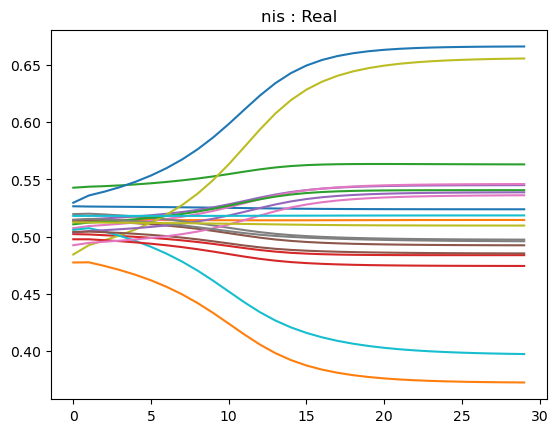

--- V = -4.8 ---
[0.    0.002 0.    0.    0.002 0.    0.001 0.    0.007 0.    0.004 0.
 0.    0.    0.003 0.    0.003 0.    0.    0.001]
[0.    0.    0.    0.    0.001 0.    0.    0.    0.004 0.001 0.002 0.
 0.    0.    0.002 0.    0.002 0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.001 0.001 0.
 0.    0.    0.001 0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


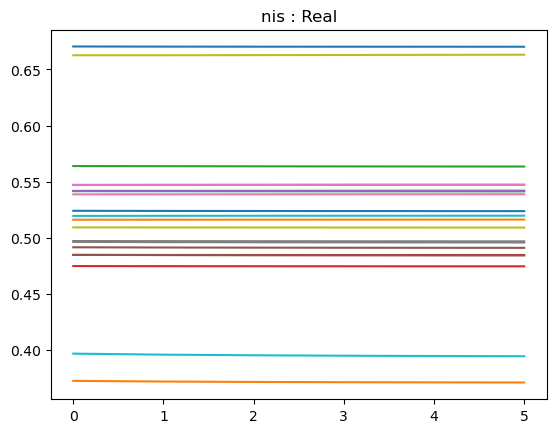

--- V = -4.9 ---
[0.    0.001 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.001 0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


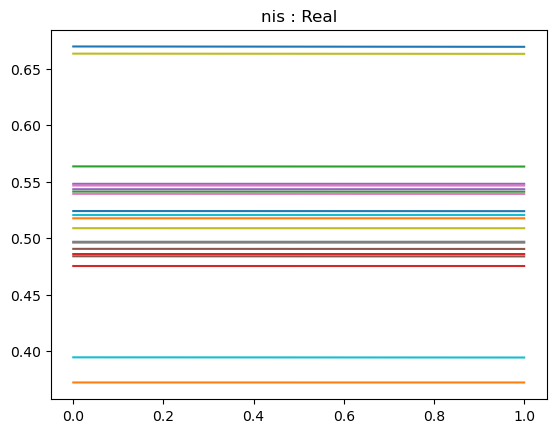

--- V = -5.0 ---
[0.    0.001 0.001 0.001 0.    0.    0.002 0.    0.007 0.    0.006 0.002
 0.002 0.    0.    0.    0.002 0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.001 0.    0.004 0.    0.004 0.002
 0.001 0.    0.    0.    0.001 0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.    0.003 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.    0.002 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.    0.002 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


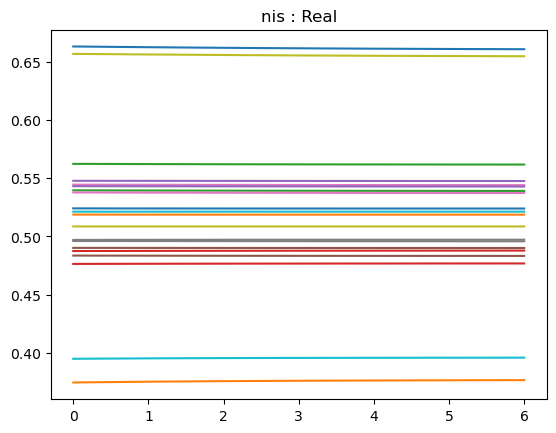

--- V = -5.1 ---
[0.    0.    0.004 0.002 0.004 0.    0.005 0.    0.02  0.003 0.021 0.005
 0.005 0.002 0.004 0.    0.005 0.    0.    0.   ]
[0.    0.    0.003 0.002 0.003 0.    0.004 0.    0.014 0.003 0.014 0.006
 0.003 0.002 0.003 0.    0.003 0.    0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.    0.003 0.    0.011 0.004 0.011 0.006
 0.003 0.002 0.002 0.    0.002 0.    0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.    0.002 0.    0.009 0.003 0.009 0.006
 0.002 0.001 0.002 0.    0.002 0.    0.    0.   ]
[0.    0.    0.002 0.001 0.002 0.    0.002 0.    0.008 0.003 0.008 0.006
 0.002 0.001 0.002 0.    0.002 0.    0.    0.   ]
[0.    0.    0.002 0.001 0.001 0.    0.002 0.    0.007 0.003 0.007 0.005
 0.002 0.001 0.001 0.    0.002 0.    0.    0.   ]
[0.    0.    0.001 0.001 0.001 0.    0.001 0.    0.006 0.003 0.007 0.005
 0.002 0.001 0.001 0.    0.001 0.    0.    0.   ]
[0.    0.    0.001 0.001 0.001 0.    0.001 0.    0.006 0.003 0.006 0.005
 0.001 0.    0.001 0.    0.001 0.    0.    0.   ]

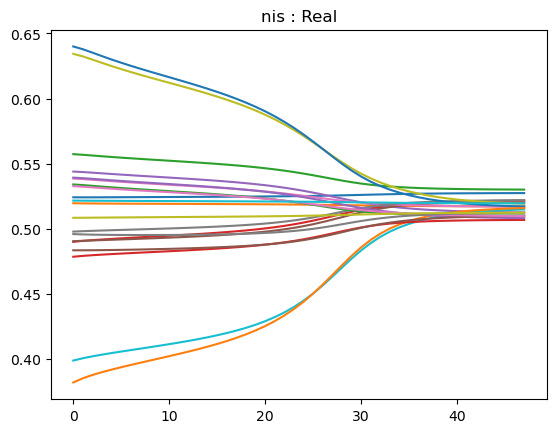

--- V = -5.2 ---
[0.    0.    0.    0.    0.    0.002 0.001 0.002 0.007 0.011 0.002 0.006
 0.    0.002 0.002 0.003 0.003 0.004 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.001 0.003 0.006 0.    0.003
 0.    0.001 0.    0.002 0.002 0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.003 0.    0.002
 0.    0.    0.    0.    0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.    0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


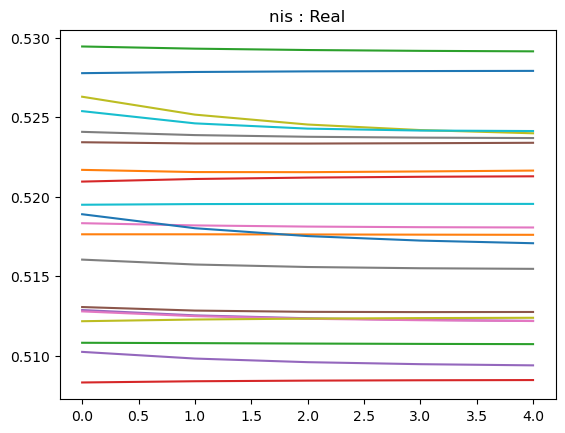

--- V = -5.3 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.004 0.005 0.    0.002
 0.    0.    0.001 0.002 0.002 0.002 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.003 0.    0.
 0.    0.    0.    0.    0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


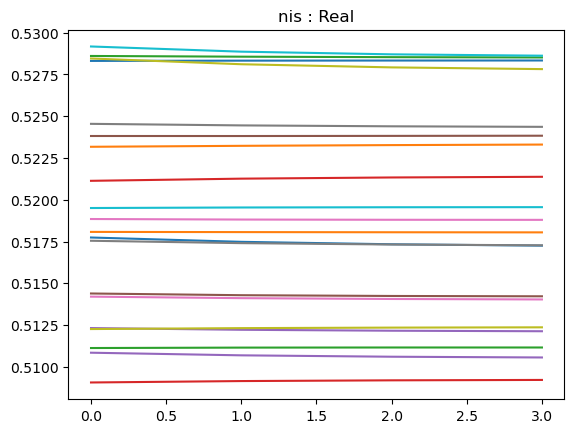

--- V = -5.4 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.003 0.003 0.    0.
 0.    0.    0.001 0.001 0.001 0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


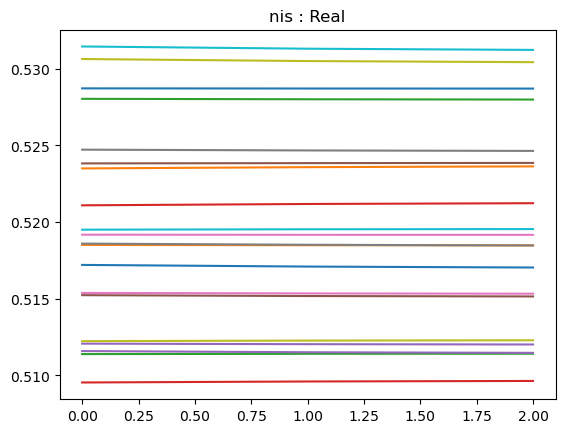

--- V = -5.5 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


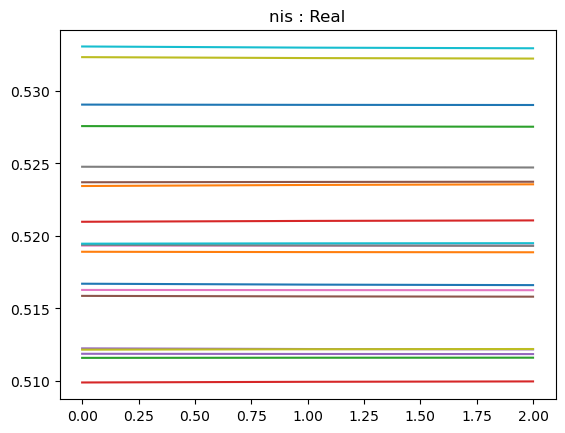

--- V = -5.6 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


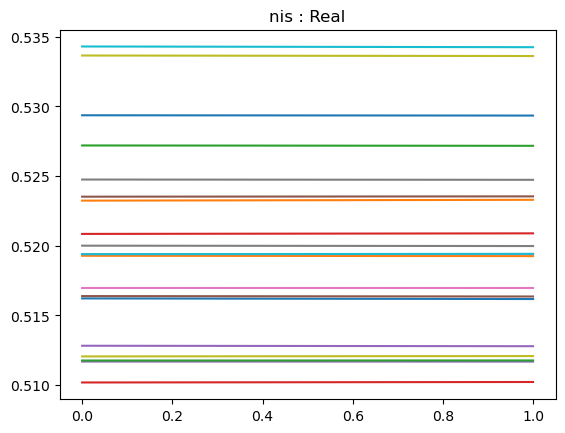

--- V = -5.7 ---
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


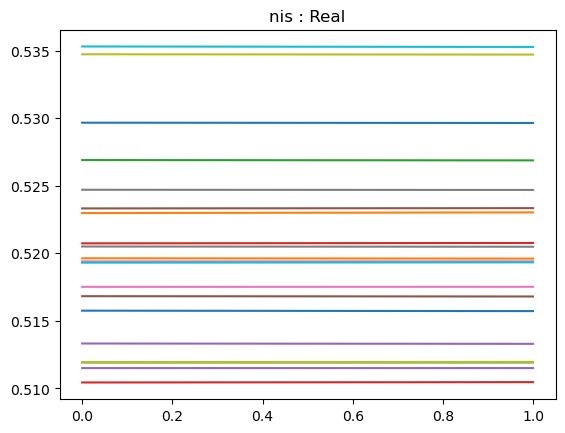

--- V = -5.8 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


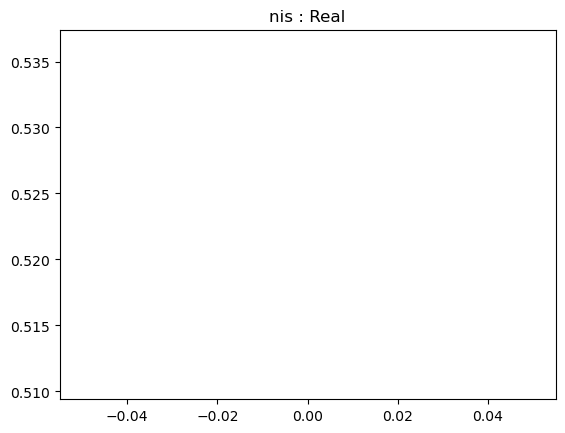

--- V = -5.9 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


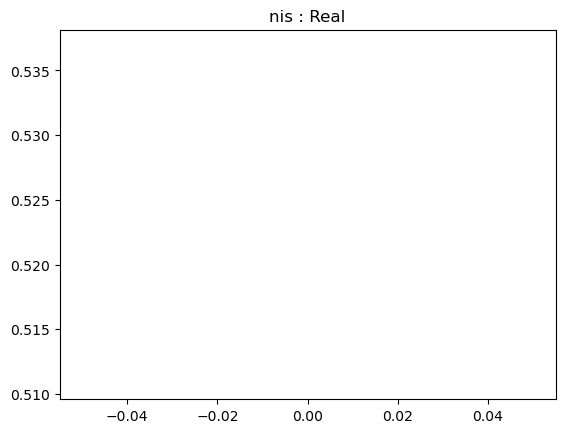

--- V = -6.0 ---
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


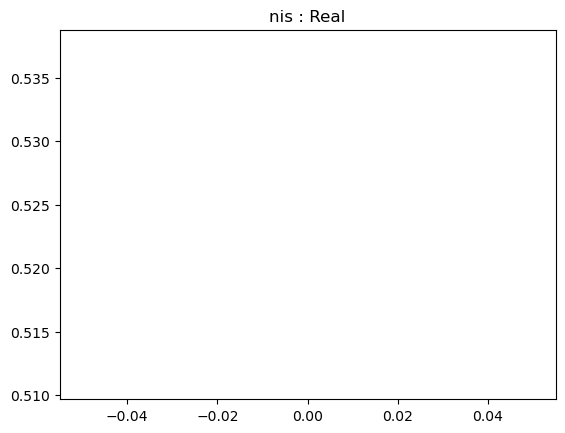

--- V = 0 ---
[0.007 0.007 0.008 0.008 0.002 0.002 0.002 0.002 0.    0.    0.005 0.005
 0.003 0.003 0.001 0.001 0.002 0.002 0.003 0.003]
[0.005 0.005 0.006 0.006 0.    0.    0.001 0.001 0.    0.    0.003 0.003
 0.002 0.002 0.001 0.001 0.002 0.002 0.002 0.002]
[0.004 0.004 0.004 0.004 0.    0.    0.    0.    0.    0.    0.003 0.003
 0.001 0.001 0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.003 0.003 0.    0.    0.    0.    0.    0.    0.002 0.002
 0.    0.    0.    0.    0.001 0.001 0.001 0.001]
[0.002 0.002 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.001 0.001 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 0.1 ---
[0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.


[0.003 0.004 0.005 0.007 0.006 0.01  0.004 0.008 0.002 0.002 0.    0.002
 0.005 0.007 0.007 0.01  0.003 0.006 0.002 0.004]
[0.003 0.003 0.005 0.005 0.006 0.007 0.004 0.005 0.001 0.001 0.    0.
 0.004 0.005 0.006 0.007 0.003 0.005 0.002 0.003]
[0.002 0.002 0.004 0.004 0.005 0.006 0.003 0.004 0.    0.    0.    0.
 0.004 0.004 0.005 0.006 0.003 0.004 0.001 0.002]
[0.002 0.002 0.003 0.003 0.004 0.005 0.003 0.003 0.    0.    0.    0.
 0.003 0.003 0.004 0.004 0.003 0.003 0.001 0.001]
[0.001 0.001 0.003 0.003 0.003 0.004 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.004 0.002 0.002 0.    0.001]
[0.    0.    0.002 0.002 0.003 0.003 0.002 0.002 0.    0.    0.    0.
 0.002 0.002 0.003 0.003 0.002 0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.002 0.001 0.002 0.    0.    0.    0.
 0.001 0.002 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.002 0.002 0.001 0.001 0.    0.    0.    0.
 0.001 0.001 0.002 0.002 0.001 0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.001 0.002 

[0.002 0.001 0.002 0.001 0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.    0.    0.002 0.001]
[0.001 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.    0.001 0.
 0.    0.    0.    0.    0.    0.    0.001 0.001]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 3.7 ---
[0.    0.002 0.001 0.    0.    0.    0.    0.    0.001 0.001 0.001 0.
 0.    0.    0.    0.    0.    0.001 0.    0.002]
[0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = 3.8000000000000003 ---
[0.004 0.006 0.    0.003 0.    0.    0.001 0.002 0.003 0.003 0.    0.002
 0.    0.    0.    0.    0.003 0.004 0.003 0.006]
[0.003 0.004 0.001 0.002 0.    0.    0.    0.001 0.002 0.002 0.    0.001
 0.    0.    0.    0.    0.003 0.003 0.003 0.004]
[0.003 0.003 0.001 0.00

[0.    0.    0.005 0.004 0.007 0.005 0.008 0.005 0.034 0.021 0.028 0.021
 0.006 0.005 0.007 0.004 0.009 0.004 0.    0.   ]
[0.    0.    0.005 0.004 0.007 0.004 0.008 0.004 0.035 0.02  0.028 0.021
 0.006 0.005 0.007 0.004 0.009 0.003 0.    0.   ]
[0.    0.    0.004 0.003 0.006 0.004 0.007 0.004 0.033 0.018 0.026 0.018
 0.006 0.004 0.007 0.003 0.009 0.003 0.    0.   ]
[0.    0.    0.003 0.003 0.006 0.003 0.007 0.003 0.029 0.016 0.023 0.016
 0.005 0.003 0.006 0.003 0.008 0.002 0.    0.   ]
[0.    0.    0.003 0.002 0.005 0.003 0.005 0.003 0.025 0.013 0.019 0.013
 0.004 0.003 0.006 0.002 0.007 0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.004 0.002 0.004 0.002 0.02  0.011 0.015 0.011
 0.003 0.002 0.005 0.002 0.006 0.002 0.    0.   ]
[0.    0.    0.001 0.001 0.003 0.002 0.003 0.002 0.016 0.009 0.012 0.009
 0.002 0.002 0.004 0.001 0.005 0.001 0.    0.   ]
[0.    0.    0.    0.    0.002 0.001 0.003 0.001 0.013 0.008 0.009 0.007
 0.002 0.001 0.003 0.001 0.004 0.001 0.    0.   ]
[0.    0.    0. 

[0.    0.    0.001 0.001 0.002 0.002 0.    0.001 0.005 0.008 0.006 0.007
 0.    0.001 0.002 0.002 0.001 0.002 0.    0.   ]
[0.    0.    0.    0.001 0.002 0.002 0.    0.001 0.005 0.006 0.005 0.006
 0.    0.001 0.002 0.002 0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.001 0.002 0.    0.    0.004 0.005 0.004 0.005
 0.    0.    0.001 0.002 0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.003 0.004 0.003 0.004
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.001 0.    0.    0.003 0.004 0.003 0.003
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.003 0.002 0.003
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.002 0.002 0.002
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0. 

[0.    0.    0.    0.    0.001 0.002 0.    0.001 0.    0.    0.    0.
 0.    0.001 0.001 0.002 0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.001 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.001 0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = -1.3000000000000003 ---
[0.    0.    0.    0.002 0.    0.002 0.    0.002 0.    0.    0.    0.
 0.    0.001 0.    0.002 0.    0.002 0.    0.001]
[0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = -1.4000000000000001 ---
[0.003 0.002 0.004 0.003 0.007 0.005 0.005 0.003 0.002 0.001 0.    0.
 0.005 0.004 0.007 0.005 0.003 0.002 0.002 0.001]
[0.002 0.002

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = -3.4000000000000004 ---
[0.005 0.005 0.004 0.003 0.    0.    0.    0.001 0.001 0.002 0.003 0.002
 0.002 0.    0.    0.    0.002 0.003 0.004 0.005]
[0.004 0.004 0.003 0.003 0.    0.    0.    0.    0.001 0.001 0.002 0.002
 0.001 0.    0.    0.    0.002 0.002 0.004 0.004]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.001 0.001 0.002 0.001
 0.    0.    0.    0.    0.002 0.002 0.003 0.003]
[0.003 0.003 0.002 0.002 0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.001 0.001 0.003 0.003]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.001
 0.    0.    0.    0.    0.001 0.001 0.002 0.002]
[0.002 0.002 0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.002 0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.002 0.002]
[0.001 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 

[0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001
 0.    0.    0.    0.    0.    0.001 0.001 0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = -4.5 ---
[0.002 0.    0.002 0.002 0.    0.    0.    0.001 0.003 0.003 0.    0.002
 0.    0.001 0.    0.    0.001 0.002 0.001 0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001
 0.    0.    0.    0.    0.    0.001 0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
--- V = -4.6 ---
[0.001 0.    0.002 0.002 0.    0.    0.002 0.001 0.007 0.004 0.002 0.001
 0.    0.    0.002 0.001 0.003 0.003 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.    0.001 0.001
 0.    0.    0.    0.    0.    0.001 0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.    0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0 0 0 0 0 0 0 0 0 0 

[0.    0.    0.001 0.001 0.001 0.001 0.    0.001 0.004 0.006 0.005 0.006
 0.001 0.001 0.    0.001 0.    0.001 0.    0.   ]
[0.    0.    0.001 0.001 0.001 0.001 0.    0.001 0.004 0.006 0.006 0.007
 0.001 0.001 0.    0.001 0.    0.001 0.    0.   ]
[0.    0.    0.001 0.002 0.001 0.002 0.001 0.001 0.005 0.006 0.006 0.007
 0.001 0.001 0.    0.002 0.    0.001 0.    0.   ]
[0.    0.    0.002 0.002 0.001 0.002 0.001 0.001 0.005 0.007 0.007 0.007
 0.001 0.002 0.    0.002 0.    0.001 0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.002 0.001 0.002 0.006 0.007 0.007 0.008
 0.002 0.002 0.001 0.002 0.    0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.002 0.001 0.002 0.007 0.008 0.008 0.009
 0.002 0.002 0.001 0.002 0.    0.002 0.    0.   ]
[0.    0.    0.002 0.002 0.002 0.002 0.002 0.002 0.008 0.009 0.009 0.01
 0.002 0.002 0.002 0.002 0.    0.002 0.    0.   ]
[0.    0.    0.003 0.002 0.002 0.003 0.002 0.002 0.009 0.01  0.011 0.01
 0.002 0.002 0.002 0.002 0.001 0.002 0.    0.   ]
[0.    0.    0.003

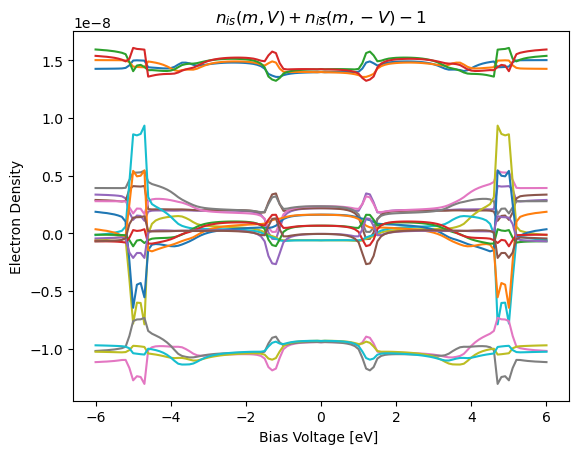

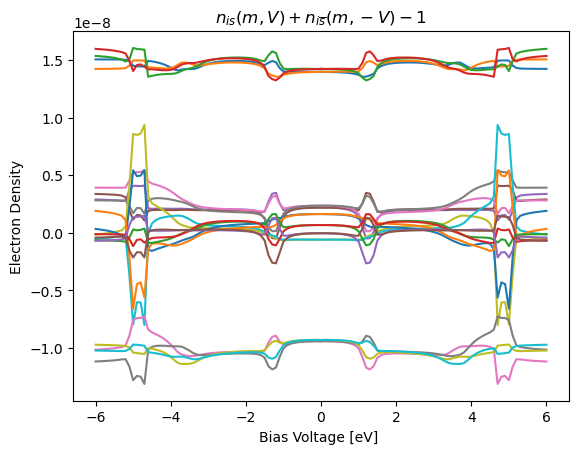

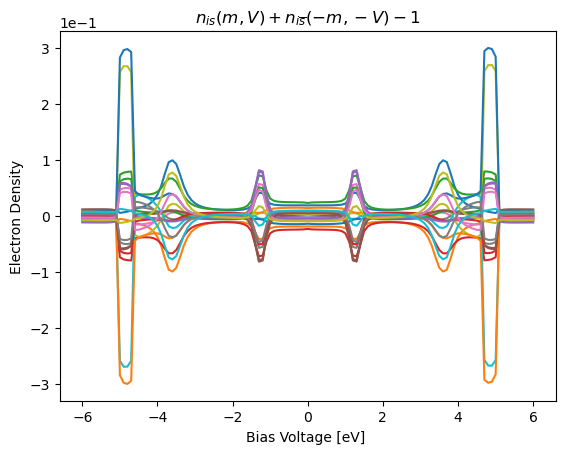

Lm2_Wg2_kmax4_pz0.5_epsilon0LR00_tleadLR9.6_9.6_tcoupLR1.5491933384829668_1.5491933384829668_T300_alpha0.6_t2.4_U2.4_lambda10.24_ef0_tol0.001_Vmax6_len121_emin-28.9_emax28.9_npoints10000_tolintegrand1e-15.txt
calculating currents ...


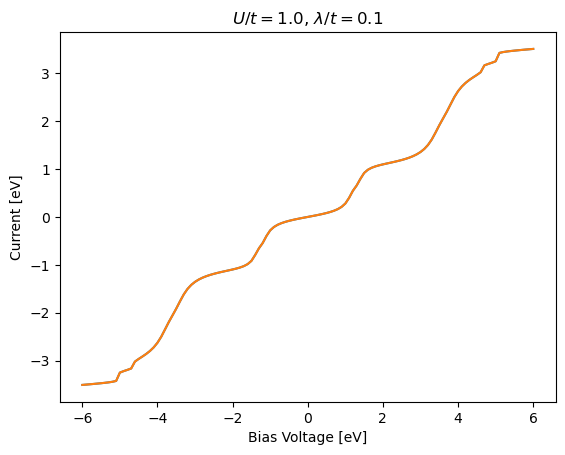

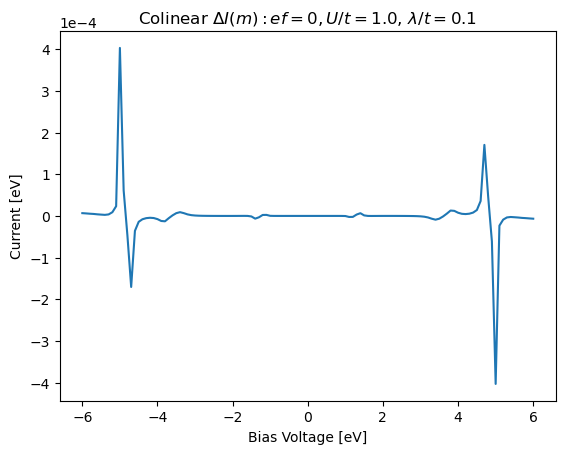

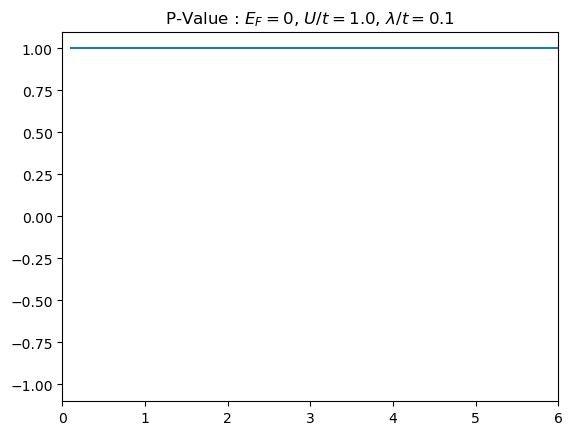

In [24]:
parameterlist = []
epsilon_sgeom = 0
factor1 = 1 
factor2 = 1
tsom = lambdalist[0]

for U in Ulist:
#     for factor2 in factorlist2:
    #Coupling lead-molecule
    tlead          = (4)*t             # hopping paramter lead strength
    tleadL,tleadR  = tlead,factor1*tlead       # hopping parameter left,right lead
    tcoupL,tcoupR  =  np.sqrt(tleadL)*0.5 ,factor2*np.sqrt(tleadR/factor1)*0.5 #coupling of right lead to the molecule
    print('tleadL, tleadR = {},{} & tcoupLR = {},{}'.format(tleadL,tleadR,tcoupL,tcoupR))
    chi1 = np.round(hfc.func_chi(tleadL , tleadR ),2)
    chi2 = np.round(hfc.func_chi(tcoupL , tcoupR ),2) 
    print(chi1,chi2)
    Hamiltonian0,matL,matR = Sgeom_scatteringregion.hamiltonian_multiplesites_coupled_semi_inf(Lm,Wg, t,tsom,plotbool=False)


    energies,ef = func_energies(Hamiltonian0,U,npoints,Vmax,epsilon0L,tleadL,epsilon0R,tleadR,pz) #energies to integrate over.


    ### Plot self energies of the lead.
    negf_method.plot_selfenergies(energies,epsilon0L,tleadL,tcoupL,pz)
    negf_method.plot_selfenergies(energies,epsilon0R,tleadR,tcoupR,0)


    emin = np.round(min(energies),1)
    emax = np.round(max(energies),1)


    print('--- ef = {}, tsom/t = {} , U/t = {},'.format(ef,tsom/t,U/t))
    n_list_totalP,convglistP = Integration_method.self_consistent_trapz_PN(V_list_pos_bias,Vmax,
                                  max_iteration,
                                ef,
                                Hamiltonian0,U,
                                epsilon0L,tleadL,tcoupL,matL,
                                epsilon0R,tleadR,tcoupR,matR,
                                   pz, 
                                betaL, betaR,tol,
                                energies,tol_nintegrand,alpha,plotbool=False,trackbool=False
                                                                          )


    n_list_totalM,convglistM = Integration_method.self_consistent_trapz_PN(V_list_pos_bias,Vmax,
                                  max_iteration,
                                ef,
                                Hamiltonian0,U,
                                epsilon0L,tleadL,tcoupL,matL,
                                epsilon0R,tleadR,tcoupR,matR,
                                   -pz, 
                                betaL, betaR,tol,
                                energies,tol_nintegrand,alpha,plotbool=False,trackbool=False)

    V_list_convg_old,nP_list_convg_old,nM_list_convg_old =  hfc.converged_lists(V_list_total,
                                                                  n_list_totalP ,convglistP,
                                                                  n_list_totalM, convglistM)

    V_list_convg,nP_list_convg,nM_list_convg =  hfc.func_symmetric_converged(V_list_total,
                                                                  n_list_totalP ,convglistP,
                                                                  n_list_totalM, convglistM) 


    parameterlist.append([npoints_current, Lm,Wg,kmax,pz,epsilon0L,epsilon0R,tleadL,tleadR,tcoupL,tcoupR, T,alpha,t,U,tsom,ef,tol,Vmax,len(V_list_total),emin,emax,npoints,tol_nintegrand])




    plot_densities_symmtry_relation(Hamiltonian0.shape[0],V_list_convg,nP_list_convg)
    plot_densities_symmtry_relation(Hamiltonian0.shape[0],V_list_convg,nM_list_convg)
    plot_densities_symmtry_relation2(nP_list_convg_old,nM_list_convg_old,V_list_convg_old,Hamiltonian0.shape[0])







    print('calculating currents ...')
    IP_list = Current_method.calc_I_trapz(npoints_current,
                V_list_convg,ef,
              Hamiltonian0,
              epsilon0L,tleadL,tcoupL,matL,
             epsilon0R,tleadR,tcoupR,matR,
              abs(pz),
              U,nP_list_convg,
              betaL,betaR)

    IM_list = Current_method.calc_I_trapz(npoints_current,
                    V_list_convg,ef,
                  Hamiltonian0,
                  epsilon0L,tleadL,tcoupL,matL,
                 epsilon0R,tleadR,tcoupR,matR,
                  -abs(pz),
                  U,nM_list_convg,
                  betaL,betaR)


    dIlist = np.subtract(IP_list,IM_list)
    Vprime, PClist = Current_method.func_MR_list(IP_list,IM_list,V_list_convg)

    plt.title('$U/t = {}$, $\lambda /t = {}$'.format(U/t,tsom/t))
    plt.plot(V_list_convg,IP_list)
    plt.plot(V_list_convg,IM_list)
    plt.xlabel('Bias Voltage [eV]')
    plt.ylabel('Current [eV]')
    plt.ticklabel_format(style="sci", scilimits=(0,0))
    plt.show()

    plt.title('Colinear $\Delta I(m): ef = {},U/t = {}$, $\lambda /t = {}$'.format(ef,U/t,tsom/t))
    plt.plot(V_list_convg,dIlist)
    plt.xlabel('Bias Voltage [eV]')
    plt.ylabel('Current [eV]')
    plt.ticklabel_format(style="sci", scilimits=(0,0))

    plt.show()

    plt.title('P-Value : $E_F = {} $, $U/t = {}$, $\lambda /t = {}$'.format(ef,U/t,tsom/t))
    Vlist_prime,PJ_list = Pvalue.function_PvaluedI(V_list_convg,dIlist,22)
    plt.plot(Vlist_prime,PJ_list)
    plt.xlim(0,Vmax)
    plt.ylim(-1-0.1,1+0.1)
    plt.show()



In [25]:
print(parameterlist)


[[10000, 2, 2, 4, 0.5, 0, 0, 9.6, 9.6, 1.5491933384829668, 1.5491933384829668, 300, 0.6, 2.4, 1.2, 0.24, 0, 0.001, 6, 121, -28.9, 28.9, 10000, 1e-15], [10000, 2, 2, 4, 0.5, 0, 0, 9.6, 9.6, 1.5491933384829668, 1.5491933384829668, 300, 0.6, 2.4, 2.4, 0.24, 0, 0.001, 6, 121, -28.9, 28.9, 10000, 1e-15]]
